In [ ]:
# %%

import base64
import functools
import html
import io
import os
import warnings

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.sharding
import big_vision.utils
import jax
import jax.lib
import jax.numpy as jnp
import kagglehub
import ml_collections
import numpy as np
import sentencepiece
import tensorflow as tf

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns
from IPython.core.display import HTML, display
from PIL import Image

SEQLEN = 128


def init_devices():
    # Don't let TF use the GPU or TPUs
    tf.config.set_visible_devices([], "GPU")
    tf.config.set_visible_devices([], "TPU")

    backend = jax.lib.xla_bridge.get_backend()
    print(f"JAX version:  {jax.__version__}")
    print(f"JAX platform: {backend.platform}")
    print(f"JAX devices:  {jax.device_count()}")


def load_pretrained_model():
    MODEL_PATH = "./pt_224_128.params.f16.npz"
    if not os.path.exists(MODEL_PATH):
        print(
            "Downloading the checkpoint from Kaggle, this could take a few minutes...."
        )
        # Download only the float16 model.
        MODEL_PATH = kagglehub.model_download(
            "google/paligemma/jax/paligemma-3b-pt-224", "paligemma-3b-pt-224.f16.npz"
        )
        print(f"Model path: {MODEL_PATH}")

    TOKENIZER_PATH = "./paligemma_tokenizer.model"
    if not os.path.exists(TOKENIZER_PATH):
        print("Downloading the model tokenizer...")
        os.system(
            f"gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}"
        )
        print(f"Tokenizer path: {TOKENIZER_PATH}")

    model_config = ml_collections.FrozenConfigDict(
        {
            "llm": {"vocab_size": 257_152},
            "img": {
                "variant": "So400m/14",
                "pool_type": "none",
                "scan": True,
                "dtype_mm": "float16",
            },
        }
    )
    model = paligemma.Model(**model_config)  # type: ignore
    tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)  # type: ignore

    # Load params - this can take up to 1 minute in T4 colabs.
    params = paligemma.load(None, MODEL_PATH, model_config)

    # Define `decode` function to sample outputs from the model.
    decode_fn = predict_fns.get_all(model)["decode"]
    decode = functools.partial(
        decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id()
    )

    return model, tokenizer, params, decode


# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
    if name.startswith("llm/layers/attn/"):
        return True
    if name.startswith("llm/"):
        return False
    if name.startswith("img/"):
        return False
    raise ValueError(f"Unexpected param name {name}")


def preprocess_image(image, size=224):
    """Model has been trained to handle images of different aspects ratios
    resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
    options are helpful to improve quality in some tasks."""

    image = np.asarray(image)
    if image.ndim == 2:  # Convert image without last channel into greyscale.
        image = np.stack((image,) * 3, axis=-1)
    image = image[..., :3]  # Remove alpha layer.
    assert image.shape[-1] == 3

    image = tf.constant(image)
    image = tf.image.resize(image, (size, size), method="bilinear", antialias=True)
    return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]


def preprocess_tokens(prefix, suffix=None, seqlen=None):
    """Model has been trained to handle tokenized text composed of a prefix with
    full attention and a suffix with causal attention."""
    separator = "\n"
    tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)  # type: ignore
    mask_ar = [0] * len(tokens)  # 0 to use full attention for prefix.
    mask_loss = [0] * len(tokens)  # 0 to not use prefix tokens in the loss.

    if suffix:
        suffix = tokenizer.encode(suffix, add_eos=True)  # type: ignore
        tokens += suffix
        mask_ar += [1] * len(suffix)  # 1 to use causal attention for suffix.
        mask_loss += [1] * len(suffix)  # 1 to use suffix tokens in the loss.

    mask_input = [1] * len(tokens)  # 1 if it's a token, 0 if padding.
    if seqlen:
        padding = [0] * max(0, seqlen - len(tokens))
        tokens = tokens[:seqlen] + padding
        mask_ar = mask_ar[:seqlen] + padding
        mask_loss = mask_loss[:seqlen] + padding
        mask_input = mask_input[:seqlen] + padding

    return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))


def postprocess_tokens(tokens):
    tokens = tokens.tolist()  # np.array to list[int]
    try:  # Remove tokens at and after EOS if any.
        eos_pos = tokens.index(tokenizer.eos_id())
        tokens = tokens[:eos_pos]
    except ValueError:
        pass
    return tokenizer.decode(tokens)  # type: ignore


@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
    imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

    def loss_fn(params):
        text_logits, _ = model.apply(
            {"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True
        )
        logp = jax.nn.log_softmax(text_logits, axis=-1)

        # The model takes as input txts[:, :-1] but the loss is defined as predicting
        # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
        # are part of the loss (e.g. prefix and padded tokens are not included).
        mask_loss = batch["mask_loss"][:, 1:]
        targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

        # Compute the loss per example. i.e. the mean of per token pplx.
        # Since each example has a different number of tokens we normalize it.
        token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
        example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
        example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

        # batch_loss: mean of per example loss.
        return jnp.mean(example_loss)

    loss, grads = jax.value_and_grad(loss_fn)(params)

    # Apply gradients to trainable params using SGD.
    def apply_grad(param, gradient, trainable):
        if not trainable:
            return param
        return param - learning_rate * gradient

    params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)
    return params, loss


@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
    return jax.tree.map(
        lambda p, m: p.astype(jnp.float32) if m else p, params, trainable
    )


def apply_params_sharding(params, params_sharding, trainable_mask):
    params, treedef = jax.tree.flatten(params)
    sharding_leaves = jax.tree.leaves(params_sharding)
    trainable_leaves = jax.tree.leaves(trainable_mask)
    for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
        params[idx] = big_vision.utils.reshard(params[idx], sharding)
        params[idx] = maybe_cast_to_f32(params[idx], trainable)
        params[idx].block_until_ready()
    params = jax.tree.unflatten(treedef, params)

    # Print params to show what the model is made of.
    def parameter_overview(params):
        for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
            print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

    print(" == Model params == ")
    parameter_overview(params)
    return params


def train_data_iterator():
    """Never ending iterator over training examples."""
    # Shuffle examples and repeat so one can train for many epochs.
    dataset = train_dataset.get_tfdata().shuffle(1_000).repeat()
    for example in dataset.as_numpy_iterator():
        image = Image.open(io.BytesIO(example["image"]))  # type: ignore
        image = preprocess_image(image)

        # prefix = "caption en"  # Could also be a different prefix per example.
        prefix = example["prefix"].decode().lower()  # type: ignore
        suffix = example["suffix"].decode().lower()  # type: ignore
        tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)
        label, _, _, _ = preprocess_tokens(suffix, seqlen=SEQLEN)

        yield {
            "image": np.asarray(image),
            "text": np.asarray(tokens),
            "label": np.asarray(label),
            "mask_ar": np.asarray(mask_ar),
            "mask_loss": np.asarray(mask_loss),
        }


def validation_data_iterator():
    """Single iterator over validation examples."""
    for example in val_dataset.get_tfdata(ordered=True).as_numpy_iterator():
        image = Image.open(io.BytesIO(example["image"]))  # type: ignore
        image = preprocess_image(image)

        prefix = example["prefix"].decode().lower()  # type: ignore
        suffix = example["suffix"].decode().lower()  # type: ignore
        tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)
        label, _, _, _ = preprocess_tokens(suffix, seqlen=SEQLEN)

        yield {
            "image": np.asarray(image),
            "text": np.asarray(tokens),
            "label": np.asarray(label),
            "mask_ar": np.asarray(mask_ar),
            "mask_input": np.asarray(mask_input),
        }


def render_inline(image, resize=(128, 128)):
    """Convert image into inline html."""
    image = Image.fromarray(image)
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format="jpeg")
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"


def render_example(image, caption):
    image = ((image + 1) / 2 * 255).astype(np.uint8)  # [-1,1] -> [0, 255]
    return f"""
    <div style="display: inline-flex; align-items: center; justify-content: center;">
        <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64,64))}" />
        <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
    </div>
    """


def show_train_samples():
    html_out = ""
    for idx, example in zip(range(8), train_data_iterator()):
        caption = postprocess_tokens(example["text"])  # detokenize model input.
        html_out += render_example(example["image"], caption)

    print("Training examples")
    display(HTML(html_out))


def make_predictions(
    params,
    data_iterator,
    *,
    num_examples=None,
    batch_size=4,
    seqlen=SEQLEN,
    sampler="greedy",
):
    outputs = []
    while True:
        # Construct a list of examples in the batch.
        examples = []
        try:
            for _ in range(batch_size):
                examples.append(next(data_iterator))
                examples[-1]["_mask"] = np.array(True)  # Indicates true example.
        except StopIteration:
            if len(examples) == 0:
                return outputs

        # Not enough examples to complete a batch. Pad by repeating last example.
        while len(examples) % batch_size:
            examples.append(dict(examples[-1]))
            examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

        # Convert list of examples into a dict of np.arrays and load onto devices.
        batch = jax.tree.map(lambda *x: np.stack(x), *examples)
        batch = big_vision.utils.reshard(batch, data_sharding)

        # Make model predictions
        tokens = decode(
            {"params": params}, batch=batch, max_decode_len=seqlen, sampler=sampler
        )

        # Fetch model predictions to device and detokenize.
        tokens, mask = jax.device_get((tokens, batch["_mask"]))
        tokens = tokens[mask]  # remove padding examples.
        labels = [postprocess_tokens(e["label"]) for e in examples]
        responses = [postprocess_tokens(t) for t in tokens]

        # Append to html output.
        for example, label, response in zip(examples, labels, responses):
            outputs.append(
                (postprocess_tokens(example["text"]), example["image"], label, response)
            )
            if num_examples is not None and len(outputs) >= num_examples:
                return outputs


def train(params):
    BATCH_SIZE = 16
    TRAIN_EXAMPLES = 2048 * 100
    LEARNING_RATE = 0.03

    TRAIN_STEPS = TRAIN_EXAMPLES // BATCH_SIZE
    EVAL_STEPS = min(TRAIN_STEPS // 4, 100)

    print("Train Steps: ", TRAIN_STEPS)
    print("Eval Steps: ", EVAL_STEPS)

    train_data_it = train_data_iterator()

    sched_fn = big_vision.utils.create_learning_rate_schedule(
        total_steps=TRAIN_STEPS + 1,
        base=LEARNING_RATE,
        decay_type="cosine",
        warmup_percent=0.10,
    )

    for step in range(1, TRAIN_STEPS + 1):
        # Make list of N training examples.
        examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

        # Convert list of examples into a dict of np.arrays and load onto devices.
        batch = jax.tree.map(lambda *x: np.stack(x), *examples)
        batch = big_vision.utils.reshard(batch, data_sharding)

        # Training step and report training loss
        learning_rate = sched_fn(step)
        params, loss = update_fn(params, batch, learning_rate)

        loss = jax.device_get(loss)
        print(
            f"step: {step:2d}/{TRAIN_STEPS:2d}   lr: {learning_rate:.5f}   loss: {loss:.4f}"
        )

        if (step % EVAL_STEPS) == 0:
            print(f"Model predictions at step {step}")
            html_out = ""
            for prefix, image, _, caption in make_predictions(
                params, validation_data_iterator(), num_examples=4, batch_size=4
            ):
                html_out += render_example(image, prefix + caption)
            display(HTML(html_out))

    # Evaluation After training ...
    print("Model predictions")
    html_out = ""
    for prefix, image, _, caption in make_predictions(
        params, validation_data_iterator(), batch_size=4
    ):
        html_out += render_example(image, prefix + caption)
    display(HTML(html_out))

2024-06-18 11:14:31.510652: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
<ipython-input-1-280e747e4969>:25: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


2024-06-18 11:14:32.625698: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


JAX version:  0.4.28
JAX platform: gpu
JAX devices:  2
Model path: /home/j2y/.cache/kagglehub/models/google/paligemma/jax/paligemma-3b-pt-224/1/paligemma-3b-pt-224.f16.npz
 == Model params == 
img/Transformer/encoder_norm/bias                                                (1152,)                float16
img/Transformer/encoder_norm/scale                                               (1152,)                float16
img/Transformer/encoderblock/LayerNorm_0/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_0/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/bias                                    (27, 1152)             float16
img/Transformer/encoderblock/LayerNorm_1/scale                                   (27, 1152)             float16
img/Transformer/encoderblock/MlpBlock_0/Dense_0/bias                             (27, 4304)             float16
img/Transformer/encoder


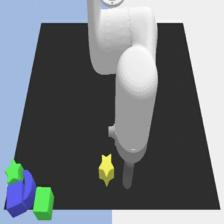
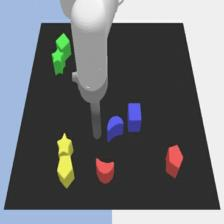
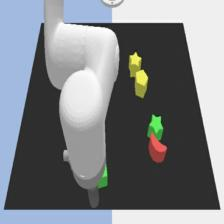
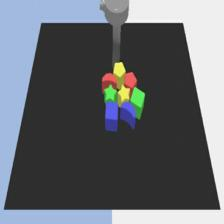
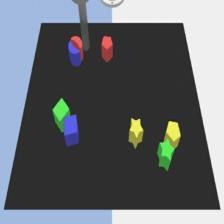
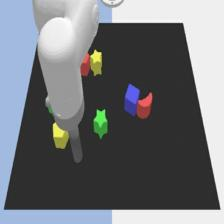
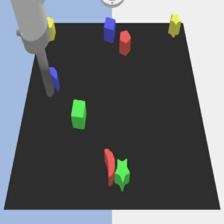
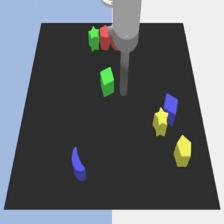

In [ ]:
# %%

if __name__ == "__main__":
    init_devices()
    model, tokenizer, params, decode = load_pretrained_model()
    trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

    # Define Shardings & apply it to params
    mesh = jax.sharding.Mesh(jax.devices(), ("data"))
    data_sharding = jax.sharding.NamedSharding(mesh, jax.sharding.PartitionSpec("data"))
    params_sharding = big_vision.sharding.infer_sharding(
        params, strategy=[(".*", 'fsdp(axis="data")')], mesh=mesh
    )

    warnings.filterwarnings("ignore", message="Some donated buffers were not usable")

    params = apply_params_sharding(
        params, params_sharding=params_sharding, trainable_mask=trainable_mask
    )

    # load datasets
    DATA_DIR_TRAIN = "./data/language_table_mini_train"
    train_dataset = big_vision.datasets.jsonl.DataSource(
        os.path.join(DATA_DIR_TRAIN, "_annotations.jsonl"),
        fopen_keys={"image": DATA_DIR_TRAIN},
    )

    DATA_DIR_VAL = "./data/language_table_mini_valid"
    val_dataset = big_vision.datasets.jsonl.DataSource(
        os.path.join(DATA_DIR_VAL, "_annotations.jsonl"),
        fopen_keys={"image": DATA_DIR_VAL},
    )

    show_train_samples()

Train Steps:  12800
Eval Steps:  100
step:  1/12800   lr: 0.00002   loss: 10.4332
step:  2/12800   lr: 0.00005   loss: 9.6757
step:  3/12800   lr: 0.00007   loss: 8.4807
step:  4/12800   lr: 0.00009   loss: 6.8157
step:  5/12800   lr: 0.00012   loss: 5.3561
step:  6/12800   lr: 0.00014   loss: 4.7941
step:  7/12800   lr: 0.00016   loss: 4.4230
step:  8/12800   lr: 0.00019   loss: 4.0297
step:  9/12800   lr: 0.00021   loss: 3.6347
step: 10/12800   lr: 0.00023   loss: 3.3216
step: 11/12800   lr: 0.00026   loss: 2.8426
step: 12/12800   lr: 0.00028   loss: 2.4678
step: 13/12800   lr: 0.00030   loss: 2.2285
step: 14/12800   lr: 0.00033   loss: 1.9246
step: 15/12800   lr: 0.00035   loss: 1.7698
step: 16/12800   lr: 0.00038   loss: 1.5839
step: 17/12800   lr: 0.00040   loss: 1.5331
step: 18/12800   lr: 0.00042   loss: 1.3539
step: 19/12800   lr: 0.00045   loss: 1.3374
step: 20/12800   lr: 0.00047   loss: 1.3133
step: 21/12800   lr: 0.00049   loss: 1.1075
step: 22/12800   lr: 0.00052   loss: 1


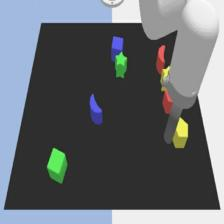
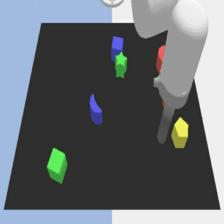
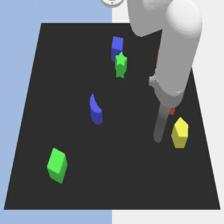
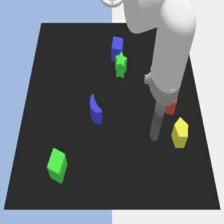

step: 101/12800   lr: 0.00237   loss: 0.6507
step: 102/12800   lr: 0.00239   loss: 0.6407
step: 103/12800   lr: 0.00241   loss: 0.5836
step: 104/12800   lr: 0.00244   loss: 0.6159
step: 105/12800   lr: 0.00246   loss: 0.6127
step: 106/12800   lr: 0.00248   loss: 0.6513
step: 107/12800   lr: 0.00251   loss: 0.6314
step: 108/12800   lr: 0.00253   loss: 0.6603
step: 109/12800   lr: 0.00255   loss: 0.7062
step: 110/12800   lr: 0.00258   loss: 0.6478
step: 111/12800   lr: 0.00260   loss: 0.7037
step: 112/12800   lr: 0.00262   loss: 0.6209
step: 113/12800   lr: 0.00265   loss: 0.6475
step: 114/12800   lr: 0.00267   loss: 0.6775
step: 115/12800   lr: 0.00270   loss: 0.6718
step: 116/12800   lr: 0.00272   loss: 0.6174
step: 117/12800   lr: 0.00274   loss: 0.6007
step: 118/12800   lr: 0.00277   loss: 0.6272
step: 119/12800   lr: 0.00279   loss: 0.7083
step: 120/12800   lr: 0.00281   loss: 0.6445
step: 121/12800   lr: 0.00284   loss: 0.6747
step: 122/12800   lr: 0.00286   loss: 0.6376
step: 123/


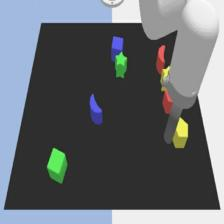
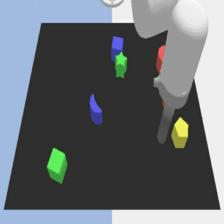
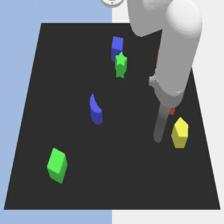
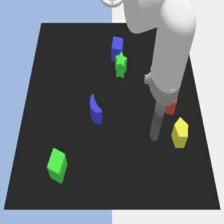

step: 201/12800   lr: 0.00471   loss: 0.6479
step: 202/12800   lr: 0.00473   loss: 0.7334
step: 203/12800   lr: 0.00476   loss: 0.6498
step: 204/12800   lr: 0.00478   loss: 0.6551
step: 205/12800   lr: 0.00480   loss: 0.6445
step: 206/12800   lr: 0.00483   loss: 0.6299
step: 207/12800   lr: 0.00485   loss: 0.6392
step: 208/12800   lr: 0.00487   loss: 0.6036
step: 209/12800   lr: 0.00490   loss: 0.6684
step: 210/12800   lr: 0.00492   loss: 0.6270
step: 211/12800   lr: 0.00495   loss: 0.6572
step: 212/12800   lr: 0.00497   loss: 0.6232
step: 213/12800   lr: 0.00499   loss: 0.6435
step: 214/12800   lr: 0.00502   loss: 0.6033
step: 215/12800   lr: 0.00504   loss: 0.5772
step: 216/12800   lr: 0.00506   loss: 0.6997
step: 217/12800   lr: 0.00509   loss: 0.6298
step: 218/12800   lr: 0.00511   loss: 0.6802
step: 219/12800   lr: 0.00513   loss: 0.6495
step: 220/12800   lr: 0.00516   loss: 0.6788
step: 221/12800   lr: 0.00518   loss: 0.6358
step: 222/12800   lr: 0.00520   loss: 0.6704
step: 223/


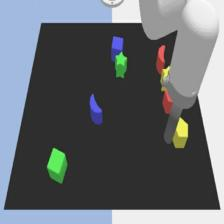
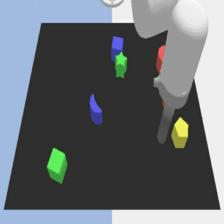
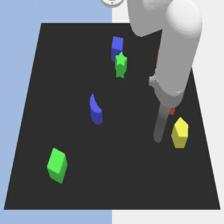
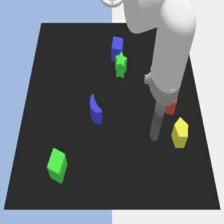

step: 301/12800   lr: 0.00705   loss: 0.6872
step: 302/12800   lr: 0.00708   loss: 0.6000
step: 303/12800   lr: 0.00710   loss: 0.6109
step: 304/12800   lr: 0.00712   loss: 0.6712
step: 305/12800   lr: 0.00715   loss: 0.6421
step: 306/12800   lr: 0.00717   loss: 0.6356
step: 307/12800   lr: 0.00720   loss: 0.6726
step: 308/12800   lr: 0.00722   loss: 0.6127
step: 309/12800   lr: 0.00724   loss: 0.6433
step: 310/12800   lr: 0.00727   loss: 0.6618
step: 311/12800   lr: 0.00729   loss: 0.6171
step: 312/12800   lr: 0.00731   loss: 0.6220
step: 313/12800   lr: 0.00734   loss: 0.6351
step: 314/12800   lr: 0.00736   loss: 0.6760
step: 315/12800   lr: 0.00738   loss: 0.6126
step: 316/12800   lr: 0.00741   loss: 0.6662
step: 317/12800   lr: 0.00743   loss: 0.6454
step: 318/12800   lr: 0.00745   loss: 0.6684
step: 319/12800   lr: 0.00748   loss: 0.6395
step: 320/12800   lr: 0.00750   loss: 0.6279
step: 321/12800   lr: 0.00752   loss: 0.6495
step: 322/12800   lr: 0.00755   loss: 0.5515
step: 323/


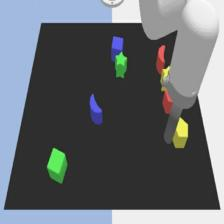
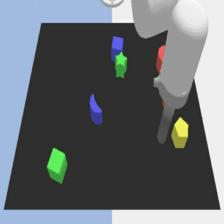
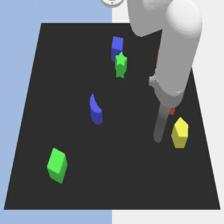
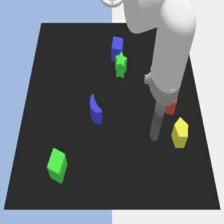

step: 401/12800   lr: 0.00940   loss: 2.4295
step: 402/12800   lr: 0.00942   loss: 2.4539
step: 403/12800   lr: 0.00945   loss: 2.2999
step: 404/12800   lr: 0.00947   loss: 2.4318
step: 405/12800   lr: 0.00949   loss: 2.1650
step: 406/12800   lr: 0.00952   loss: 2.1781
step: 407/12800   lr: 0.00954   loss: 1.9818
step: 408/12800   lr: 0.00956   loss: 2.0224
step: 409/12800   lr: 0.00959   loss: 1.9313
step: 410/12800   lr: 0.00961   loss: 1.9394
step: 411/12800   lr: 0.00963   loss: 1.9142
step: 412/12800   lr: 0.00966   loss: 1.8745
step: 413/12800   lr: 0.00968   loss: 1.7815
step: 414/12800   lr: 0.00970   loss: 1.7616
step: 415/12800   lr: 0.00973   loss: 1.7875
step: 416/12800   lr: 0.00975   loss: 1.5641
step: 417/12800   lr: 0.00977   loss: 1.6662
step: 418/12800   lr: 0.00980   loss: 1.6392
step: 419/12800   lr: 0.00982   loss: 1.7160
step: 420/12800   lr: 0.00984   loss: 1.7189
step: 421/12800   lr: 0.00987   loss: 1.6153
step: 422/12800   lr: 0.00989   loss: 1.5866
step: 423/


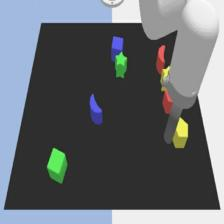
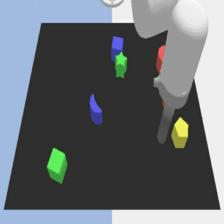
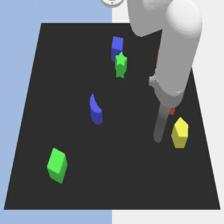
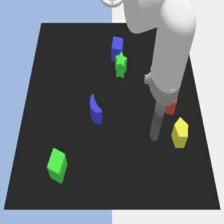

step: 501/12800   lr: 0.01174   loss: 1.2187
step: 502/12800   lr: 0.01177   loss: 1.2982
step: 503/12800   lr: 0.01179   loss: 1.2387
step: 504/12800   lr: 0.01181   loss: 1.2791
step: 505/12800   lr: 0.01184   loss: 1.3215
step: 506/12800   lr: 0.01186   loss: 1.2695
step: 507/12800   lr: 0.01188   loss: 1.2588
step: 508/12800   lr: 0.01191   loss: 1.2606
step: 509/12800   lr: 0.01193   loss: 1.2497
step: 510/12800   lr: 0.01195   loss: 1.2439
step: 511/12800   lr: 0.01198   loss: 1.2748
step: 512/12800   lr: 0.01200   loss: 1.2854
step: 513/12800   lr: 0.01202   loss: 1.2899
step: 514/12800   lr: 0.01205   loss: 1.1970
step: 515/12800   lr: 0.01207   loss: 1.3150
step: 516/12800   lr: 0.01209   loss: 1.2729
step: 517/12800   lr: 0.01212   loss: 1.3545
step: 518/12800   lr: 0.01214   loss: 1.2896
step: 519/12800   lr: 0.01216   loss: 1.2394
step: 520/12800   lr: 0.01219   loss: 1.2144
step: 521/12800   lr: 0.01221   loss: 1.2279
step: 522/12800   lr: 0.01223   loss: 1.2669
step: 523/


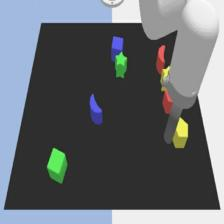
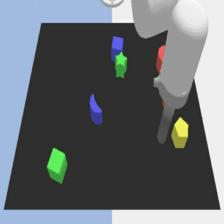
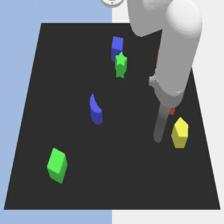
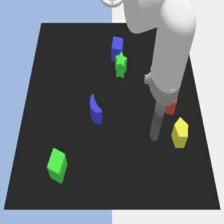

step: 601/12800   lr: 0.01409   loss: 1.1348
step: 602/12800   lr: 0.01411   loss: 1.1979
step: 603/12800   lr: 0.01413   loss: 1.1700
step: 604/12800   lr: 0.01416   loss: 1.0537
step: 605/12800   lr: 0.01418   loss: 1.2332
step: 606/12800   lr: 0.01420   loss: 1.0770
step: 607/12800   lr: 0.01423   loss: 1.1772
step: 608/12800   lr: 0.01425   loss: 1.1320
step: 609/12800   lr: 0.01427   loss: 1.0991
step: 610/12800   lr: 0.01430   loss: 1.1862
step: 611/12800   lr: 0.01432   loss: 1.0833
step: 612/12800   lr: 0.01434   loss: 1.1197
step: 613/12800   lr: 0.01437   loss: 1.0706
step: 614/12800   lr: 0.01439   loss: 1.1423
step: 615/12800   lr: 0.01441   loss: 1.0659
step: 616/12800   lr: 0.01444   loss: 1.1634
step: 617/12800   lr: 0.01446   loss: 1.1698
step: 618/12800   lr: 0.01448   loss: 1.2292
step: 619/12800   lr: 0.01451   loss: 1.1541
step: 620/12800   lr: 0.01453   loss: 1.1060
step: 621/12800   lr: 0.01455   loss: 1.1689
step: 622/12800   lr: 0.01458   loss: 1.0966
step: 623/


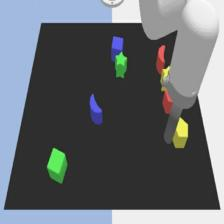
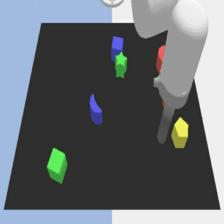
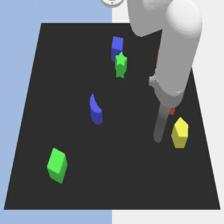
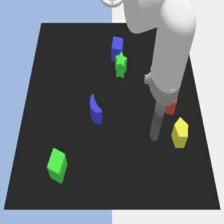

step: 701/12800   lr: 0.01643   loss: 1.0141
step: 702/12800   lr: 0.01645   loss: 0.9874
step: 703/12800   lr: 0.01648   loss: 1.1136
step: 704/12800   lr: 0.01650   loss: 1.0747
step: 705/12800   lr: 0.01652   loss: 1.0863
step: 706/12800   lr: 0.01655   loss: 1.0810
step: 707/12800   lr: 0.01657   loss: 1.0160
step: 708/12800   lr: 0.01659   loss: 1.1235
step: 709/12800   lr: 0.01662   loss: 0.9677
step: 710/12800   lr: 0.01664   loss: 1.0164
step: 711/12800   lr: 0.01666   loss: 0.9949
step: 712/12800   lr: 0.01669   loss: 1.0644
step: 713/12800   lr: 0.01671   loss: 1.1046
step: 714/12800   lr: 0.01673   loss: 1.0462
step: 715/12800   lr: 0.01676   loss: 0.9838
step: 716/12800   lr: 0.01678   loss: 1.0149
step: 717/12800   lr: 0.01680   loss: 1.0220
step: 718/12800   lr: 0.01683   loss: 1.0814
step: 719/12800   lr: 0.01685   loss: 0.9931
step: 720/12800   lr: 0.01687   loss: 0.9569
step: 721/12800   lr: 0.01690   loss: 1.0644
step: 722/12800   lr: 0.01692   loss: 1.0391
step: 723/


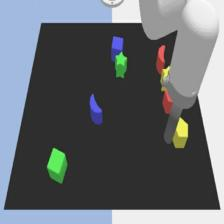
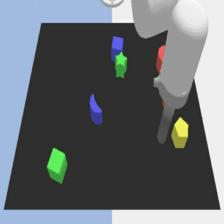
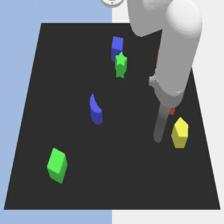
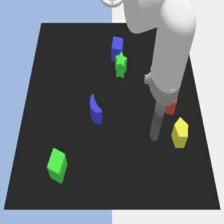

step: 801/12800   lr: 0.01877   loss: 0.9141
step: 802/12800   lr: 0.01880   loss: 0.8984
step: 803/12800   lr: 0.01882   loss: 0.9515
step: 804/12800   lr: 0.01884   loss: 0.8922
step: 805/12800   lr: 0.01887   loss: 0.9863
step: 806/12800   lr: 0.01889   loss: 0.9412
step: 807/12800   lr: 0.01891   loss: 0.8814
step: 808/12800   lr: 0.01894   loss: 0.9114
step: 809/12800   lr: 0.01896   loss: 0.9276
step: 810/12800   lr: 0.01898   loss: 0.8513
step: 811/12800   lr: 0.01901   loss: 0.9149
step: 812/12800   lr: 0.01903   loss: 0.8892
step: 813/12800   lr: 0.01905   loss: 0.9072
step: 814/12800   lr: 0.01908   loss: 0.9006
step: 815/12800   lr: 0.01910   loss: 0.9925
step: 816/12800   lr: 0.01912   loss: 0.9075
step: 817/12800   lr: 0.01915   loss: 0.9808
step: 818/12800   lr: 0.01917   loss: 0.9118
step: 819/12800   lr: 0.01920   loss: 0.9005
step: 820/12800   lr: 0.01922   loss: 0.9318
step: 821/12800   lr: 0.01924   loss: 0.9259
step: 822/12800   lr: 0.01927   loss: 0.8923
step: 823/


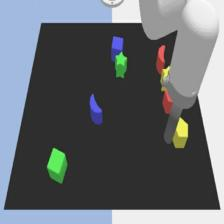
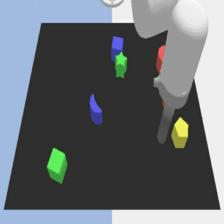
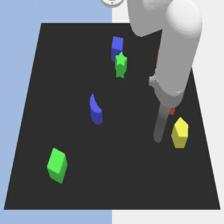
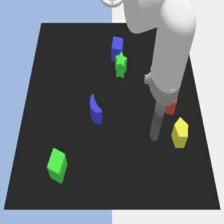

step: 901/12800   lr: 0.02112   loss: 0.8033
step: 902/12800   lr: 0.02114   loss: 0.8400
step: 903/12800   lr: 0.02116   loss: 0.8324
step: 904/12800   lr: 0.02119   loss: 0.7990
step: 905/12800   lr: 0.02121   loss: 0.7985
step: 906/12800   lr: 0.02123   loss: 0.8736
step: 907/12800   lr: 0.02126   loss: 0.8011
step: 908/12800   lr: 0.02128   loss: 0.8673
step: 909/12800   lr: 0.02130   loss: 0.8133
step: 910/12800   lr: 0.02133   loss: 0.7668
step: 911/12800   lr: 0.02135   loss: 0.8661
step: 912/12800   lr: 0.02137   loss: 0.8480
step: 913/12800   lr: 0.02140   loss: 0.7676
step: 914/12800   lr: 0.02142   loss: 0.7877
step: 915/12800   lr: 0.02145   loss: 0.8732
step: 916/12800   lr: 0.02147   loss: 0.8210
step: 917/12800   lr: 0.02149   loss: 0.8096
step: 918/12800   lr: 0.02152   loss: 0.8308
step: 919/12800   lr: 0.02154   loss: 0.8146
step: 920/12800   lr: 0.02156   loss: 0.8187
step: 921/12800   lr: 0.02159   loss: 0.7602
step: 922/12800   lr: 0.02161   loss: 0.7596
step: 923/


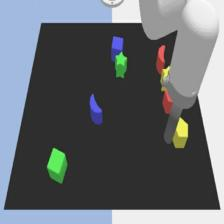
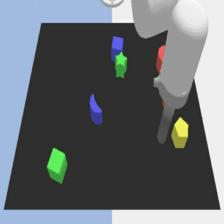
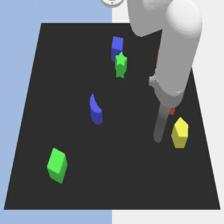
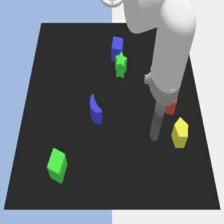

step: 1001/12800   lr: 0.02346   loss: 0.8915
step: 1002/12800   lr: 0.02348   loss: 0.8473
step: 1003/12800   lr: 0.02351   loss: 0.8353
step: 1004/12800   lr: 0.02353   loss: 0.8836
step: 1005/12800   lr: 0.02355   loss: 0.8369
step: 1006/12800   lr: 0.02358   loss: 0.8905
step: 1007/12800   lr: 0.02360   loss: 0.8553
step: 1008/12800   lr: 0.02362   loss: 0.8089
step: 1009/12800   lr: 0.02365   loss: 0.8952
step: 1010/12800   lr: 0.02367   loss: 0.8378
step: 1011/12800   lr: 0.02370   loss: 0.7832
step: 1012/12800   lr: 0.02372   loss: 0.8425
step: 1013/12800   lr: 0.02374   loss: 0.8334
step: 1014/12800   lr: 0.02377   loss: 0.9148
step: 1015/12800   lr: 0.02379   loss: 0.8186
step: 1016/12800   lr: 0.02381   loss: 0.8329
step: 1017/12800   lr: 0.02384   loss: 0.8176
step: 1018/12800   lr: 0.02386   loss: 0.8096
step: 1019/12800   lr: 0.02388   loss: 0.8274
step: 1020/12800   lr: 0.02391   loss: 0.8293
step: 1021/12800   lr: 0.02393   loss: 0.8630
step: 1022/12800   lr: 0.02395   l


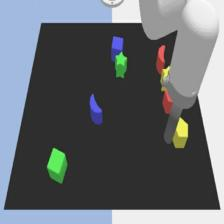
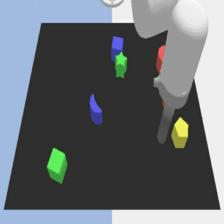
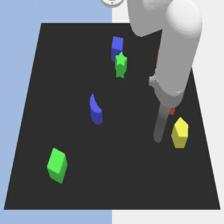
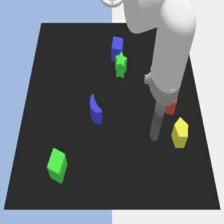

step: 1101/12800   lr: 0.02580   loss: 0.7290
step: 1102/12800   lr: 0.02583   loss: 0.7467
step: 1103/12800   lr: 0.02585   loss: 0.7800
step: 1104/12800   lr: 0.02588   loss: 0.7727
step: 1105/12800   lr: 0.02590   loss: 0.7506
step: 1106/12800   lr: 0.02592   loss: 0.8034
step: 1107/12800   lr: 0.02595   loss: 0.7427
step: 1108/12800   lr: 0.02597   loss: 0.6937
step: 1109/12800   lr: 0.02599   loss: 0.7145
step: 1110/12800   lr: 0.02602   loss: 0.7513
step: 1111/12800   lr: 0.02604   loss: 0.7636
step: 1112/12800   lr: 0.02606   loss: 0.7577
step: 1113/12800   lr: 0.02609   loss: 0.7504
step: 1114/12800   lr: 0.02611   loss: 0.7189
step: 1115/12800   lr: 0.02613   loss: 0.7601
step: 1116/12800   lr: 0.02616   loss: 0.7437
step: 1117/12800   lr: 0.02618   loss: 0.7380
step: 1118/12800   lr: 0.02620   loss: 0.7368
step: 1119/12800   lr: 0.02623   loss: 0.7036
step: 1120/12800   lr: 0.02625   loss: 0.7833
step: 1121/12800   lr: 0.02627   loss: 0.7557
step: 1122/12800   lr: 0.02630   l


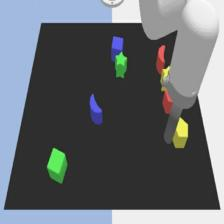
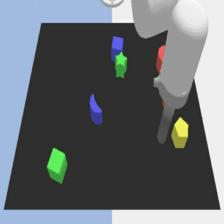
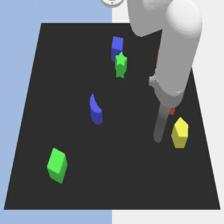
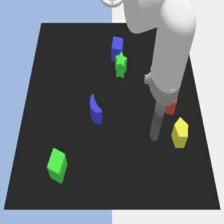

step: 1201/12800   lr: 0.02815   loss: 0.7259
step: 1202/12800   lr: 0.02817   loss: 0.6545
step: 1203/12800   lr: 0.02820   loss: 0.6766
step: 1204/12800   lr: 0.02822   loss: 0.6910
step: 1205/12800   lr: 0.02824   loss: 0.7215
step: 1206/12800   lr: 0.02827   loss: 0.7797
step: 1207/12800   lr: 0.02829   loss: 0.7160
step: 1208/12800   lr: 0.02831   loss: 0.7652
step: 1209/12800   lr: 0.02834   loss: 0.7265
step: 1210/12800   lr: 0.02836   loss: 0.7057
step: 1211/12800   lr: 0.02838   loss: 0.7005
step: 1212/12800   lr: 0.02841   loss: 0.7204
step: 1213/12800   lr: 0.02843   loss: 0.7265
step: 1214/12800   lr: 0.02845   loss: 0.7385
step: 1215/12800   lr: 0.02848   loss: 0.7130
step: 1216/12800   lr: 0.02850   loss: 0.6776
step: 1217/12800   lr: 0.02852   loss: 0.7258
step: 1218/12800   lr: 0.02855   loss: 0.7365
step: 1219/12800   lr: 0.02857   loss: 0.6757
step: 1220/12800   lr: 0.02859   loss: 0.6844
step: 1221/12800   lr: 0.02862   loss: 0.7099
step: 1222/12800   lr: 0.02864   l


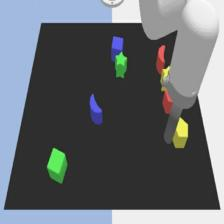
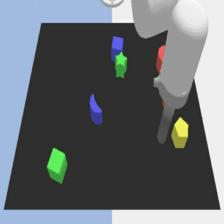
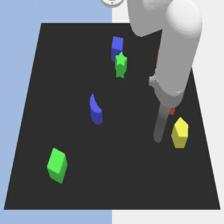
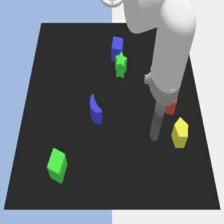

step: 1301/12800   lr: 0.03000   loss: 0.7107
step: 1302/12800   lr: 0.03000   loss: 0.6759
step: 1303/12800   lr: 0.03000   loss: 0.6787
step: 1304/12800   lr: 0.03000   loss: 0.6596
step: 1305/12800   lr: 0.03000   loss: 0.7275
step: 1306/12800   lr: 0.03000   loss: 0.6695
step: 1307/12800   lr: 0.03000   loss: 0.6449
step: 1308/12800   lr: 0.03000   loss: 0.6505
step: 1309/12800   lr: 0.03000   loss: 0.6937
step: 1310/12800   lr: 0.03000   loss: 0.6497
step: 1311/12800   lr: 0.03000   loss: 0.7304
step: 1312/12800   lr: 0.03000   loss: 0.6724
step: 1313/12800   lr: 0.03000   loss: 0.6512
step: 1314/12800   lr: 0.03000   loss: 0.6199
step: 1315/12800   lr: 0.03000   loss: 0.7274
step: 1316/12800   lr: 0.03000   loss: 0.7201
step: 1317/12800   lr: 0.03000   loss: 0.7299
step: 1318/12800   lr: 0.03000   loss: 0.6866
step: 1319/12800   lr: 0.03000   loss: 0.6976
step: 1320/12800   lr: 0.03000   loss: 0.6741
step: 1321/12800   lr: 0.03000   loss: 0.7195
step: 1322/12800   lr: 0.03000   l


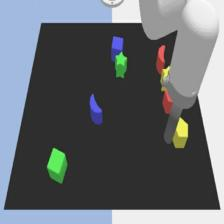
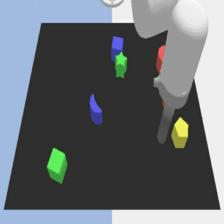
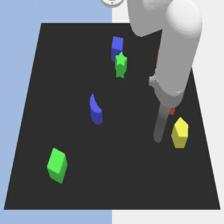
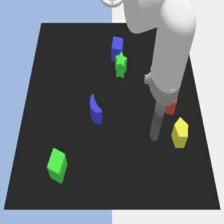

step: 1401/12800   lr: 0.02999   loss: 0.7046
step: 1402/12800   lr: 0.02999   loss: 0.6705
step: 1403/12800   lr: 0.02999   loss: 0.6339
step: 1404/12800   lr: 0.02999   loss: 0.6848
step: 1405/12800   lr: 0.02999   loss: 0.6615
step: 1406/12800   lr: 0.02999   loss: 0.6957
step: 1407/12800   lr: 0.02999   loss: 0.6890
step: 1408/12800   lr: 0.02999   loss: 0.6387
step: 1409/12800   lr: 0.02999   loss: 0.6927
step: 1410/12800   lr: 0.02999   loss: 0.6473
step: 1411/12800   lr: 0.02999   loss: 0.6891
step: 1412/12800   lr: 0.02999   loss: 0.7122
step: 1413/12800   lr: 0.02999   loss: 0.6498
step: 1414/12800   lr: 0.02999   loss: 0.6444
step: 1415/12800   lr: 0.02999   loss: 0.6777
step: 1416/12800   lr: 0.02999   loss: 0.6433
step: 1417/12800   lr: 0.02999   loss: 0.6811
step: 1418/12800   lr: 0.02999   loss: 0.6834
step: 1419/12800   lr: 0.02999   loss: 0.6840
step: 1420/12800   lr: 0.02999   loss: 0.6998
step: 1421/12800   lr: 0.02999   loss: 0.6737
step: 1422/12800   lr: 0.02999   l


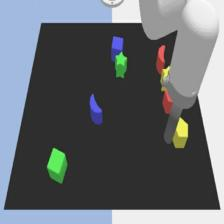
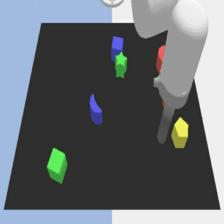
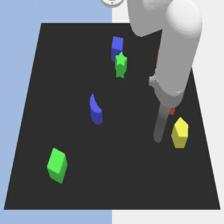
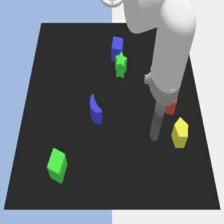

step: 1501/12800   lr: 0.02997   loss: 0.7032
step: 1502/12800   lr: 0.02997   loss: 0.6336
step: 1503/12800   lr: 0.02997   loss: 0.7084
step: 1504/12800   lr: 0.02997   loss: 0.6752
step: 1505/12800   lr: 0.02997   loss: 0.6750
step: 1506/12800   lr: 0.02997   loss: 0.6536
step: 1507/12800   lr: 0.02997   loss: 0.6182
step: 1508/12800   lr: 0.02997   loss: 0.6878
step: 1509/12800   lr: 0.02997   loss: 0.6102
step: 1510/12800   lr: 0.02997   loss: 0.6521
step: 1511/12800   lr: 0.02997   loss: 0.6575
step: 1512/12800   lr: 0.02997   loss: 0.6674
step: 1513/12800   lr: 0.02997   loss: 0.6484
step: 1514/12800   lr: 0.02997   loss: 0.6570
step: 1515/12800   lr: 0.02997   loss: 0.6587
step: 1516/12800   lr: 0.02997   loss: 0.6395
step: 1517/12800   lr: 0.02997   loss: 0.6913
step: 1518/12800   lr: 0.02997   loss: 0.6840
step: 1519/12800   lr: 0.02997   loss: 0.6684
step: 1520/12800   lr: 0.02997   loss: 0.6132
step: 1521/12800   lr: 0.02997   loss: 0.6317
step: 1522/12800   lr: 0.02997   l


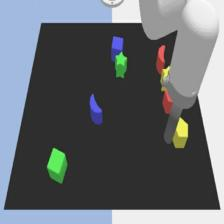
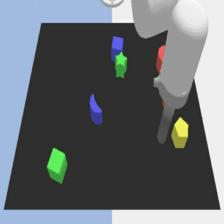
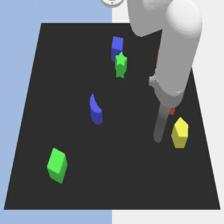
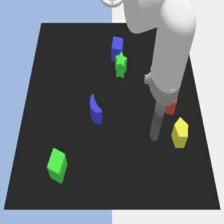

step: 1601/12800   lr: 0.02994   loss: 0.6870
step: 1602/12800   lr: 0.02994   loss: 0.6276
step: 1603/12800   lr: 0.02994   loss: 0.6795
step: 1604/12800   lr: 0.02994   loss: 0.6952
step: 1605/12800   lr: 0.02994   loss: 0.6332
step: 1606/12800   lr: 0.02994   loss: 0.6692
step: 1607/12800   lr: 0.02994   loss: 0.7024
step: 1608/12800   lr: 0.02994   loss: 0.7058
step: 1609/12800   lr: 0.02994   loss: 0.6641
step: 1610/12800   lr: 0.02994   loss: 0.6774
step: 1611/12800   lr: 0.02994   loss: 0.6620
step: 1612/12800   lr: 0.02994   loss: 0.7173
step: 1613/12800   lr: 0.02994   loss: 0.6390
step: 1614/12800   lr: 0.02994   loss: 0.7025
step: 1615/12800   lr: 0.02994   loss: 0.6813
step: 1616/12800   lr: 0.02994   loss: 0.6228
step: 1617/12800   lr: 0.02994   loss: 0.6750
step: 1618/12800   lr: 0.02994   loss: 0.6467
step: 1619/12800   lr: 0.02994   loss: 0.6512
step: 1620/12800   lr: 0.02994   loss: 0.6694
step: 1621/12800   lr: 0.02994   loss: 0.6404
step: 1622/12800   lr: 0.02993   l


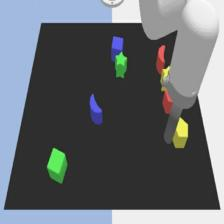
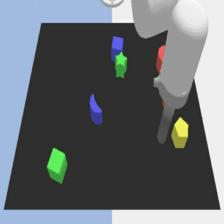
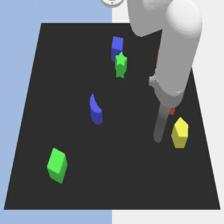
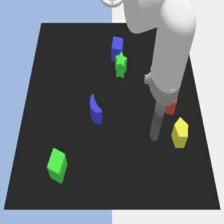

step: 1701/12800   lr: 0.02990   loss: 0.5981
step: 1702/12800   lr: 0.02990   loss: 0.6964
step: 1703/12800   lr: 0.02990   loss: 0.6241
step: 1704/12800   lr: 0.02990   loss: 0.6860
step: 1705/12800   lr: 0.02990   loss: 0.6378
step: 1706/12800   lr: 0.02990   loss: 0.6815
step: 1707/12800   lr: 0.02990   loss: 0.6742
step: 1708/12800   lr: 0.02990   loss: 0.6063
step: 1709/12800   lr: 0.02990   loss: 0.6391
step: 1710/12800   lr: 0.02990   loss: 0.6253
step: 1711/12800   lr: 0.02990   loss: 0.6474
step: 1712/12800   lr: 0.02990   loss: 0.6632
step: 1713/12800   lr: 0.02990   loss: 0.6753
step: 1714/12800   lr: 0.02990   loss: 0.6652
step: 1715/12800   lr: 0.02989   loss: 0.6923
step: 1716/12800   lr: 0.02989   loss: 0.6771
step: 1717/12800   lr: 0.02989   loss: 0.6394
step: 1718/12800   lr: 0.02989   loss: 0.6790
step: 1719/12800   lr: 0.02989   loss: 0.6575
step: 1720/12800   lr: 0.02989   loss: 0.6311
step: 1721/12800   lr: 0.02989   loss: 0.6770
step: 1722/12800   lr: 0.02989   l


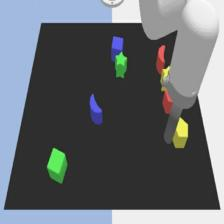
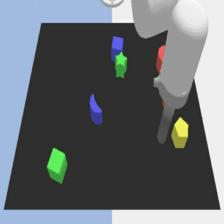
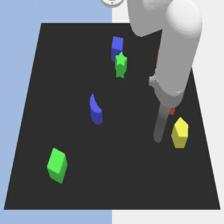
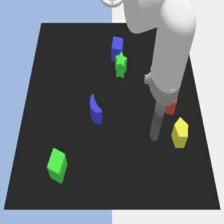

step: 1801/12800   lr: 0.02985   loss: 0.6470
step: 1802/12800   lr: 0.02985   loss: 0.6107
step: 1803/12800   lr: 0.02985   loss: 0.6837
step: 1804/12800   lr: 0.02985   loss: 0.6474
step: 1805/12800   lr: 0.02985   loss: 0.6638
step: 1806/12800   lr: 0.02985   loss: 0.7043
step: 1807/12800   lr: 0.02985   loss: 0.6266
step: 1808/12800   lr: 0.02984   loss: 0.6677
step: 1809/12800   lr: 0.02984   loss: 0.6689
step: 1810/12800   lr: 0.02984   loss: 0.6423
step: 1811/12800   lr: 0.02984   loss: 0.6568
step: 1812/12800   lr: 0.02984   loss: 0.6391
step: 1813/12800   lr: 0.02984   loss: 0.6814
step: 1814/12800   lr: 0.02984   loss: 0.6640
step: 1815/12800   lr: 0.02984   loss: 0.6542
step: 1816/12800   lr: 0.02984   loss: 0.6054
step: 1817/12800   lr: 0.02984   loss: 0.6664
step: 1818/12800   lr: 0.02984   loss: 0.6307
step: 1819/12800   lr: 0.02984   loss: 0.6686
step: 1820/12800   lr: 0.02984   loss: 0.6303
step: 1821/12800   lr: 0.02984   loss: 0.6570
step: 1822/12800   lr: 0.02984   l


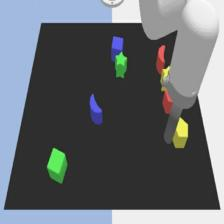
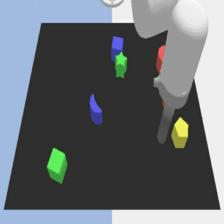
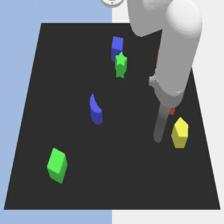
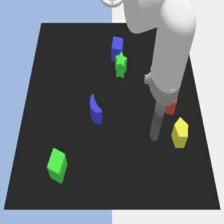

step: 1901/12800   lr: 0.02979   loss: 0.6326
step: 1902/12800   lr: 0.02978   loss: 0.6423
step: 1903/12800   lr: 0.02978   loss: 0.6314
step: 1904/12800   lr: 0.02978   loss: 0.6570
step: 1905/12800   lr: 0.02978   loss: 0.6184
step: 1906/12800   lr: 0.02978   loss: 0.6708
step: 1907/12800   lr: 0.02978   loss: 0.6481
step: 1908/12800   lr: 0.02978   loss: 0.6395
step: 1909/12800   lr: 0.02978   loss: 0.6277
step: 1910/12800   lr: 0.02978   loss: 0.6544
step: 1911/12800   lr: 0.02978   loss: 0.6476
step: 1912/12800   lr: 0.02978   loss: 0.6651
step: 1913/12800   lr: 0.02978   loss: 0.6980
step: 1914/12800   lr: 0.02978   loss: 0.6431
step: 1915/12800   lr: 0.02978   loss: 0.6543
step: 1916/12800   lr: 0.02977   loss: 0.6249
step: 1917/12800   lr: 0.02977   loss: 0.6477
step: 1918/12800   lr: 0.02977   loss: 0.6518
step: 1919/12800   lr: 0.02977   loss: 0.6459
step: 1920/12800   lr: 0.02977   loss: 0.6814
step: 1921/12800   lr: 0.02977   loss: 0.7069
step: 1922/12800   lr: 0.02977   l


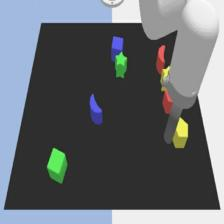
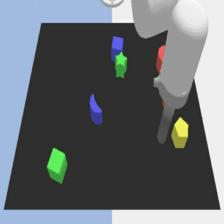
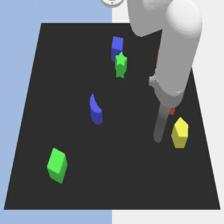
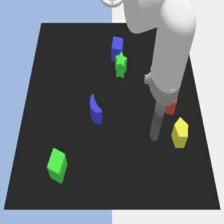

step: 2001/12800   lr: 0.02971   loss: 0.6680
step: 2002/12800   lr: 0.02971   loss: 0.6399
step: 2003/12800   lr: 0.02971   loss: 0.6333
step: 2004/12800   lr: 0.02971   loss: 0.7085
step: 2005/12800   lr: 0.02971   loss: 0.6593
step: 2006/12800   lr: 0.02971   loss: 0.6382
step: 2007/12800   lr: 0.02971   loss: 0.6696
step: 2008/12800   lr: 0.02971   loss: 0.6301
step: 2009/12800   lr: 0.02970   loss: 0.6384
step: 2010/12800   lr: 0.02970   loss: 0.6520
step: 2011/12800   lr: 0.02970   loss: 0.6220
step: 2012/12800   lr: 0.02970   loss: 0.6619
step: 2013/12800   lr: 0.02970   loss: 0.6392
step: 2014/12800   lr: 0.02970   loss: 0.5768
step: 2015/12800   lr: 0.02970   loss: 0.6056
step: 2016/12800   lr: 0.02970   loss: 0.6454
step: 2017/12800   lr: 0.02970   loss: 0.6553
step: 2018/12800   lr: 0.02970   loss: 0.6773
step: 2019/12800   lr: 0.02970   loss: 0.6387
step: 2020/12800   lr: 0.02970   loss: 0.6282
step: 2021/12800   lr: 0.02969   loss: 0.6607
step: 2022/12800   lr: 0.02969   l


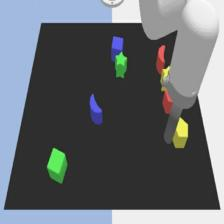
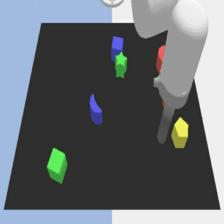
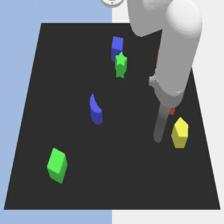
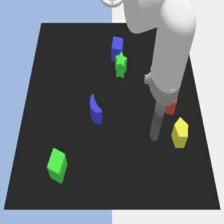

step: 2101/12800   lr: 0.02963   loss: 0.6272
step: 2102/12800   lr: 0.02962   loss: 0.6152
step: 2103/12800   lr: 0.02962   loss: 0.6351
step: 2104/12800   lr: 0.02962   loss: 0.6042
step: 2105/12800   lr: 0.02962   loss: 0.6491
step: 2106/12800   lr: 0.02962   loss: 0.6271
step: 2107/12800   lr: 0.02962   loss: 0.6686
step: 2108/12800   lr: 0.02962   loss: 0.6426
step: 2109/12800   lr: 0.02962   loss: 0.6314
step: 2110/12800   lr: 0.02962   loss: 0.5899
step: 2111/12800   lr: 0.02962   loss: 0.6566
step: 2112/12800   lr: 0.02962   loss: 0.6806
step: 2113/12800   lr: 0.02961   loss: 0.6807
step: 2114/12800   lr: 0.02961   loss: 0.6894
step: 2115/12800   lr: 0.02961   loss: 0.6223
step: 2116/12800   lr: 0.02961   loss: 0.6422
step: 2117/12800   lr: 0.02961   loss: 0.6452
step: 2118/12800   lr: 0.02961   loss: 0.6300
step: 2119/12800   lr: 0.02961   loss: 0.6418
step: 2120/12800   lr: 0.02961   loss: 0.6271
step: 2121/12800   lr: 0.02961   loss: 0.6536
step: 2122/12800   lr: 0.02961   l


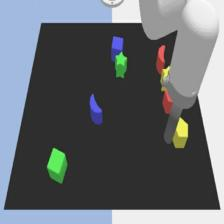
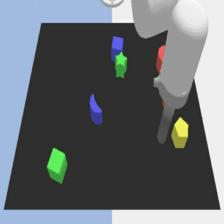
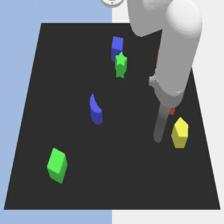
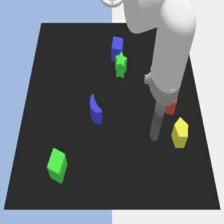

step: 2201/12800   lr: 0.02953   loss: 0.6795
step: 2202/12800   lr: 0.02953   loss: 0.6736
step: 2203/12800   lr: 0.02953   loss: 0.6165
step: 2204/12800   lr: 0.02953   loss: 0.6581
step: 2205/12800   lr: 0.02953   loss: 0.6534
step: 2206/12800   lr: 0.02952   loss: 0.6470
step: 2207/12800   lr: 0.02952   loss: 0.5927
step: 2208/12800   lr: 0.02952   loss: 0.6756
step: 2209/12800   lr: 0.02952   loss: 0.6111
step: 2210/12800   lr: 0.02952   loss: 0.6119
step: 2211/12800   lr: 0.02952   loss: 0.6792
step: 2212/12800   lr: 0.02952   loss: 0.6351
step: 2213/12800   lr: 0.02952   loss: 0.6388
step: 2214/12800   lr: 0.02952   loss: 0.6014
step: 2215/12800   lr: 0.02952   loss: 0.6103
step: 2216/12800   lr: 0.02951   loss: 0.6478
step: 2217/12800   lr: 0.02951   loss: 0.6626
step: 2218/12800   lr: 0.02951   loss: 0.6423
step: 2219/12800   lr: 0.02951   loss: 0.6590
step: 2220/12800   lr: 0.02951   loss: 0.6300
step: 2221/12800   lr: 0.02951   loss: 0.6103
step: 2222/12800   lr: 0.02951   l


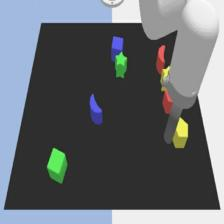
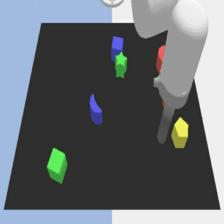
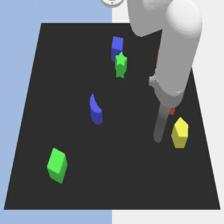
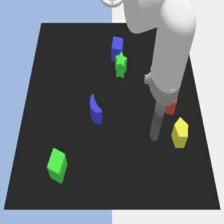

step: 2301/12800   lr: 0.02942   loss: 0.6322
step: 2302/12800   lr: 0.02942   loss: 0.6742
step: 2303/12800   lr: 0.02942   loss: 0.6819
step: 2304/12800   lr: 0.02942   loss: 0.6729
step: 2305/12800   lr: 0.02942   loss: 0.6622
step: 2306/12800   lr: 0.02942   loss: 0.6364
step: 2307/12800   lr: 0.02942   loss: 0.5680
step: 2308/12800   lr: 0.02941   loss: 0.6730
step: 2309/12800   lr: 0.02941   loss: 0.6216
step: 2310/12800   lr: 0.02941   loss: 0.6585
step: 2311/12800   lr: 0.02941   loss: 0.6647
step: 2312/12800   lr: 0.02941   loss: 0.6410
step: 2313/12800   lr: 0.02941   loss: 0.6098
step: 2314/12800   lr: 0.02941   loss: 0.6273
step: 2315/12800   lr: 0.02941   loss: 0.6596
step: 2316/12800   lr: 0.02941   loss: 0.6669
step: 2317/12800   lr: 0.02940   loss: 0.6338
step: 2318/12800   lr: 0.02940   loss: 0.6392
step: 2319/12800   lr: 0.02940   loss: 0.6293
step: 2320/12800   lr: 0.02940   loss: 0.5940
step: 2321/12800   lr: 0.02940   loss: 0.6350
step: 2322/12800   lr: 0.02940   l


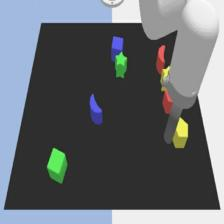
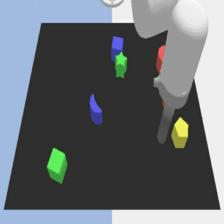
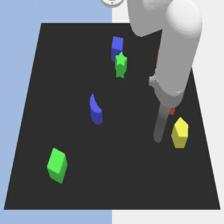
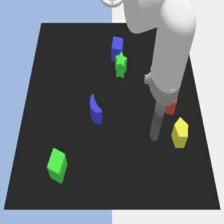

step: 2401/12800   lr: 0.02930   loss: 0.6832
step: 2402/12800   lr: 0.02930   loss: 0.6350
step: 2403/12800   lr: 0.02930   loss: 0.6294
step: 2404/12800   lr: 0.02930   loss: 0.6426
step: 2405/12800   lr: 0.02930   loss: 0.6209
step: 2406/12800   lr: 0.02930   loss: 0.6221
step: 2407/12800   lr: 0.02930   loss: 0.5893
step: 2408/12800   lr: 0.02930   loss: 0.6563
step: 2409/12800   lr: 0.02929   loss: 0.6709
step: 2410/12800   lr: 0.02929   loss: 0.6340
step: 2411/12800   lr: 0.02929   loss: 0.6856
step: 2412/12800   lr: 0.02929   loss: 0.6573
step: 2413/12800   lr: 0.02929   loss: 0.6380
step: 2414/12800   lr: 0.02929   loss: 0.6058
step: 2415/12800   lr: 0.02929   loss: 0.6609
step: 2416/12800   lr: 0.02929   loss: 0.6671
step: 2417/12800   lr: 0.02928   loss: 0.6566
step: 2418/12800   lr: 0.02928   loss: 0.6158
step: 2419/12800   lr: 0.02928   loss: 0.6226
step: 2420/12800   lr: 0.02928   loss: 0.6418
step: 2421/12800   lr: 0.02928   loss: 0.5708
step: 2422/12800   lr: 0.02928   l


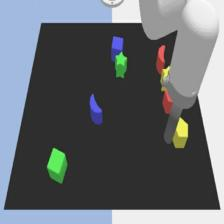
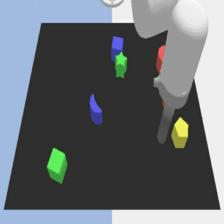
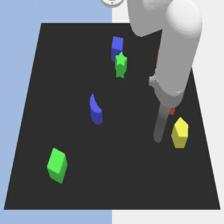
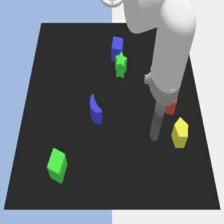

step: 2501/12800   lr: 0.02918   loss: 0.6127
step: 2502/12800   lr: 0.02917   loss: 0.6487
step: 2503/12800   lr: 0.02917   loss: 0.6424
step: 2504/12800   lr: 0.02917   loss: 0.6084
step: 2505/12800   lr: 0.02917   loss: 0.6751
step: 2506/12800   lr: 0.02917   loss: 0.5768
step: 2507/12800   lr: 0.02917   loss: 0.6060
step: 2508/12800   lr: 0.02917   loss: 0.6529
step: 2509/12800   lr: 0.02917   loss: 0.6903
step: 2510/12800   lr: 0.02916   loss: 0.6221
step: 2511/12800   lr: 0.02916   loss: 0.6075
step: 2512/12800   lr: 0.02916   loss: 0.6351
step: 2513/12800   lr: 0.02916   loss: 0.6628
step: 2514/12800   lr: 0.02916   loss: 0.6192
step: 2515/12800   lr: 0.02916   loss: 0.6314
step: 2516/12800   lr: 0.02916   loss: 0.6588
step: 2517/12800   lr: 0.02915   loss: 0.6184
step: 2518/12800   lr: 0.02915   loss: 0.6099
step: 2519/12800   lr: 0.02915   loss: 0.6073
step: 2520/12800   lr: 0.02915   loss: 0.6272
step: 2521/12800   lr: 0.02915   loss: 0.6812
step: 2522/12800   lr: 0.02915   l


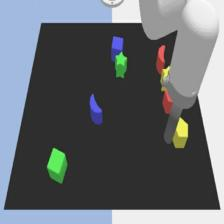
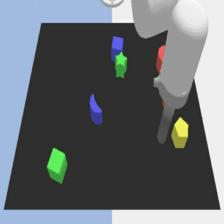
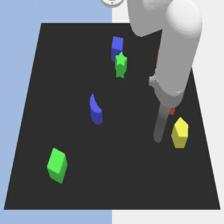
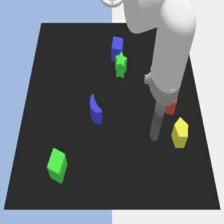

step: 2601/12800   lr: 0.02904   loss: 0.6519
step: 2602/12800   lr: 0.02904   loss: 0.6176
step: 2603/12800   lr: 0.02903   loss: 0.6062
step: 2604/12800   lr: 0.02903   loss: 0.6793
step: 2605/12800   lr: 0.02903   loss: 0.5741
step: 2606/12800   lr: 0.02903   loss: 0.6726
step: 2607/12800   lr: 0.02903   loss: 0.6028
step: 2608/12800   lr: 0.02903   loss: 0.6350
step: 2609/12800   lr: 0.02903   loss: 0.5742
step: 2610/12800   lr: 0.02902   loss: 0.6527
step: 2611/12800   lr: 0.02902   loss: 0.6547
step: 2612/12800   lr: 0.02902   loss: 0.6170
step: 2613/12800   lr: 0.02902   loss: 0.6360
step: 2614/12800   lr: 0.02902   loss: 0.6110
step: 2615/12800   lr: 0.02902   loss: 0.6424
step: 2616/12800   lr: 0.02902   loss: 0.6482
step: 2617/12800   lr: 0.02901   loss: 0.6376
step: 2618/12800   lr: 0.02901   loss: 0.6520
step: 2619/12800   lr: 0.02901   loss: 0.6407
step: 2620/12800   lr: 0.02901   loss: 0.6069
step: 2621/12800   lr: 0.02901   loss: 0.6643
step: 2622/12800   lr: 0.02901   l


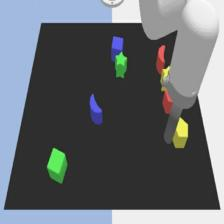
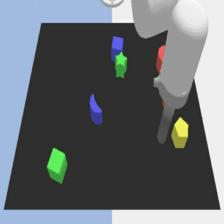
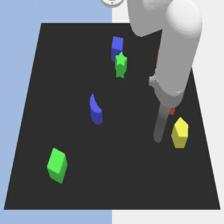
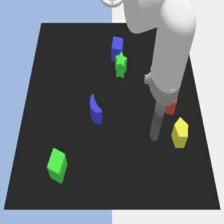

step: 2701/12800   lr: 0.02889   loss: 0.6362
step: 2702/12800   lr: 0.02889   loss: 0.6736
step: 2703/12800   lr: 0.02888   loss: 0.6417
step: 2704/12800   lr: 0.02888   loss: 0.6634
step: 2705/12800   lr: 0.02888   loss: 0.6431
step: 2706/12800   lr: 0.02888   loss: 0.6254
step: 2707/12800   lr: 0.02888   loss: 0.6619
step: 2708/12800   lr: 0.02888   loss: 0.6438
step: 2709/12800   lr: 0.02888   loss: 0.6556
step: 2710/12800   lr: 0.02887   loss: 0.6484
step: 2711/12800   lr: 0.02887   loss: 0.5828
step: 2712/12800   lr: 0.02887   loss: 0.6828
step: 2713/12800   lr: 0.02887   loss: 0.6645
step: 2714/12800   lr: 0.02887   loss: 0.6520
step: 2715/12800   lr: 0.02887   loss: 0.6622
step: 2716/12800   lr: 0.02886   loss: 0.6175
step: 2717/12800   lr: 0.02886   loss: 0.6565
step: 2718/12800   lr: 0.02886   loss: 0.6645
step: 2719/12800   lr: 0.02886   loss: 0.6375
step: 2720/12800   lr: 0.02886   loss: 0.5637
step: 2721/12800   lr: 0.02886   loss: 0.6130
step: 2722/12800   lr: 0.02886   l


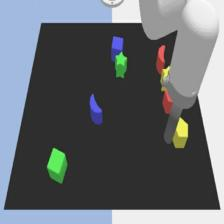
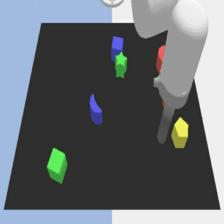
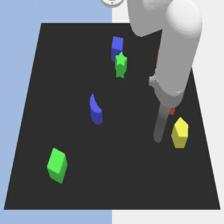
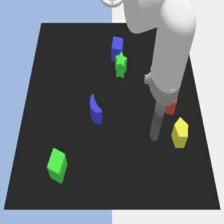

step: 2801/12800   lr: 0.02873   loss: 0.6911
step: 2802/12800   lr: 0.02873   loss: 0.6256
step: 2803/12800   lr: 0.02872   loss: 0.5583
step: 2804/12800   lr: 0.02872   loss: 0.5525
step: 2805/12800   lr: 0.02872   loss: 0.5677
step: 2806/12800   lr: 0.02872   loss: 0.6276
step: 2807/12800   lr: 0.02872   loss: 0.6740
step: 2808/12800   lr: 0.02872   loss: 0.6382
step: 2809/12800   lr: 0.02872   loss: 0.6150
step: 2810/12800   lr: 0.02871   loss: 0.5730
step: 2811/12800   lr: 0.02871   loss: 0.6575
step: 2812/12800   lr: 0.02871   loss: 0.6885
step: 2813/12800   lr: 0.02871   loss: 0.5941
step: 2814/12800   lr: 0.02871   loss: 0.6286
step: 2815/12800   lr: 0.02871   loss: 0.5824
step: 2816/12800   lr: 0.02870   loss: 0.6091
step: 2817/12800   lr: 0.02870   loss: 0.6376
step: 2818/12800   lr: 0.02870   loss: 0.6286
step: 2819/12800   lr: 0.02870   loss: 0.5769
step: 2820/12800   lr: 0.02870   loss: 0.6303
step: 2821/12800   lr: 0.02870   loss: 0.5452
step: 2822/12800   lr: 0.02869   l


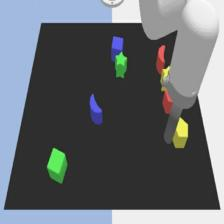
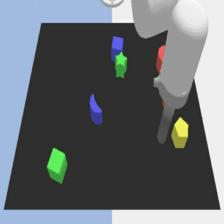
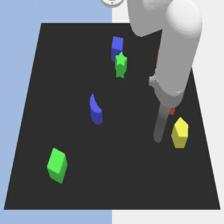
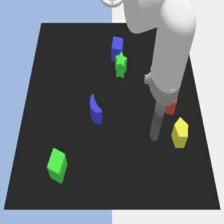

step: 2901/12800   lr: 0.02856   loss: 0.6134
step: 2902/12800   lr: 0.02856   loss: 0.6593
step: 2903/12800   lr: 0.02855   loss: 0.5690
step: 2904/12800   lr: 0.02855   loss: 0.5348
step: 2905/12800   lr: 0.02855   loss: 0.6370
step: 2906/12800   lr: 0.02855   loss: 0.6399
step: 2907/12800   lr: 0.02855   loss: 0.6283
step: 2908/12800   lr: 0.02855   loss: 0.6740
step: 2909/12800   lr: 0.02854   loss: 0.6438
step: 2910/12800   lr: 0.02854   loss: 0.6354
step: 2911/12800   lr: 0.02854   loss: 0.6465
step: 2912/12800   lr: 0.02854   loss: 0.6510
step: 2913/12800   lr: 0.02854   loss: 0.6045
step: 2914/12800   lr: 0.02854   loss: 0.6484
step: 2915/12800   lr: 0.02853   loss: 0.6409
step: 2916/12800   lr: 0.02853   loss: 0.6429
step: 2917/12800   lr: 0.02853   loss: 0.6646
step: 2918/12800   lr: 0.02853   loss: 0.5580
step: 2919/12800   lr: 0.02853   loss: 0.6403
step: 2920/12800   lr: 0.02852   loss: 0.6222
step: 2921/12800   lr: 0.02852   loss: 0.5995
step: 2922/12800   lr: 0.02852   l


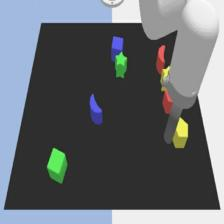
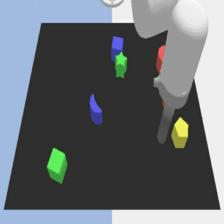
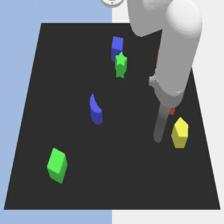
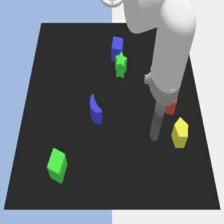

step: 3001/12800   lr: 0.02838   loss: 0.6139
step: 3002/12800   lr: 0.02838   loss: 0.6201
step: 3003/12800   lr: 0.02837   loss: 0.6010
step: 3004/12800   lr: 0.02837   loss: 0.6667
step: 3005/12800   lr: 0.02837   loss: 0.6266
step: 3006/12800   lr: 0.02837   loss: 0.6465
step: 3007/12800   lr: 0.02837   loss: 0.7055
step: 3008/12800   lr: 0.02837   loss: 0.6405
step: 3009/12800   lr: 0.02836   loss: 0.6011
step: 3010/12800   lr: 0.02836   loss: 0.6476
step: 3011/12800   lr: 0.02836   loss: 0.6446
step: 3012/12800   lr: 0.02836   loss: 0.7064
step: 3013/12800   lr: 0.02836   loss: 0.6642
step: 3014/12800   lr: 0.02835   loss: 0.6363
step: 3015/12800   lr: 0.02835   loss: 0.6413
step: 3016/12800   lr: 0.02835   loss: 0.6195
step: 3017/12800   lr: 0.02835   loss: 0.5555
step: 3018/12800   lr: 0.02835   loss: 0.5952
step: 3019/12800   lr: 0.02834   loss: 0.6554
step: 3020/12800   lr: 0.02834   loss: 0.6237
step: 3021/12800   lr: 0.02834   loss: 0.6280
step: 3022/12800   lr: 0.02834   l


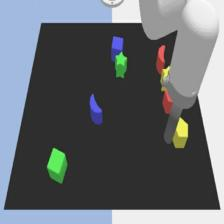
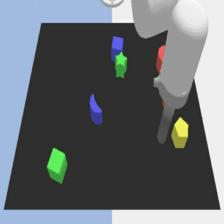
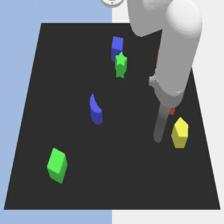
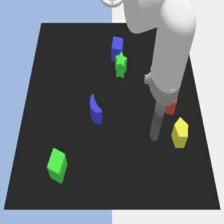

step: 3101/12800   lr: 0.02819   loss: 0.6600
step: 3102/12800   lr: 0.02819   loss: 0.5955
step: 3103/12800   lr: 0.02818   loss: 0.6589
step: 3104/12800   lr: 0.02818   loss: 0.6143
step: 3105/12800   lr: 0.02818   loss: 0.6283
step: 3106/12800   lr: 0.02818   loss: 0.6417
step: 3107/12800   lr: 0.02818   loss: 0.6340
step: 3108/12800   lr: 0.02817   loss: 0.6505
step: 3109/12800   lr: 0.02817   loss: 0.6453
step: 3110/12800   lr: 0.02817   loss: 0.6001
step: 3111/12800   lr: 0.02817   loss: 0.6306
step: 3112/12800   lr: 0.02817   loss: 0.6034
step: 3113/12800   lr: 0.02816   loss: 0.6281
step: 3114/12800   lr: 0.02816   loss: 0.5878
step: 3115/12800   lr: 0.02816   loss: 0.6685
step: 3116/12800   lr: 0.02816   loss: 0.6100
step: 3117/12800   lr: 0.02816   loss: 0.6557
step: 3118/12800   lr: 0.02816   loss: 0.6156
step: 3119/12800   lr: 0.02815   loss: 0.5833
step: 3120/12800   lr: 0.02815   loss: 0.6444
step: 3121/12800   lr: 0.02815   loss: 0.6600
step: 3122/12800   lr: 0.02815   l


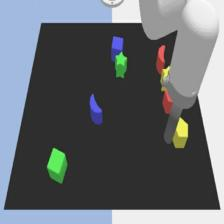
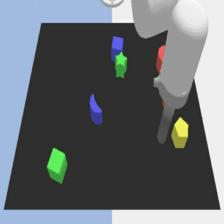
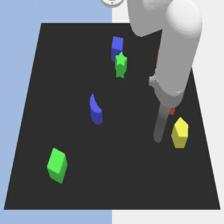
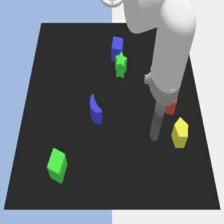

step: 3201/12800   lr: 0.02799   loss: 0.5849
step: 3202/12800   lr: 0.02799   loss: 0.6095
step: 3203/12800   lr: 0.02798   loss: 0.6537
step: 3204/12800   lr: 0.02798   loss: 0.6788
step: 3205/12800   lr: 0.02798   loss: 0.6175
step: 3206/12800   lr: 0.02798   loss: 0.6130
step: 3207/12800   lr: 0.02798   loss: 0.6766
step: 3208/12800   lr: 0.02797   loss: 0.6477
step: 3209/12800   lr: 0.02797   loss: 0.5950
step: 3210/12800   lr: 0.02797   loss: 0.6533
step: 3211/12800   lr: 0.02797   loss: 0.6375
step: 3212/12800   lr: 0.02797   loss: 0.6581
step: 3213/12800   lr: 0.02796   loss: 0.6309
step: 3214/12800   lr: 0.02796   loss: 0.6271
step: 3215/12800   lr: 0.02796   loss: 0.6483
step: 3216/12800   lr: 0.02796   loss: 0.6164
step: 3217/12800   lr: 0.02796   loss: 0.5921
step: 3218/12800   lr: 0.02795   loss: 0.6851
step: 3219/12800   lr: 0.02795   loss: 0.6275
step: 3220/12800   lr: 0.02795   loss: 0.6084
step: 3221/12800   lr: 0.02795   loss: 0.6126
step: 3222/12800   lr: 0.02795   l


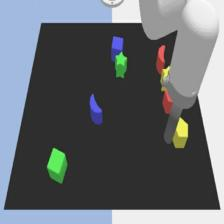
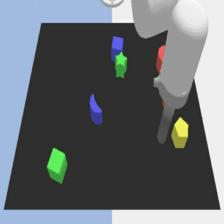
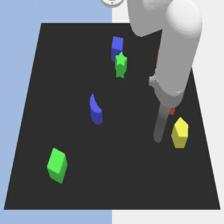
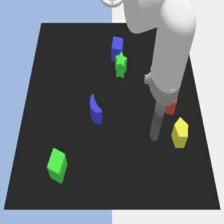

step: 3301/12800   lr: 0.02778   loss: 0.6342
step: 3302/12800   lr: 0.02778   loss: 0.6404
step: 3303/12800   lr: 0.02777   loss: 0.5944
step: 3304/12800   lr: 0.02777   loss: 0.7001
step: 3305/12800   lr: 0.02777   loss: 0.6005
step: 3306/12800   lr: 0.02777   loss: 0.6228
step: 3307/12800   lr: 0.02777   loss: 0.5476
step: 3308/12800   lr: 0.02776   loss: 0.6467
step: 3309/12800   lr: 0.02776   loss: 0.6545
step: 3310/12800   lr: 0.02776   loss: 0.6032
step: 3311/12800   lr: 0.02776   loss: 0.6473
step: 3312/12800   lr: 0.02776   loss: 0.6530
step: 3313/12800   lr: 0.02775   loss: 0.6321
step: 3314/12800   lr: 0.02775   loss: 0.6324
step: 3315/12800   lr: 0.02775   loss: 0.5870
step: 3316/12800   lr: 0.02775   loss: 0.6259
step: 3317/12800   lr: 0.02774   loss: 0.6850
step: 3318/12800   lr: 0.02774   loss: 0.6292
step: 3319/12800   lr: 0.02774   loss: 0.6549
step: 3320/12800   lr: 0.02774   loss: 0.6269
step: 3321/12800   lr: 0.02774   loss: 0.5978
step: 3322/12800   lr: 0.02773   l


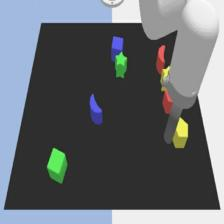
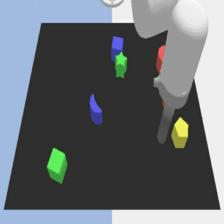
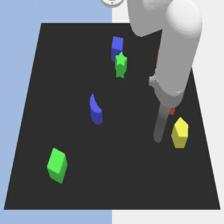
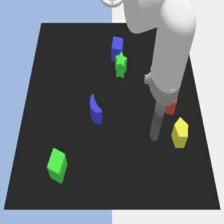

step: 3401/12800   lr: 0.02756   loss: 0.6127
step: 3402/12800   lr: 0.02756   loss: 0.6536
step: 3403/12800   lr: 0.02756   loss: 0.6607
step: 3404/12800   lr: 0.02755   loss: 0.6620
step: 3405/12800   lr: 0.02755   loss: 0.6447
step: 3406/12800   lr: 0.02755   loss: 0.6401
step: 3407/12800   lr: 0.02755   loss: 0.6552
step: 3408/12800   lr: 0.02754   loss: 0.5969
step: 3409/12800   lr: 0.02754   loss: 0.6544
step: 3410/12800   lr: 0.02754   loss: 0.6716
step: 3411/12800   lr: 0.02754   loss: 0.6642
step: 3412/12800   lr: 0.02754   loss: 0.6166
step: 3413/12800   lr: 0.02753   loss: 0.6059
step: 3414/12800   lr: 0.02753   loss: 0.6586
step: 3415/12800   lr: 0.02753   loss: 0.6019
step: 3416/12800   lr: 0.02753   loss: 0.6199
step: 3417/12800   lr: 0.02752   loss: 0.6733
step: 3418/12800   lr: 0.02752   loss: 0.6121
step: 3419/12800   lr: 0.02752   loss: 0.6481
step: 3420/12800   lr: 0.02752   loss: 0.6469
step: 3421/12800   lr: 0.02752   loss: 0.6411
step: 3422/12800   lr: 0.02751   l


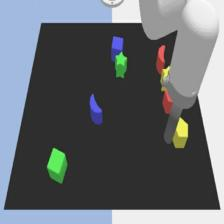
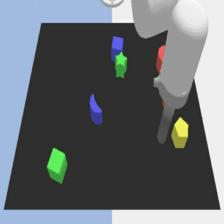
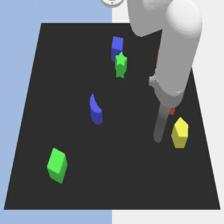
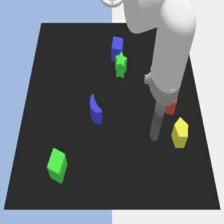

step: 3501/12800   lr: 0.02733   loss: 0.6179
step: 3502/12800   lr: 0.02733   loss: 0.5997
step: 3503/12800   lr: 0.02733   loss: 0.6560
step: 3504/12800   lr: 0.02733   loss: 0.6500
step: 3505/12800   lr: 0.02732   loss: 0.5474
step: 3506/12800   lr: 0.02732   loss: 0.6420
step: 3507/12800   lr: 0.02732   loss: 0.6378
step: 3508/12800   lr: 0.02732   loss: 0.6143
step: 3509/12800   lr: 0.02731   loss: 0.6447
step: 3510/12800   lr: 0.02731   loss: 0.6845
step: 3511/12800   lr: 0.02731   loss: 0.6757
step: 3512/12800   lr: 0.02731   loss: 0.5887
step: 3513/12800   lr: 0.02730   loss: 0.6390
step: 3514/12800   lr: 0.02730   loss: 0.6662
step: 3515/12800   lr: 0.02730   loss: 0.6163
step: 3516/12800   lr: 0.02730   loss: 0.6638
step: 3517/12800   lr: 0.02729   loss: 0.5690
step: 3518/12800   lr: 0.02729   loss: 0.6380
step: 3519/12800   lr: 0.02729   loss: 0.6459
step: 3520/12800   lr: 0.02729   loss: 0.6241
step: 3521/12800   lr: 0.02729   loss: 0.6441
step: 3522/12800   lr: 0.02728   l


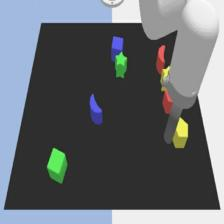
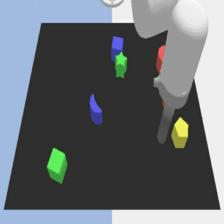
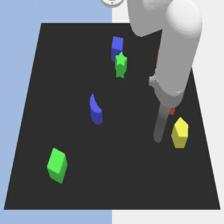
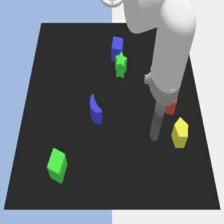

step: 3601/12800   lr: 0.02709   loss: 0.6004
step: 3602/12800   lr: 0.02709   loss: 0.6378
step: 3603/12800   lr: 0.02709   loss: 0.6519
step: 3604/12800   lr: 0.02709   loss: 0.5731
step: 3605/12800   lr: 0.02709   loss: 0.6259
step: 3606/12800   lr: 0.02708   loss: 0.6040
step: 3607/12800   lr: 0.02708   loss: 0.6406
step: 3608/12800   lr: 0.02708   loss: 0.6450
step: 3609/12800   lr: 0.02708   loss: 0.6550
step: 3610/12800   lr: 0.02707   loss: 0.6391
step: 3611/12800   lr: 0.02707   loss: 0.6451
step: 3612/12800   lr: 0.02707   loss: 0.6272
step: 3613/12800   lr: 0.02707   loss: 0.6144
step: 3614/12800   lr: 0.02706   loss: 0.6829
step: 3615/12800   lr: 0.02706   loss: 0.6047
step: 3616/12800   lr: 0.02706   loss: 0.6719
step: 3617/12800   lr: 0.02706   loss: 0.6809
step: 3618/12800   lr: 0.02705   loss: 0.6519
step: 3619/12800   lr: 0.02705   loss: 0.6294
step: 3620/12800   lr: 0.02705   loss: 0.6540
step: 3621/12800   lr: 0.02705   loss: 0.6569
step: 3622/12800   lr: 0.02704   l


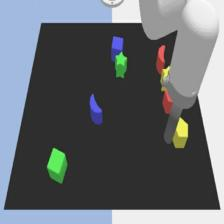
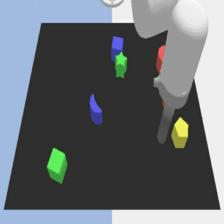
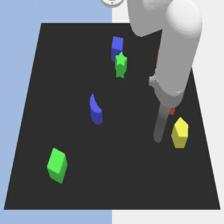
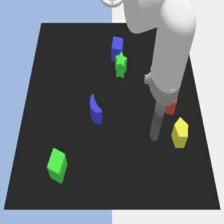

step: 3701/12800   lr: 0.02685   loss: 0.6122
step: 3702/12800   lr: 0.02685   loss: 0.5789
step: 3703/12800   lr: 0.02684   loss: 0.6046
step: 3704/12800   lr: 0.02684   loss: 0.6630
step: 3705/12800   lr: 0.02684   loss: 0.6276
step: 3706/12800   lr: 0.02684   loss: 0.6571
step: 3707/12800   lr: 0.02683   loss: 0.6502
step: 3708/12800   lr: 0.02683   loss: 0.6178
step: 3709/12800   lr: 0.02683   loss: 0.6571
step: 3710/12800   lr: 0.02683   loss: 0.6545
step: 3711/12800   lr: 0.02682   loss: 0.6447
step: 3712/12800   lr: 0.02682   loss: 0.6523
step: 3713/12800   lr: 0.02682   loss: 0.6548
step: 3714/12800   lr: 0.02682   loss: 0.6774
step: 3715/12800   lr: 0.02681   loss: 0.6127
step: 3716/12800   lr: 0.02681   loss: 0.6427
step: 3717/12800   lr: 0.02681   loss: 0.6036
step: 3718/12800   lr: 0.02681   loss: 0.6848
step: 3719/12800   lr: 0.02680   loss: 0.5672
step: 3720/12800   lr: 0.02680   loss: 0.5858
step: 3721/12800   lr: 0.02680   loss: 0.6560
step: 3722/12800   lr: 0.02680   l


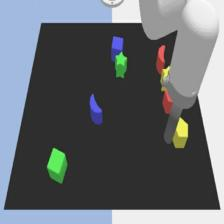
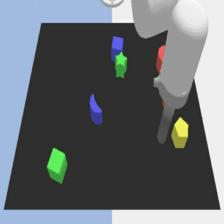
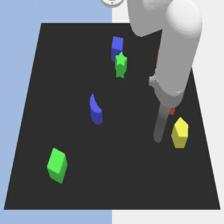
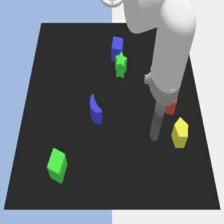

step: 3801/12800   lr: 0.02659   loss: 0.6414
step: 3802/12800   lr: 0.02659   loss: 0.6447
step: 3803/12800   lr: 0.02659   loss: 0.6155
step: 3804/12800   lr: 0.02659   loss: 0.6209
step: 3805/12800   lr: 0.02658   loss: 0.5537
step: 3806/12800   lr: 0.02658   loss: 0.6594
step: 3807/12800   lr: 0.02658   loss: 0.5647
step: 3808/12800   lr: 0.02657   loss: 0.6397
step: 3809/12800   lr: 0.02657   loss: 0.5967
step: 3810/12800   lr: 0.02657   loss: 0.6442
step: 3811/12800   lr: 0.02657   loss: 0.6339
step: 3812/12800   lr: 0.02656   loss: 0.5996
step: 3813/12800   lr: 0.02656   loss: 0.6101
step: 3814/12800   lr: 0.02656   loss: 0.5744
step: 3815/12800   lr: 0.02656   loss: 0.6450
step: 3816/12800   lr: 0.02655   loss: 0.6243
step: 3817/12800   lr: 0.02655   loss: 0.6347
step: 3818/12800   lr: 0.02655   loss: 0.5735
step: 3819/12800   lr: 0.02655   loss: 0.6129
step: 3820/12800   lr: 0.02654   loss: 0.6383
step: 3821/12800   lr: 0.02654   loss: 0.6313
step: 3822/12800   lr: 0.02654   l


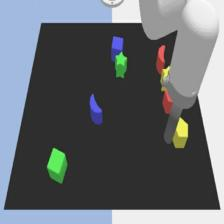
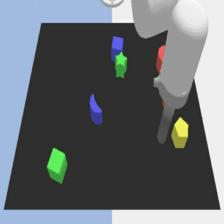
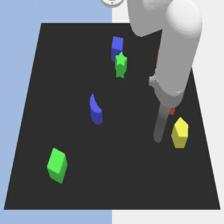
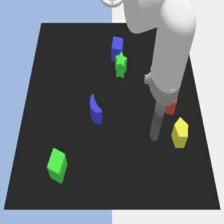

step: 3901/12800   lr: 0.02633   loss: 0.6567
step: 3902/12800   lr: 0.02633   loss: 0.5409
step: 3903/12800   lr: 0.02632   loss: 0.6403
step: 3904/12800   lr: 0.02632   loss: 0.5901
step: 3905/12800   lr: 0.02632   loss: 0.6503
step: 3906/12800   lr: 0.02632   loss: 0.6399
step: 3907/12800   lr: 0.02631   loss: 0.6403
step: 3908/12800   lr: 0.02631   loss: 0.5950
step: 3909/12800   lr: 0.02631   loss: 0.6703
step: 3910/12800   lr: 0.02631   loss: 0.5864
step: 3911/12800   lr: 0.02630   loss: 0.6741
step: 3912/12800   lr: 0.02630   loss: 0.6439
step: 3913/12800   lr: 0.02630   loss: 0.5905
step: 3914/12800   lr: 0.02629   loss: 0.6552
step: 3915/12800   lr: 0.02629   loss: 0.6288
step: 3916/12800   lr: 0.02629   loss: 0.6065
step: 3917/12800   lr: 0.02629   loss: 0.6419
step: 3918/12800   lr: 0.02628   loss: 0.6585
step: 3919/12800   lr: 0.02628   loss: 0.6366
step: 3920/12800   lr: 0.02628   loss: 0.6592
step: 3921/12800   lr: 0.02628   loss: 0.6491
step: 3922/12800   lr: 0.02627   l


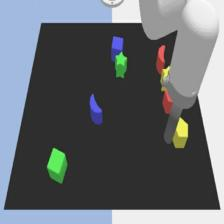
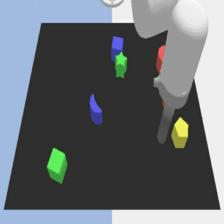
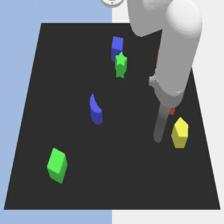
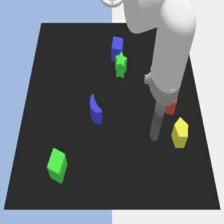

step: 4001/12800   lr: 0.02606   loss: 0.5994
step: 4002/12800   lr: 0.02605   loss: 0.5490
step: 4003/12800   lr: 0.02605   loss: 0.6567
step: 4004/12800   lr: 0.02605   loss: 0.6827
step: 4005/12800   lr: 0.02605   loss: 0.6397
step: 4006/12800   lr: 0.02604   loss: 0.5906
step: 4007/12800   lr: 0.02604   loss: 0.6304
step: 4008/12800   lr: 0.02604   loss: 0.5526
step: 4009/12800   lr: 0.02603   loss: 0.6087
step: 4010/12800   lr: 0.02603   loss: 0.5651
step: 4011/12800   lr: 0.02603   loss: 0.6393
step: 4012/12800   lr: 0.02603   loss: 0.6516
step: 4013/12800   lr: 0.02602   loss: 0.6516
step: 4014/12800   lr: 0.02602   loss: 0.6134
step: 4015/12800   lr: 0.02602   loss: 0.6510
step: 4016/12800   lr: 0.02602   loss: 0.5635
step: 4017/12800   lr: 0.02601   loss: 0.6784
step: 4018/12800   lr: 0.02601   loss: 0.6625
step: 4019/12800   lr: 0.02601   loss: 0.6204
step: 4020/12800   lr: 0.02600   loss: 0.5372
step: 4021/12800   lr: 0.02600   loss: 0.6024
step: 4022/12800   lr: 0.02600   l


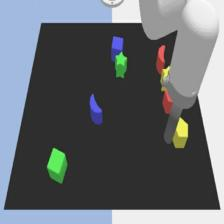
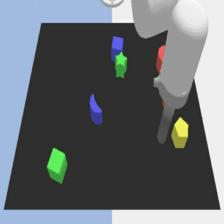
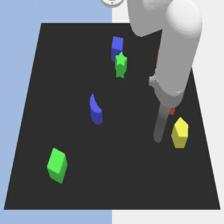
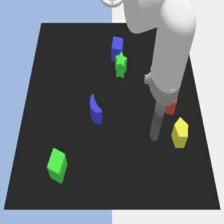

step: 4101/12800   lr: 0.02578   loss: 0.7428
step: 4102/12800   lr: 0.02577   loss: 0.6610
step: 4103/12800   lr: 0.02577   loss: 0.6478
step: 4104/12800   lr: 0.02577   loss: 0.5766
step: 4105/12800   lr: 0.02577   loss: 0.6501
step: 4106/12800   lr: 0.02576   loss: 0.6195
step: 4107/12800   lr: 0.02576   loss: 0.5779
step: 4108/12800   lr: 0.02576   loss: 0.6644
step: 4109/12800   lr: 0.02575   loss: 0.6444
step: 4110/12800   lr: 0.02575   loss: 0.6210
step: 4111/12800   lr: 0.02575   loss: 0.6301
step: 4112/12800   lr: 0.02575   loss: 0.5842
step: 4113/12800   lr: 0.02574   loss: 0.6140
step: 4114/12800   lr: 0.02574   loss: 0.6614
step: 4115/12800   lr: 0.02574   loss: 0.6538
step: 4116/12800   lr: 0.02573   loss: 0.6040
step: 4117/12800   lr: 0.02573   loss: 0.6550
step: 4118/12800   lr: 0.02573   loss: 0.5328
step: 4119/12800   lr: 0.02573   loss: 0.6308
step: 4120/12800   lr: 0.02572   loss: 0.6253
step: 4121/12800   lr: 0.02572   loss: 0.6075
step: 4122/12800   lr: 0.02572   l


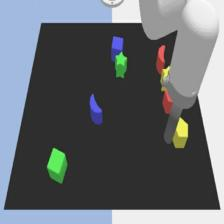
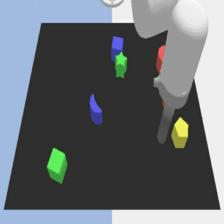
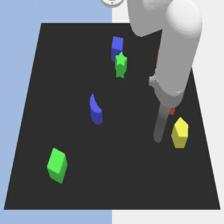
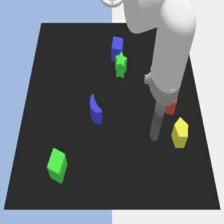

step: 4201/12800   lr: 0.02549   loss: 0.6182
step: 4202/12800   lr: 0.02549   loss: 0.6397
step: 4203/12800   lr: 0.02548   loss: 0.5942
step: 4204/12800   lr: 0.02548   loss: 0.6733
step: 4205/12800   lr: 0.02548   loss: 0.6068
step: 4206/12800   lr: 0.02547   loss: 0.6070
step: 4207/12800   lr: 0.02547   loss: 0.5726
step: 4208/12800   lr: 0.02547   loss: 0.6099
step: 4209/12800   lr: 0.02546   loss: 0.6075
step: 4210/12800   lr: 0.02546   loss: 0.6160
step: 4211/12800   lr: 0.02546   loss: 0.6395
step: 4212/12800   lr: 0.02546   loss: 0.6468
step: 4213/12800   lr: 0.02545   loss: 0.5721
step: 4214/12800   lr: 0.02545   loss: 0.6593
step: 4215/12800   lr: 0.02545   loss: 0.6333
step: 4216/12800   lr: 0.02544   loss: 0.6526
step: 4217/12800   lr: 0.02544   loss: 0.5737
step: 4218/12800   lr: 0.02544   loss: 0.6802
step: 4219/12800   lr: 0.02544   loss: 0.6277
step: 4220/12800   lr: 0.02543   loss: 0.6239
step: 4221/12800   lr: 0.02543   loss: 0.6071
step: 4222/12800   lr: 0.02543   l


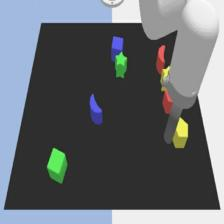
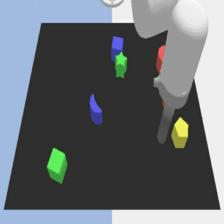
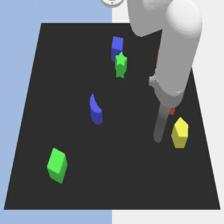
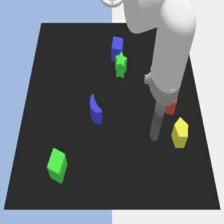

step: 4301/12800   lr: 0.02519   loss: 0.6904
step: 4302/12800   lr: 0.02519   loss: 0.6454
step: 4303/12800   lr: 0.02519   loss: 0.6098
step: 4304/12800   lr: 0.02518   loss: 0.5918
step: 4305/12800   lr: 0.02518   loss: 0.5746
step: 4306/12800   lr: 0.02518   loss: 0.6448
step: 4307/12800   lr: 0.02517   loss: 0.6643
step: 4308/12800   lr: 0.02517   loss: 0.6241
step: 4309/12800   lr: 0.02517   loss: 0.6549
step: 4310/12800   lr: 0.02516   loss: 0.6589
step: 4311/12800   lr: 0.02516   loss: 0.6670
step: 4312/12800   lr: 0.02516   loss: 0.6358
step: 4313/12800   lr: 0.02516   loss: 0.6483
step: 4314/12800   lr: 0.02515   loss: 0.6724
step: 4315/12800   lr: 0.02515   loss: 0.6102
step: 4316/12800   lr: 0.02515   loss: 0.6064
step: 4317/12800   lr: 0.02514   loss: 0.6258
step: 4318/12800   lr: 0.02514   loss: 0.6327
step: 4319/12800   lr: 0.02514   loss: 0.5900
step: 4320/12800   lr: 0.02513   loss: 0.6239
step: 4321/12800   lr: 0.02513   loss: 0.5813
step: 4322/12800   lr: 0.02513   l


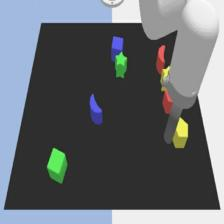
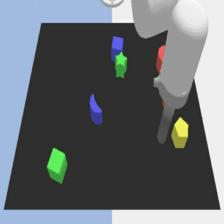
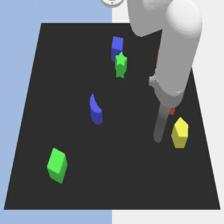
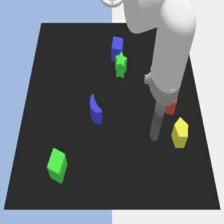

step: 4401/12800   lr: 0.02489   loss: 0.6632
step: 4402/12800   lr: 0.02488   loss: 0.6363
step: 4403/12800   lr: 0.02488   loss: 0.5879
step: 4404/12800   lr: 0.02488   loss: 0.6119
step: 4405/12800   lr: 0.02488   loss: 0.6355
step: 4406/12800   lr: 0.02487   loss: 0.5956
step: 4407/12800   lr: 0.02487   loss: 0.6033
step: 4408/12800   lr: 0.02487   loss: 0.6640
step: 4409/12800   lr: 0.02486   loss: 0.6498
step: 4410/12800   lr: 0.02486   loss: 0.6547
step: 4411/12800   lr: 0.02486   loss: 0.6432
step: 4412/12800   lr: 0.02485   loss: 0.6419
step: 4413/12800   lr: 0.02485   loss: 0.6805
step: 4414/12800   lr: 0.02485   loss: 0.6125
step: 4415/12800   lr: 0.02484   loss: 0.6232
step: 4416/12800   lr: 0.02484   loss: 0.6196
step: 4417/12800   lr: 0.02484   loss: 0.6124
step: 4418/12800   lr: 0.02484   loss: 0.6250
step: 4419/12800   lr: 0.02483   loss: 0.6613
step: 4420/12800   lr: 0.02483   loss: 0.5931
step: 4421/12800   lr: 0.02483   loss: 0.5370
step: 4422/12800   lr: 0.02482   l


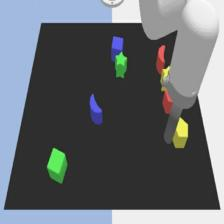
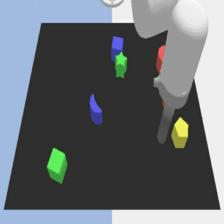
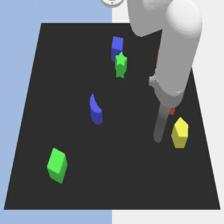
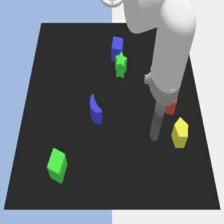

step: 4501/12800   lr: 0.02458   loss: 0.6637
step: 4502/12800   lr: 0.02457   loss: 0.6179
step: 4503/12800   lr: 0.02457   loss: 0.6509
step: 4504/12800   lr: 0.02457   loss: 0.6577
step: 4505/12800   lr: 0.02456   loss: 0.6434
step: 4506/12800   lr: 0.02456   loss: 0.6754
step: 4507/12800   lr: 0.02456   loss: 0.6538
step: 4508/12800   lr: 0.02455   loss: 0.6462
step: 4509/12800   lr: 0.02455   loss: 0.6038
step: 4510/12800   lr: 0.02455   loss: 0.6142
step: 4511/12800   lr: 0.02455   loss: 0.6076
step: 4512/12800   lr: 0.02454   loss: 0.5445
step: 4513/12800   lr: 0.02454   loss: 0.6464
step: 4514/12800   lr: 0.02454   loss: 0.5711
step: 4515/12800   lr: 0.02453   loss: 0.6282
step: 4516/12800   lr: 0.02453   loss: 0.6481
step: 4517/12800   lr: 0.02453   loss: 0.6404
step: 4518/12800   lr: 0.02452   loss: 0.6276
step: 4519/12800   lr: 0.02452   loss: 0.6101
step: 4520/12800   lr: 0.02452   loss: 0.6324
step: 4521/12800   lr: 0.02451   loss: 0.5944
step: 4522/12800   lr: 0.02451   l


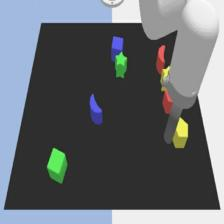
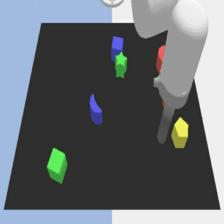
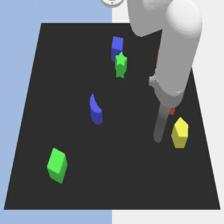
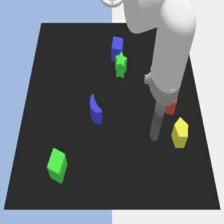

step: 4601/12800   lr: 0.02426   loss: 0.5664
step: 4602/12800   lr: 0.02426   loss: 0.6338
step: 4603/12800   lr: 0.02425   loss: 0.5878
step: 4604/12800   lr: 0.02425   loss: 0.6285
step: 4605/12800   lr: 0.02425   loss: 0.6347
step: 4606/12800   lr: 0.02424   loss: 0.5810
step: 4607/12800   lr: 0.02424   loss: 0.6551
step: 4608/12800   lr: 0.02424   loss: 0.6595
step: 4609/12800   lr: 0.02423   loss: 0.6290
step: 4610/12800   lr: 0.02423   loss: 0.5733
step: 4611/12800   lr: 0.02423   loss: 0.5971
step: 4612/12800   lr: 0.02422   loss: 0.6047
step: 4613/12800   lr: 0.02422   loss: 0.6216
step: 4614/12800   lr: 0.02422   loss: 0.6293
step: 4615/12800   lr: 0.02421   loss: 0.6473
step: 4616/12800   lr: 0.02421   loss: 0.5818
step: 4617/12800   lr: 0.02421   loss: 0.6464
step: 4618/12800   lr: 0.02420   loss: 0.6593
step: 4619/12800   lr: 0.02420   loss: 0.6412
step: 4620/12800   lr: 0.02420   loss: 0.6791
step: 4621/12800   lr: 0.02419   loss: 0.5752
step: 4622/12800   lr: 0.02419   l


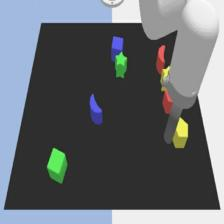
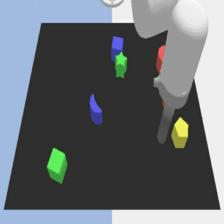
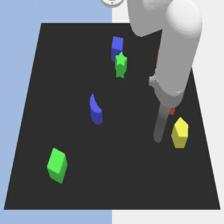
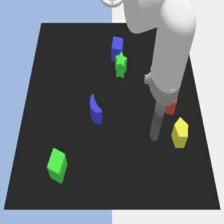

step: 4701/12800   lr: 0.02393   loss: 0.6037
step: 4702/12800   lr: 0.02393   loss: 0.5904
step: 4703/12800   lr: 0.02393   loss: 0.6682
step: 4704/12800   lr: 0.02392   loss: 0.5618
step: 4705/12800   lr: 0.02392   loss: 0.6405
step: 4706/12800   lr: 0.02392   loss: 0.6431
step: 4707/12800   lr: 0.02391   loss: 0.6037
step: 4708/12800   lr: 0.02391   loss: 0.6501
step: 4709/12800   lr: 0.02391   loss: 0.6206
step: 4710/12800   lr: 0.02390   loss: 0.5904
step: 4711/12800   lr: 0.02390   loss: 0.5864
step: 4712/12800   lr: 0.02390   loss: 0.6356
step: 4713/12800   lr: 0.02389   loss: 0.6237
step: 4714/12800   lr: 0.02389   loss: 0.6305
step: 4715/12800   lr: 0.02389   loss: 0.6826
step: 4716/12800   lr: 0.02388   loss: 0.6430
step: 4717/12800   lr: 0.02388   loss: 0.6647
step: 4718/12800   lr: 0.02388   loss: 0.6723
step: 4719/12800   lr: 0.02387   loss: 0.6446
step: 4720/12800   lr: 0.02387   loss: 0.6447
step: 4721/12800   lr: 0.02387   loss: 0.5901
step: 4722/12800   lr: 0.02386   l


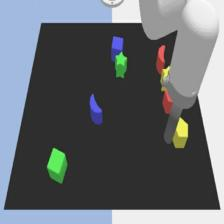
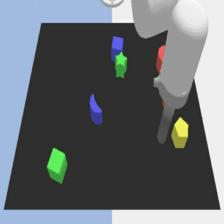
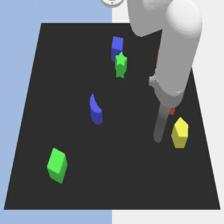
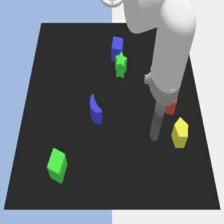

step: 4801/12800   lr: 0.02360   loss: 0.6399
step: 4802/12800   lr: 0.02360   loss: 0.6251
step: 4803/12800   lr: 0.02359   loss: 0.6594
step: 4804/12800   lr: 0.02359   loss: 0.6116
step: 4805/12800   lr: 0.02359   loss: 0.6821
step: 4806/12800   lr: 0.02358   loss: 0.6492
step: 4807/12800   lr: 0.02358   loss: 0.5839
step: 4808/12800   lr: 0.02358   loss: 0.6173
step: 4809/12800   lr: 0.02357   loss: 0.6124
step: 4810/12800   lr: 0.02357   loss: 0.6480
step: 4811/12800   lr: 0.02357   loss: 0.6325
step: 4812/12800   lr: 0.02356   loss: 0.6571
step: 4813/12800   lr: 0.02356   loss: 0.5844
step: 4814/12800   lr: 0.02356   loss: 0.6168
step: 4815/12800   lr: 0.02355   loss: 0.6727
step: 4816/12800   lr: 0.02355   loss: 0.6690
step: 4817/12800   lr: 0.02355   loss: 0.6312
step: 4818/12800   lr: 0.02354   loss: 0.5873
step: 4819/12800   lr: 0.02354   loss: 0.6725
step: 4820/12800   lr: 0.02354   loss: 0.6825
step: 4821/12800   lr: 0.02353   loss: 0.6193
step: 4822/12800   lr: 0.02353   l


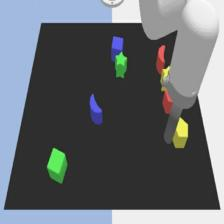
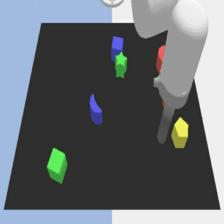
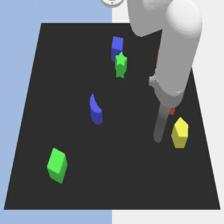
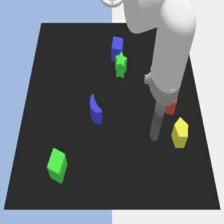

step: 4901/12800   lr: 0.02326   loss: 0.6194
step: 4902/12800   lr: 0.02326   loss: 0.6265
step: 4903/12800   lr: 0.02326   loss: 0.6577
step: 4904/12800   lr: 0.02325   loss: 0.6242
step: 4905/12800   lr: 0.02325   loss: 0.6703
step: 4906/12800   lr: 0.02325   loss: 0.5964
step: 4907/12800   lr: 0.02324   loss: 0.6167
step: 4908/12800   lr: 0.02324   loss: 0.6249
step: 4909/12800   lr: 0.02324   loss: 0.5251
step: 4910/12800   lr: 0.02323   loss: 0.5928
step: 4911/12800   lr: 0.02323   loss: 0.6623
step: 4912/12800   lr: 0.02323   loss: 0.6633
step: 4913/12800   lr: 0.02322   loss: 0.6635
step: 4914/12800   lr: 0.02322   loss: 0.6239
step: 4915/12800   lr: 0.02322   loss: 0.6073
step: 4916/12800   lr: 0.02321   loss: 0.6170
step: 4917/12800   lr: 0.02321   loss: 0.6029
step: 4918/12800   lr: 0.02320   loss: 0.6389
step: 4919/12800   lr: 0.02320   loss: 0.6124
step: 4920/12800   lr: 0.02320   loss: 0.6395
step: 4921/12800   lr: 0.02319   loss: 0.6661
step: 4922/12800   lr: 0.02319   l


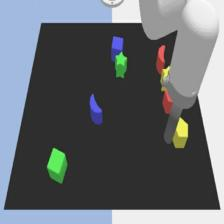
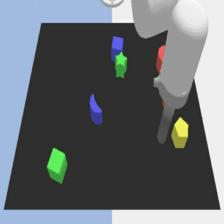
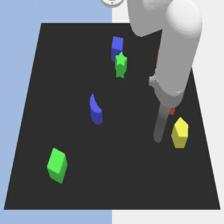
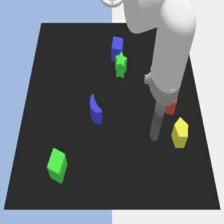

step: 5001/12800   lr: 0.02292   loss: 0.6530
step: 5002/12800   lr: 0.02292   loss: 0.6062
step: 5003/12800   lr: 0.02291   loss: 0.6380
step: 5004/12800   lr: 0.02291   loss: 0.5986
step: 5005/12800   lr: 0.02290   loss: 0.6473
step: 5006/12800   lr: 0.02290   loss: 0.5616
step: 5007/12800   lr: 0.02290   loss: 0.6385
step: 5008/12800   lr: 0.02289   loss: 0.6091
step: 5009/12800   lr: 0.02289   loss: 0.6512
step: 5010/12800   lr: 0.02289   loss: 0.6409
step: 5011/12800   lr: 0.02288   loss: 0.5964
step: 5012/12800   lr: 0.02288   loss: 0.5745
step: 5013/12800   lr: 0.02288   loss: 0.6555
step: 5014/12800   lr: 0.02287   loss: 0.6261
step: 5015/12800   lr: 0.02287   loss: 0.5702
step: 5016/12800   lr: 0.02287   loss: 0.6187
step: 5017/12800   lr: 0.02286   loss: 0.6758
step: 5018/12800   lr: 0.02286   loss: 0.6336
step: 5019/12800   lr: 0.02286   loss: 0.6568
step: 5020/12800   lr: 0.02285   loss: 0.6462
step: 5021/12800   lr: 0.02285   loss: 0.6039
step: 5022/12800   lr: 0.02285   l


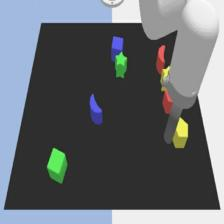
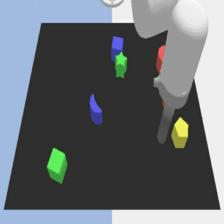
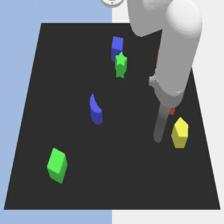
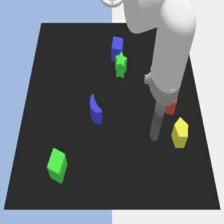

step: 5101/12800   lr: 0.02257   loss: 0.5450
step: 5102/12800   lr: 0.02256   loss: 0.6492
step: 5103/12800   lr: 0.02256   loss: 0.6151
step: 5104/12800   lr: 0.02256   loss: 0.6086
step: 5105/12800   lr: 0.02255   loss: 0.5920
step: 5106/12800   lr: 0.02255   loss: 0.6140
step: 5107/12800   lr: 0.02255   loss: 0.6300
step: 5108/12800   lr: 0.02254   loss: 0.6468
step: 5109/12800   lr: 0.02254   loss: 0.6687
step: 5110/12800   lr: 0.02254   loss: 0.6196
step: 5111/12800   lr: 0.02253   loss: 0.6701
step: 5112/12800   lr: 0.02253   loss: 0.5778
step: 5113/12800   lr: 0.02253   loss: 0.6106
step: 5114/12800   lr: 0.02252   loss: 0.6013
step: 5115/12800   lr: 0.02252   loss: 0.6616
step: 5116/12800   lr: 0.02252   loss: 0.6261
step: 5117/12800   lr: 0.02251   loss: 0.6208
step: 5118/12800   lr: 0.02251   loss: 0.6264
step: 5119/12800   lr: 0.02250   loss: 0.6171
step: 5120/12800   lr: 0.02250   loss: 0.5585
step: 5121/12800   lr: 0.02250   loss: 0.6598
step: 5122/12800   lr: 0.02249   l


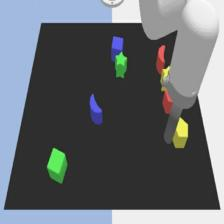
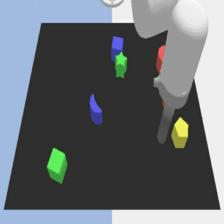
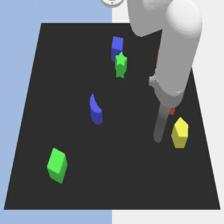
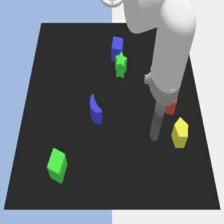

step: 5201/12800   lr: 0.02221   loss: 0.6466
step: 5202/12800   lr: 0.02221   loss: 0.6292
step: 5203/12800   lr: 0.02221   loss: 0.6568
step: 5204/12800   lr: 0.02220   loss: 0.6122
step: 5205/12800   lr: 0.02220   loss: 0.6235
step: 5206/12800   lr: 0.02219   loss: 0.6207
step: 5207/12800   lr: 0.02219   loss: 0.6069
step: 5208/12800   lr: 0.02219   loss: 0.5869
step: 5209/12800   lr: 0.02218   loss: 0.6532
step: 5210/12800   lr: 0.02218   loss: 0.6367
step: 5211/12800   lr: 0.02218   loss: 0.6120
step: 5212/12800   lr: 0.02217   loss: 0.6898
step: 5213/12800   lr: 0.02217   loss: 0.6569
step: 5214/12800   lr: 0.02217   loss: 0.6652
step: 5215/12800   lr: 0.02216   loss: 0.6478
step: 5216/12800   lr: 0.02216   loss: 0.6060
step: 5217/12800   lr: 0.02216   loss: 0.6281
step: 5218/12800   lr: 0.02215   loss: 0.6465
step: 5219/12800   lr: 0.02215   loss: 0.6221
step: 5220/12800   lr: 0.02214   loss: 0.6353
step: 5221/12800   lr: 0.02214   loss: 0.6237
step: 5222/12800   lr: 0.02214   l


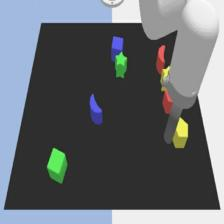
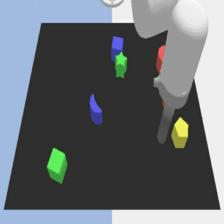
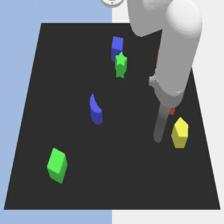
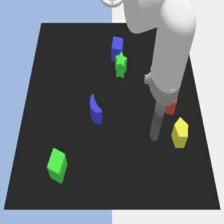

step: 5301/12800   lr: 0.02185   loss: 0.5787
step: 5302/12800   lr: 0.02185   loss: 0.6620
step: 5303/12800   lr: 0.02184   loss: 0.6587
step: 5304/12800   lr: 0.02184   loss: 0.6346
step: 5305/12800   lr: 0.02184   loss: 0.6358
step: 5306/12800   lr: 0.02183   loss: 0.6657
step: 5307/12800   lr: 0.02183   loss: 0.6024
step: 5308/12800   lr: 0.02183   loss: 0.6261
step: 5309/12800   lr: 0.02182   loss: 0.5763
step: 5310/12800   lr: 0.02182   loss: 0.6146
step: 5311/12800   lr: 0.02181   loss: 0.6834
step: 5312/12800   lr: 0.02181   loss: 0.6241
step: 5313/12800   lr: 0.02181   loss: 0.6330
step: 5314/12800   lr: 0.02180   loss: 0.6147
step: 5315/12800   lr: 0.02180   loss: 0.6531
step: 5316/12800   lr: 0.02180   loss: 0.6315
step: 5317/12800   lr: 0.02179   loss: 0.6599
step: 5318/12800   lr: 0.02179   loss: 0.6075
step: 5319/12800   lr: 0.02179   loss: 0.6274
step: 5320/12800   lr: 0.02178   loss: 0.5619
step: 5321/12800   lr: 0.02178   loss: 0.5811
step: 5322/12800   lr: 0.02177   l


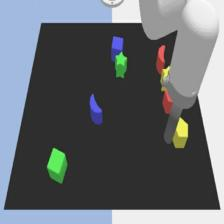
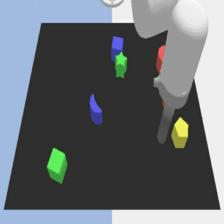
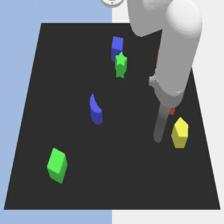
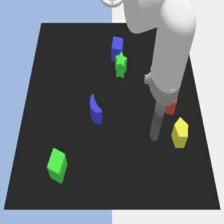

step: 5401/12800   lr: 0.02148   loss: 1.1836
step: 5402/12800   lr: 0.02148   loss: 1.2543
step: 5403/12800   lr: 0.02148   loss: 1.0955
step: 5404/12800   lr: 0.02147   loss: 1.1550
step: 5405/12800   lr: 0.02147   loss: 1.2371
step: 5406/12800   lr: 0.02147   loss: 1.2647
step: 5407/12800   lr: 0.02146   loss: 1.2040
step: 5408/12800   lr: 0.02146   loss: 1.2122
step: 5409/12800   lr: 0.02146   loss: 1.1606
step: 5410/12800   lr: 0.02145   loss: 1.1603
step: 5411/12800   lr: 0.02145   loss: 1.2182
step: 5412/12800   lr: 0.02144   loss: 1.1557
step: 5413/12800   lr: 0.02144   loss: 1.2254
step: 5414/12800   lr: 0.02144   loss: 1.2008
step: 5415/12800   lr: 0.02143   loss: 1.1439
step: 5416/12800   lr: 0.02143   loss: 1.2085
step: 5417/12800   lr: 0.02143   loss: 1.2530
step: 5418/12800   lr: 0.02142   loss: 1.1593
step: 5419/12800   lr: 0.02142   loss: 1.2246
step: 5420/12800   lr: 0.02141   loss: 1.1987
step: 5421/12800   lr: 0.02141   loss: 1.1579
step: 5422/12800   lr: 0.02141   l


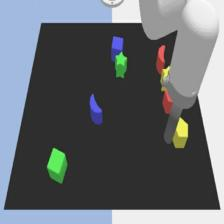
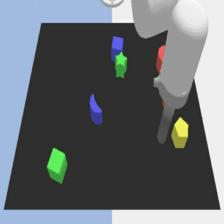
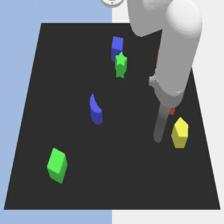
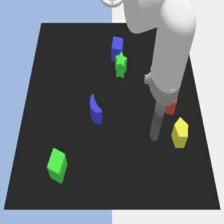

step: 5501/12800   lr: 0.02111   loss: 1.0804
step: 5502/12800   lr: 0.02111   loss: 1.1658
step: 5503/12800   lr: 0.02111   loss: 1.0004
step: 5504/12800   lr: 0.02110   loss: 0.9549
step: 5505/12800   lr: 0.02110   loss: 1.0963
step: 5506/12800   lr: 0.02109   loss: 1.0754
step: 5507/12800   lr: 0.02109   loss: 1.1074
step: 5508/12800   lr: 0.02109   loss: 1.1298
step: 5509/12800   lr: 0.02108   loss: 1.1314
step: 5510/12800   lr: 0.02108   loss: 1.0831
step: 5511/12800   lr: 0.02108   loss: 1.1053
step: 5512/12800   lr: 0.02107   loss: 1.0487
step: 5513/12800   lr: 0.02107   loss: 1.0053
step: 5514/12800   lr: 0.02107   loss: 1.0679
step: 5515/12800   lr: 0.02106   loss: 1.0453
step: 5516/12800   lr: 0.02106   loss: 1.0505
step: 5517/12800   lr: 0.02105   loss: 1.0877
step: 5518/12800   lr: 0.02105   loss: 1.0774
step: 5519/12800   lr: 0.02105   loss: 1.1100
step: 5520/12800   lr: 0.02104   loss: 1.0705
step: 5521/12800   lr: 0.02104   loss: 1.0764
step: 5522/12800   lr: 0.02104   l


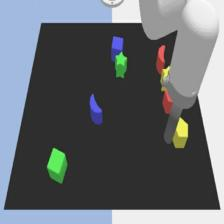
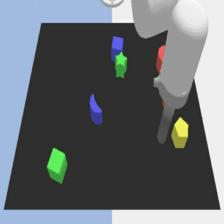
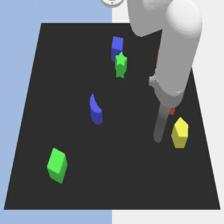
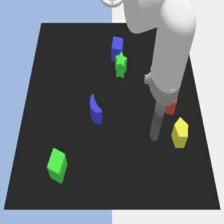

step: 5601/12800   lr: 0.02074   loss: 0.9396
step: 5602/12800   lr: 0.02073   loss: 1.0394
step: 5603/12800   lr: 0.02073   loss: 1.0693
step: 5604/12800   lr: 0.02073   loss: 1.0445
step: 5605/12800   lr: 0.02072   loss: 0.9854
step: 5606/12800   lr: 0.02072   loss: 1.0225
step: 5607/12800   lr: 0.02072   loss: 1.0480
step: 5608/12800   lr: 0.02071   loss: 1.1190
step: 5609/12800   lr: 0.02071   loss: 1.0283
step: 5610/12800   lr: 0.02070   loss: 1.0174
step: 5611/12800   lr: 0.02070   loss: 1.0102
step: 5612/12800   lr: 0.02070   loss: 1.0252
step: 5613/12800   lr: 0.02069   loss: 1.0562
step: 5614/12800   lr: 0.02069   loss: 1.0189
step: 5615/12800   lr: 0.02068   loss: 1.0553
step: 5616/12800   lr: 0.02068   loss: 1.0445
step: 5617/12800   lr: 0.02068   loss: 1.0267
step: 5618/12800   lr: 0.02067   loss: 1.0675
step: 5619/12800   lr: 0.02067   loss: 0.9890
step: 5620/12800   lr: 0.02067   loss: 0.9791
step: 5621/12800   lr: 0.02066   loss: 1.0245
step: 5622/12800   lr: 0.02066   l


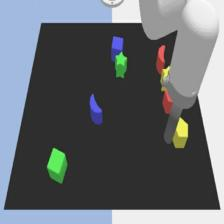
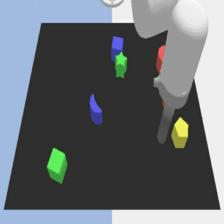
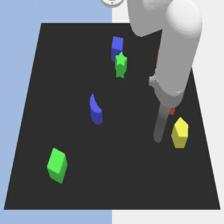
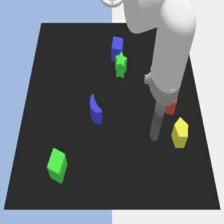

step: 5701/12800   lr: 0.02036   loss: 0.9658
step: 5702/12800   lr: 0.02035   loss: 1.0468
step: 5703/12800   lr: 0.02035   loss: 0.9561
step: 5704/12800   lr: 0.02035   loss: 0.9341
step: 5705/12800   lr: 0.02034   loss: 1.0017
step: 5706/12800   lr: 0.02034   loss: 0.9698
step: 5707/12800   lr: 0.02033   loss: 0.9719
step: 5708/12800   lr: 0.02033   loss: 0.9959
step: 5709/12800   lr: 0.02033   loss: 0.9741
step: 5710/12800   lr: 0.02032   loss: 0.9083
step: 5711/12800   lr: 0.02032   loss: 0.9060
step: 5712/12800   lr: 0.02032   loss: 0.9513
step: 5713/12800   lr: 0.02031   loss: 0.9457
step: 5714/12800   lr: 0.02031   loss: 0.9584
step: 5715/12800   lr: 0.02030   loss: 0.9169
step: 5716/12800   lr: 0.02030   loss: 0.9931
step: 5717/12800   lr: 0.02030   loss: 0.9161
step: 5718/12800   lr: 0.02029   loss: 0.9361
step: 5719/12800   lr: 0.02029   loss: 0.9329
step: 5720/12800   lr: 0.02029   loss: 0.9564
step: 5721/12800   lr: 0.02028   loss: 0.8689
step: 5722/12800   lr: 0.02028   l


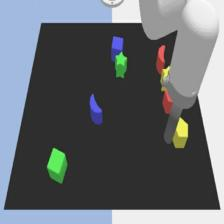
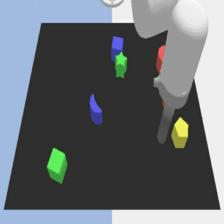
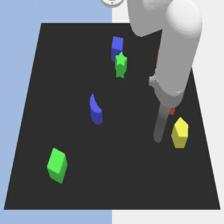
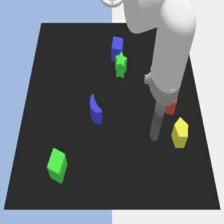

step: 5801/12800   lr: 0.01997   loss: 0.9015
step: 5802/12800   lr: 0.01997   loss: 0.9497
step: 5803/12800   lr: 0.01997   loss: 0.9505
step: 5804/12800   lr: 0.01996   loss: 0.9393
step: 5805/12800   lr: 0.01996   loss: 0.9231
step: 5806/12800   lr: 0.01995   loss: 0.8196
step: 5807/12800   lr: 0.01995   loss: 0.9198
step: 5808/12800   lr: 0.01995   loss: 0.8396
step: 5809/12800   lr: 0.01994   loss: 0.8695
step: 5810/12800   lr: 0.01994   loss: 0.9039
step: 5811/12800   lr: 0.01994   loss: 0.8686
step: 5812/12800   lr: 0.01993   loss: 0.8951
step: 5813/12800   lr: 0.01993   loss: 0.9167
step: 5814/12800   lr: 0.01992   loss: 0.8325
step: 5815/12800   lr: 0.01992   loss: 0.8836
step: 5816/12800   lr: 0.01992   loss: 0.8784
step: 5817/12800   lr: 0.01991   loss: 0.9041
step: 5818/12800   lr: 0.01991   loss: 0.8433
step: 5819/12800   lr: 0.01990   loss: 0.8725
step: 5820/12800   lr: 0.01990   loss: 0.9141
step: 5821/12800   lr: 0.01990   loss: 0.9012
step: 5822/12800   lr: 0.01989   l


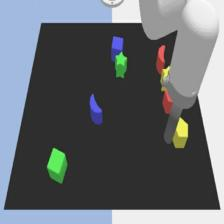
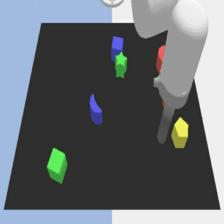
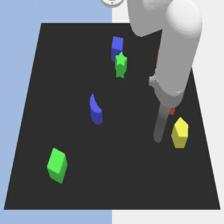
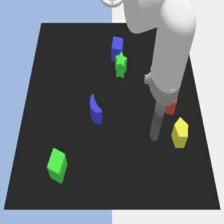

step: 5901/12800   lr: 0.01959   loss: 0.8178
step: 5902/12800   lr: 0.01958   loss: 0.8481
step: 5903/12800   lr: 0.01958   loss: 0.8622
step: 5904/12800   lr: 0.01957   loss: 0.7831
step: 5905/12800   lr: 0.01957   loss: 0.8195
step: 5906/12800   lr: 0.01957   loss: 0.7823
step: 5907/12800   lr: 0.01956   loss: 0.7930
step: 5908/12800   lr: 0.01956   loss: 0.8121
step: 5909/12800   lr: 0.01956   loss: 0.8429
step: 5910/12800   lr: 0.01955   loss: 0.8152
step: 5911/12800   lr: 0.01955   loss: 0.8762
step: 5912/12800   lr: 0.01954   loss: 0.8940
step: 5913/12800   lr: 0.01954   loss: 0.7877
step: 5914/12800   lr: 0.01954   loss: 0.7549
step: 5915/12800   lr: 0.01953   loss: 0.7961
step: 5916/12800   lr: 0.01953   loss: 0.8045
step: 5917/12800   lr: 0.01952   loss: 0.7678
step: 5918/12800   lr: 0.01952   loss: 0.8744
step: 5919/12800   lr: 0.01952   loss: 0.7688
step: 5920/12800   lr: 0.01951   loss: 0.8395
step: 5921/12800   lr: 0.01951   loss: 0.8176
step: 5922/12800   lr: 0.01950   l


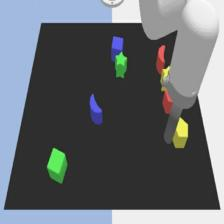
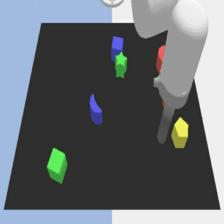
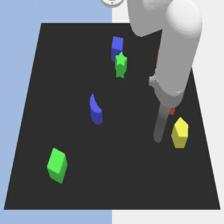
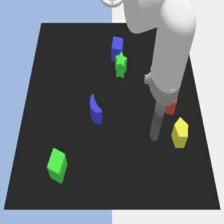

step: 6001/12800   lr: 0.01920   loss: 0.7478
step: 6002/12800   lr: 0.01919   loss: 0.7472
step: 6003/12800   lr: 0.01919   loss: 0.7645
step: 6004/12800   lr: 0.01918   loss: 0.7226
step: 6005/12800   lr: 0.01918   loss: 0.7764
step: 6006/12800   lr: 0.01918   loss: 0.8235
step: 6007/12800   lr: 0.01917   loss: 0.7560
step: 6008/12800   lr: 0.01917   loss: 0.7452
step: 6009/12800   lr: 0.01916   loss: 0.7670
step: 6010/12800   lr: 0.01916   loss: 0.7231
step: 6011/12800   lr: 0.01916   loss: 0.7379
step: 6012/12800   lr: 0.01915   loss: 0.7638
step: 6013/12800   lr: 0.01915   loss: 0.7984
step: 6014/12800   lr: 0.01914   loss: 0.7478
step: 6015/12800   lr: 0.01914   loss: 0.7209
step: 6016/12800   lr: 0.01914   loss: 0.7689
step: 6017/12800   lr: 0.01913   loss: 0.7489
step: 6018/12800   lr: 0.01913   loss: 0.7748
step: 6019/12800   lr: 0.01912   loss: 0.7714
step: 6020/12800   lr: 0.01912   loss: 0.7586
step: 6021/12800   lr: 0.01912   loss: 0.7026
step: 6022/12800   lr: 0.01911   l


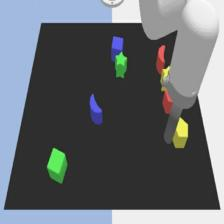
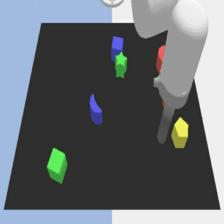
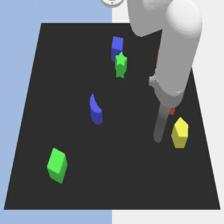
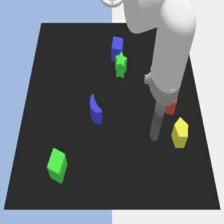

step: 6101/12800   lr: 0.01880   loss: 0.6834
step: 6102/12800   lr: 0.01880   loss: 0.6970
step: 6103/12800   lr: 0.01879   loss: 0.7183
step: 6104/12800   lr: 0.01879   loss: 0.6665
step: 6105/12800   lr: 0.01879   loss: 0.6799
step: 6106/12800   lr: 0.01878   loss: 0.7220
step: 6107/12800   lr: 0.01878   loss: 0.7257
step: 6108/12800   lr: 0.01877   loss: 0.7147
step: 6109/12800   lr: 0.01877   loss: 0.6988
step: 6110/12800   lr: 0.01877   loss: 0.7111
step: 6111/12800   lr: 0.01876   loss: 0.7186
step: 6112/12800   lr: 0.01876   loss: 0.7264
step: 6113/12800   lr: 0.01875   loss: 0.6772
step: 6114/12800   lr: 0.01875   loss: 0.7217
step: 6115/12800   lr: 0.01875   loss: 0.6629
step: 6116/12800   lr: 0.01874   loss: 0.6669
step: 6117/12800   lr: 0.01874   loss: 0.7042
step: 6118/12800   lr: 0.01873   loss: 0.6577
step: 6119/12800   lr: 0.01873   loss: 0.6904
step: 6120/12800   lr: 0.01873   loss: 0.6961
step: 6121/12800   lr: 0.01872   loss: 0.6871
step: 6122/12800   lr: 0.01872   l


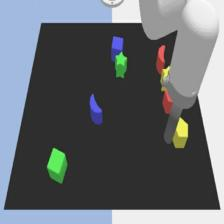
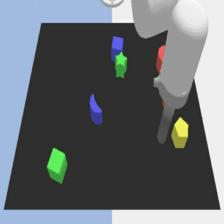
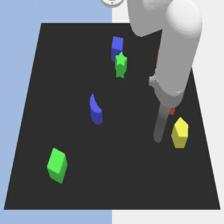
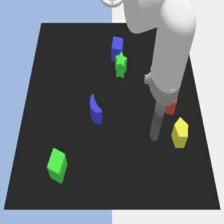

step: 6201/12800   lr: 0.01840   loss: 0.6785
step: 6202/12800   lr: 0.01840   loss: 0.7106
step: 6203/12800   lr: 0.01840   loss: 0.7064
step: 6204/12800   lr: 0.01839   loss: 0.6289
step: 6205/12800   lr: 0.01839   loss: 0.6820
step: 6206/12800   lr: 0.01838   loss: 0.6787
step: 6207/12800   lr: 0.01838   loss: 0.7607
step: 6208/12800   lr: 0.01838   loss: 0.6877
step: 6209/12800   lr: 0.01837   loss: 0.6894
step: 6210/12800   lr: 0.01837   loss: 0.7422
step: 6211/12800   lr: 0.01836   loss: 0.6692
step: 6212/12800   lr: 0.01836   loss: 0.7315
step: 6213/12800   lr: 0.01836   loss: 0.6907
step: 6214/12800   lr: 0.01835   loss: 0.6677
step: 6215/12800   lr: 0.01835   loss: 0.7288
step: 6216/12800   lr: 0.01834   loss: 0.6927
step: 6217/12800   lr: 0.01834   loss: 0.6632
step: 6218/12800   lr: 0.01834   loss: 0.6888
step: 6219/12800   lr: 0.01833   loss: 0.6767
step: 6220/12800   lr: 0.01833   loss: 0.7180
step: 6221/12800   lr: 0.01832   loss: 0.6992
step: 6222/12800   lr: 0.01832   l


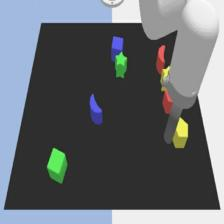
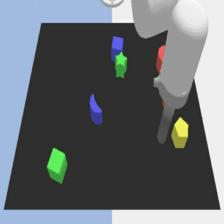
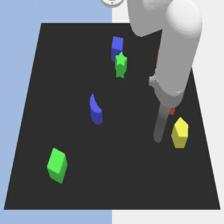
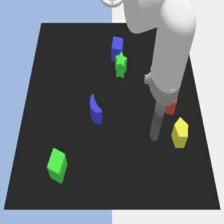

step: 6301/12800   lr: 0.01800   loss: 0.6892
step: 6302/12800   lr: 0.01800   loss: 0.6941
step: 6303/12800   lr: 0.01800   loss: 0.6792
step: 6304/12800   lr: 0.01799   loss: 0.6681
step: 6305/12800   lr: 0.01799   loss: 0.7157
step: 6306/12800   lr: 0.01798   loss: 0.6309
step: 6307/12800   lr: 0.01798   loss: 0.6682
step: 6308/12800   lr: 0.01798   loss: 0.6633
step: 6309/12800   lr: 0.01797   loss: 0.6862
step: 6310/12800   lr: 0.01797   loss: 0.6289
step: 6311/12800   lr: 0.01796   loss: 0.6858
step: 6312/12800   lr: 0.01796   loss: 0.6908
step: 6313/12800   lr: 0.01796   loss: 0.7172
step: 6314/12800   lr: 0.01795   loss: 0.6702
step: 6315/12800   lr: 0.01795   loss: 0.6777
step: 6316/12800   lr: 0.01794   loss: 0.6955
step: 6317/12800   lr: 0.01794   loss: 0.6760
step: 6318/12800   lr: 0.01794   loss: 0.6210
step: 6319/12800   lr: 0.01793   loss: 0.7088
step: 6320/12800   lr: 0.01793   loss: 0.6979
step: 6321/12800   lr: 0.01792   loss: 0.6596
step: 6322/12800   lr: 0.01792   l


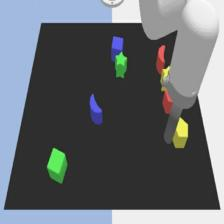
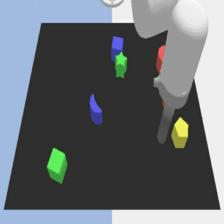
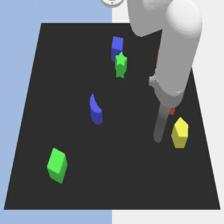
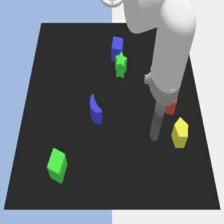

step: 6401/12800   lr: 0.01760   loss: 0.6222
step: 6402/12800   lr: 0.01760   loss: 0.6599
step: 6403/12800   lr: 0.01759   loss: 0.6467
step: 6404/12800   lr: 0.01759   loss: 0.6814
step: 6405/12800   lr: 0.01759   loss: 0.6546
step: 6406/12800   lr: 0.01758   loss: 0.6661
step: 6407/12800   lr: 0.01758   loss: 0.6822
step: 6408/12800   lr: 0.01757   loss: 0.7039
step: 6409/12800   lr: 0.01757   loss: 0.6796
step: 6410/12800   lr: 0.01757   loss: 0.6621
step: 6411/12800   lr: 0.01756   loss: 0.6908
step: 6412/12800   lr: 0.01756   loss: 0.6036
step: 6413/12800   lr: 0.01755   loss: 0.6477
step: 6414/12800   lr: 0.01755   loss: 0.6666
step: 6415/12800   lr: 0.01755   loss: 0.6597
step: 6416/12800   lr: 0.01754   loss: 0.6651
step: 6417/12800   lr: 0.01754   loss: 0.6408
step: 6418/12800   lr: 0.01753   loss: 0.6699
step: 6419/12800   lr: 0.01753   loss: 0.6654
step: 6420/12800   lr: 0.01753   loss: 0.6361
step: 6421/12800   lr: 0.01752   loss: 0.6139
step: 6422/12800   lr: 0.01752   l


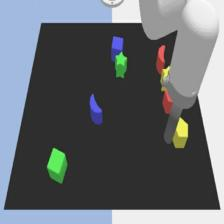
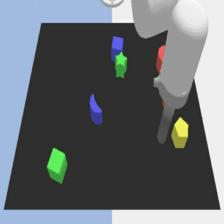
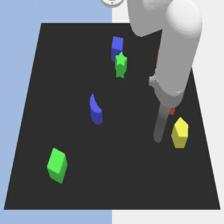
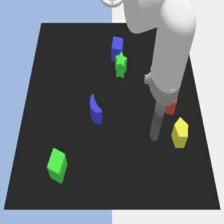

step: 6501/12800   lr: 0.01720   loss: 0.6832
step: 6502/12800   lr: 0.01719   loss: 0.6499
step: 6503/12800   lr: 0.01719   loss: 0.6891
step: 6504/12800   lr: 0.01719   loss: 0.6688
step: 6505/12800   lr: 0.01718   loss: 0.6634
step: 6506/12800   lr: 0.01718   loss: 0.6322
step: 6507/12800   lr: 0.01717   loss: 0.6659
step: 6508/12800   lr: 0.01717   loss: 0.6840
step: 6509/12800   lr: 0.01717   loss: 0.6819
step: 6510/12800   lr: 0.01716   loss: 0.6605
step: 6511/12800   lr: 0.01716   loss: 0.6800
step: 6512/12800   lr: 0.01715   loss: 0.6603
step: 6513/12800   lr: 0.01715   loss: 0.6939
step: 6514/12800   lr: 0.01715   loss: 0.6352
step: 6515/12800   lr: 0.01714   loss: 0.6700
step: 6516/12800   lr: 0.01714   loss: 0.6898
step: 6517/12800   lr: 0.01713   loss: 0.7009
step: 6518/12800   lr: 0.01713   loss: 0.6622
step: 6519/12800   lr: 0.01713   loss: 0.6222
step: 6520/12800   lr: 0.01712   loss: 0.6400
step: 6521/12800   lr: 0.01712   loss: 0.6723
step: 6522/12800   lr: 0.01711   l


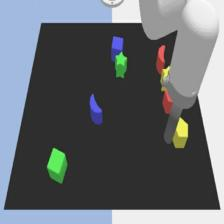
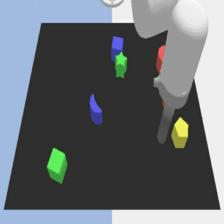
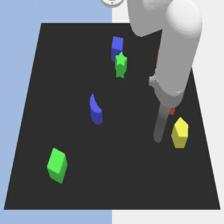
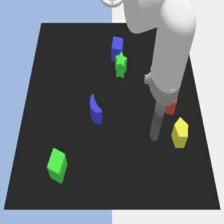

step: 6601/12800   lr: 0.01679   loss: 0.6063
step: 6602/12800   lr: 0.01679   loss: 0.6683
step: 6603/12800   lr: 0.01679   loss: 0.6391
step: 6604/12800   lr: 0.01678   loss: 0.6541
step: 6605/12800   lr: 0.01678   loss: 0.6355
step: 6606/12800   lr: 0.01677   loss: 0.6762
step: 6607/12800   lr: 0.01677   loss: 0.6455
step: 6608/12800   lr: 0.01676   loss: 0.6796
step: 6609/12800   lr: 0.01676   loss: 0.6510
step: 6610/12800   lr: 0.01676   loss: 0.6540
step: 6611/12800   lr: 0.01675   loss: 0.6725
step: 6612/12800   lr: 0.01675   loss: 0.7044
step: 6613/12800   lr: 0.01674   loss: 0.6372
step: 6614/12800   lr: 0.01674   loss: 0.6238
step: 6615/12800   lr: 0.01674   loss: 0.7066
step: 6616/12800   lr: 0.01673   loss: 0.7167
step: 6617/12800   lr: 0.01673   loss: 0.6601
step: 6618/12800   lr: 0.01672   loss: 0.6679
step: 6619/12800   lr: 0.01672   loss: 0.6185
step: 6620/12800   lr: 0.01672   loss: 0.6917
step: 6621/12800   lr: 0.01671   loss: 0.6487
step: 6622/12800   lr: 0.01671   l


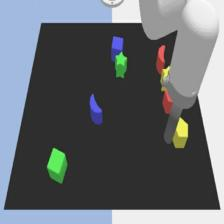
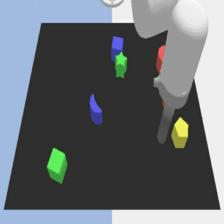
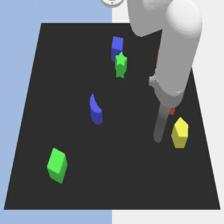
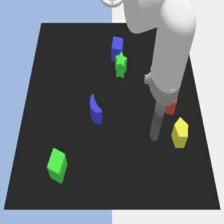

step: 6701/12800   lr: 0.01639   loss: 0.6192
step: 6702/12800   lr: 0.01638   loss: 0.6854
step: 6703/12800   lr: 0.01638   loss: 0.6114
step: 6704/12800   lr: 0.01637   loss: 0.6402
step: 6705/12800   lr: 0.01637   loss: 0.5973
step: 6706/12800   lr: 0.01637   loss: 0.6657
step: 6707/12800   lr: 0.01636   loss: 0.6504
step: 6708/12800   lr: 0.01636   loss: 0.6585
step: 6709/12800   lr: 0.01635   loss: 0.6938
step: 6710/12800   lr: 0.01635   loss: 0.6445
step: 6711/12800   lr: 0.01635   loss: 0.6216
step: 6712/12800   lr: 0.01634   loss: 0.6393
step: 6713/12800   lr: 0.01634   loss: 0.6504
step: 6714/12800   lr: 0.01633   loss: 0.6619
step: 6715/12800   lr: 0.01633   loss: 0.6196
step: 6716/12800   lr: 0.01633   loss: 0.6395
step: 6717/12800   lr: 0.01632   loss: 0.6898
step: 6718/12800   lr: 0.01632   loss: 0.6927
step: 6719/12800   lr: 0.01631   loss: 0.6668
step: 6720/12800   lr: 0.01631   loss: 0.6698
step: 6721/12800   lr: 0.01631   loss: 0.6564
step: 6722/12800   lr: 0.01630   l


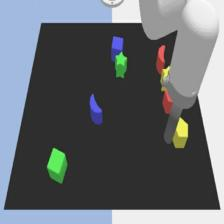
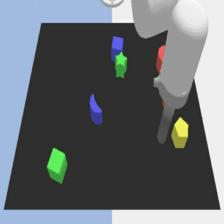
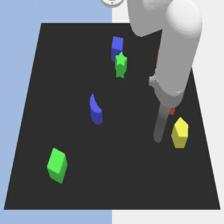
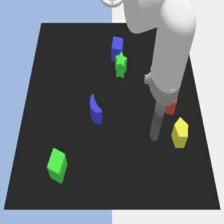

step: 6801/12800   lr: 0.01598   loss: 0.6637
step: 6802/12800   lr: 0.01597   loss: 0.6584
step: 6803/12800   lr: 0.01597   loss: 0.6203
step: 6804/12800   lr: 0.01597   loss: 0.6344
step: 6805/12800   lr: 0.01596   loss: 0.6294
step: 6806/12800   lr: 0.01596   loss: 0.6565
step: 6807/12800   lr: 0.01595   loss: 0.6800
step: 6808/12800   lr: 0.01595   loss: 0.6445
step: 6809/12800   lr: 0.01595   loss: 0.6330
step: 6810/12800   lr: 0.01594   loss: 0.6396
step: 6811/12800   lr: 0.01594   loss: 0.6685
step: 6812/12800   lr: 0.01593   loss: 0.6490
step: 6813/12800   lr: 0.01593   loss: 0.6988
step: 6814/12800   lr: 0.01593   loss: 0.6621
step: 6815/12800   lr: 0.01592   loss: 0.6138
step: 6816/12800   lr: 0.01592   loss: 0.6915
step: 6817/12800   lr: 0.01591   loss: 0.6496
step: 6818/12800   lr: 0.01591   loss: 0.6187
step: 6819/12800   lr: 0.01591   loss: 0.6000
step: 6820/12800   lr: 0.01590   loss: 0.5800
step: 6821/12800   lr: 0.01590   loss: 0.6485
step: 6822/12800   lr: 0.01589   l


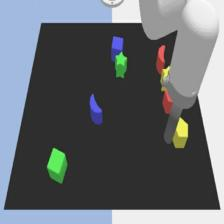
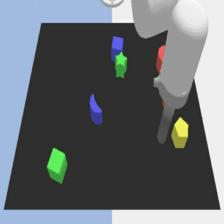
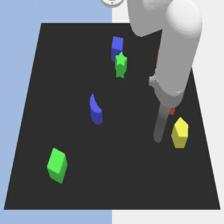
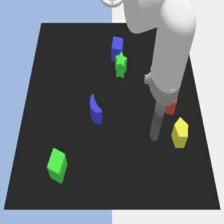

step: 6901/12800   lr: 0.01557   loss: 0.6227
step: 6902/12800   lr: 0.01557   loss: 0.6867
step: 6903/12800   lr: 0.01556   loss: 0.6708
step: 6904/12800   lr: 0.01556   loss: 0.6938
step: 6905/12800   lr: 0.01555   loss: 0.6702
step: 6906/12800   lr: 0.01555   loss: 0.6646
step: 6907/12800   lr: 0.01555   loss: 0.6347
step: 6908/12800   lr: 0.01554   loss: 0.6725
step: 6909/12800   lr: 0.01554   loss: 0.6426
step: 6910/12800   lr: 0.01553   loss: 0.6009
step: 6911/12800   lr: 0.01553   loss: 0.6808
step: 6912/12800   lr: 0.01553   loss: 0.6497
step: 6913/12800   lr: 0.01552   loss: 0.6407
step: 6914/12800   lr: 0.01552   loss: 0.6575
step: 6915/12800   lr: 0.01551   loss: 0.6289
step: 6916/12800   lr: 0.01551   loss: 0.6427
step: 6917/12800   lr: 0.01551   loss: 0.6816
step: 6918/12800   lr: 0.01550   loss: 0.5909
step: 6919/12800   lr: 0.01550   loss: 0.6587
step: 6920/12800   lr: 0.01549   loss: 0.6337
step: 6921/12800   lr: 0.01549   loss: 0.6137
step: 6922/12800   lr: 0.01548   l


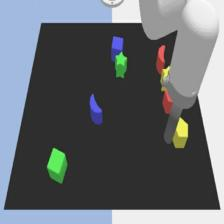
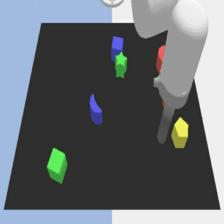
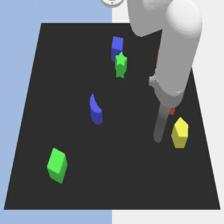
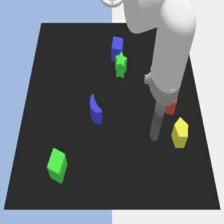

step: 7001/12800   lr: 0.01516   loss: 0.6358
step: 7002/12800   lr: 0.01516   loss: 0.6565
step: 7003/12800   lr: 0.01515   loss: 0.6501
step: 7004/12800   lr: 0.01515   loss: 0.6398
step: 7005/12800   lr: 0.01515   loss: 0.6654
step: 7006/12800   lr: 0.01514   loss: 0.6877
step: 7007/12800   lr: 0.01514   loss: 0.6676
step: 7008/12800   lr: 0.01513   loss: 0.6416
step: 7009/12800   lr: 0.01513   loss: 0.6552
step: 7010/12800   lr: 0.01512   loss: 0.6498
step: 7011/12800   lr: 0.01512   loss: 0.6339
step: 7012/12800   lr: 0.01512   loss: 0.6623
step: 7013/12800   lr: 0.01511   loss: 0.6411
step: 7014/12800   lr: 0.01511   loss: 0.6087
step: 7015/12800   lr: 0.01510   loss: 0.6521
step: 7016/12800   lr: 0.01510   loss: 0.7025
step: 7017/12800   lr: 0.01510   loss: 0.6445
step: 7018/12800   lr: 0.01509   loss: 0.6794
step: 7019/12800   lr: 0.01509   loss: 0.6346
step: 7020/12800   lr: 0.01508   loss: 0.6527
step: 7021/12800   lr: 0.01508   loss: 0.6496
step: 7022/12800   lr: 0.01508   l


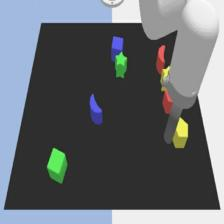
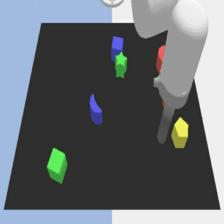
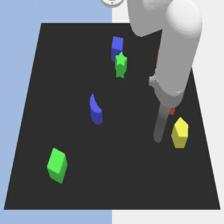
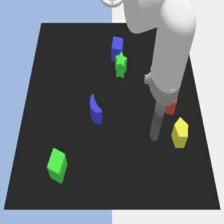

step: 7101/12800   lr: 0.01475   loss: 0.6269
step: 7102/12800   lr: 0.01475   loss: 0.6180
step: 7103/12800   lr: 0.01474   loss: 0.6293
step: 7104/12800   lr: 0.01474   loss: 0.6693
step: 7105/12800   lr: 0.01474   loss: 0.6587
step: 7106/12800   lr: 0.01473   loss: 0.6926
step: 7107/12800   lr: 0.01473   loss: 0.6590
step: 7108/12800   lr: 0.01472   loss: 0.6422
step: 7109/12800   lr: 0.01472   loss: 0.6225
step: 7110/12800   lr: 0.01472   loss: 0.5964
step: 7111/12800   lr: 0.01471   loss: 0.6704
step: 7112/12800   lr: 0.01471   loss: 0.6644
step: 7113/12800   lr: 0.01470   loss: 0.6465
step: 7114/12800   lr: 0.01470   loss: 0.6617
step: 7115/12800   lr: 0.01470   loss: 0.6423
step: 7116/12800   lr: 0.01469   loss: 0.6382
step: 7117/12800   lr: 0.01469   loss: 0.6255
step: 7118/12800   lr: 0.01468   loss: 0.6241
step: 7119/12800   lr: 0.01468   loss: 0.6978
step: 7120/12800   lr: 0.01467   loss: 0.5723
step: 7121/12800   lr: 0.01467   loss: 0.6404
step: 7122/12800   lr: 0.01467   l


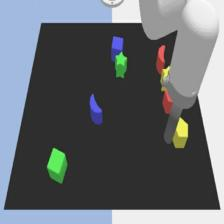
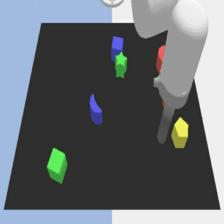
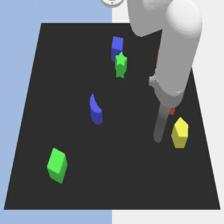
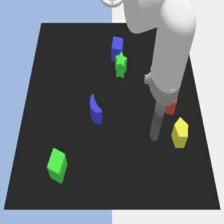

step: 7201/12800   lr: 0.01434   loss: 0.6617
step: 7202/12800   lr: 0.01434   loss: 0.6482
step: 7203/12800   lr: 0.01434   loss: 0.5757
step: 7204/12800   lr: 0.01433   loss: 0.6142
step: 7205/12800   lr: 0.01433   loss: 0.6888
step: 7206/12800   lr: 0.01432   loss: 0.6216
step: 7207/12800   lr: 0.01432   loss: 0.6615
step: 7208/12800   lr: 0.01432   loss: 0.6478
step: 7209/12800   lr: 0.01431   loss: 0.6776
step: 7210/12800   lr: 0.01431   loss: 0.6175
step: 7211/12800   lr: 0.01430   loss: 0.6578
step: 7212/12800   lr: 0.01430   loss: 0.6105
step: 7213/12800   lr: 0.01429   loss: 0.6582
step: 7214/12800   lr: 0.01429   loss: 0.6621
step: 7215/12800   lr: 0.01429   loss: 0.5979
step: 7216/12800   lr: 0.01428   loss: 0.6488
step: 7217/12800   lr: 0.01428   loss: 0.6012
step: 7218/12800   lr: 0.01427   loss: 0.6588
step: 7219/12800   lr: 0.01427   loss: 0.6942
step: 7220/12800   lr: 0.01427   loss: 0.6486
step: 7221/12800   lr: 0.01426   loss: 0.6042
step: 7222/12800   lr: 0.01426   l


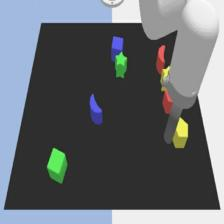
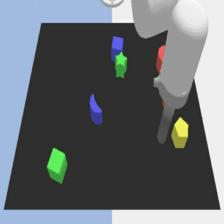
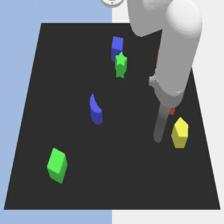
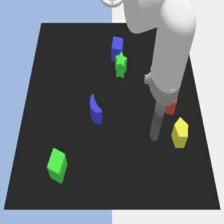

step: 7301/12800   lr: 0.01394   loss: 0.6497
step: 7302/12800   lr: 0.01393   loss: 0.6321
step: 7303/12800   lr: 0.01393   loss: 0.6767
step: 7304/12800   lr: 0.01392   loss: 0.6084
step: 7305/12800   lr: 0.01392   loss: 0.6299
step: 7306/12800   lr: 0.01391   loss: 0.6316
step: 7307/12800   lr: 0.01391   loss: 0.6526
step: 7308/12800   lr: 0.01391   loss: 0.6961
step: 7309/12800   lr: 0.01390   loss: 0.6518
step: 7310/12800   lr: 0.01390   loss: 0.6332
step: 7311/12800   lr: 0.01389   loss: 0.6351
step: 7312/12800   lr: 0.01389   loss: 0.6274
step: 7313/12800   lr: 0.01389   loss: 0.6665
step: 7314/12800   lr: 0.01388   loss: 0.5403
step: 7315/12800   lr: 0.01388   loss: 0.5993
step: 7316/12800   lr: 0.01387   loss: 0.6204
step: 7317/12800   lr: 0.01387   loss: 0.6418
step: 7318/12800   lr: 0.01387   loss: 0.6578
step: 7319/12800   lr: 0.01386   loss: 0.6342
step: 7320/12800   lr: 0.01386   loss: 0.6574
step: 7321/12800   lr: 0.01385   loss: 0.6184
step: 7322/12800   lr: 0.01385   l


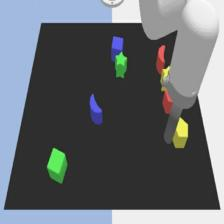
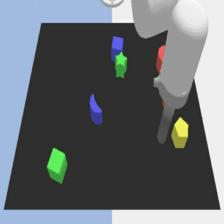
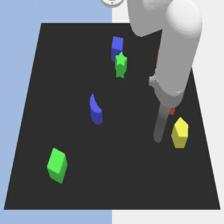
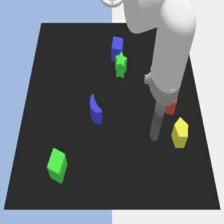

step: 7401/12800   lr: 0.01353   loss: 0.6930
step: 7402/12800   lr: 0.01352   loss: 0.6473
step: 7403/12800   lr: 0.01352   loss: 0.6547
step: 7404/12800   lr: 0.01352   loss: 0.6482
step: 7405/12800   lr: 0.01351   loss: 0.6215
step: 7406/12800   lr: 0.01351   loss: 0.6784
step: 7407/12800   lr: 0.01350   loss: 0.6304
step: 7408/12800   lr: 0.01350   loss: 0.6519
step: 7409/12800   lr: 0.01350   loss: 0.6286
step: 7410/12800   lr: 0.01349   loss: 0.6927
step: 7411/12800   lr: 0.01349   loss: 0.6532
step: 7412/12800   lr: 0.01348   loss: 0.6599
step: 7413/12800   lr: 0.01348   loss: 0.6451
step: 7414/12800   lr: 0.01347   loss: 0.6760
step: 7415/12800   lr: 0.01347   loss: 0.6341
step: 7416/12800   lr: 0.01347   loss: 0.6532
step: 7417/12800   lr: 0.01346   loss: 0.6318
step: 7418/12800   lr: 0.01346   loss: 0.5992
step: 7419/12800   lr: 0.01345   loss: 0.6024
step: 7420/12800   lr: 0.01345   loss: 0.6244
step: 7421/12800   lr: 0.01345   loss: 0.6555
step: 7422/12800   lr: 0.01344   l


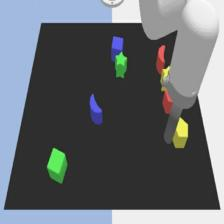
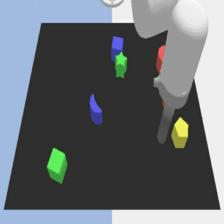
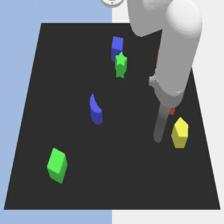
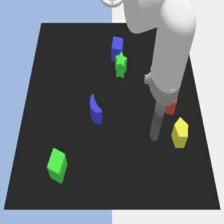

step: 7501/12800   lr: 0.01312   loss: 0.6646
step: 7502/12800   lr: 0.01312   loss: 0.6038
step: 7503/12800   lr: 0.01311   loss: 0.6480
step: 7504/12800   lr: 0.01311   loss: 0.6340
step: 7505/12800   lr: 0.01311   loss: 0.6333
step: 7506/12800   lr: 0.01310   loss: 0.6164
step: 7507/12800   lr: 0.01310   loss: 0.5996
step: 7508/12800   lr: 0.01309   loss: 0.6304
step: 7509/12800   lr: 0.01309   loss: 0.7013
step: 7510/12800   lr: 0.01308   loss: 0.6484
step: 7511/12800   lr: 0.01308   loss: 0.6615
step: 7512/12800   lr: 0.01308   loss: 0.6272
step: 7513/12800   lr: 0.01307   loss: 0.7096
step: 7514/12800   lr: 0.01307   loss: 0.6012
step: 7515/12800   lr: 0.01306   loss: 0.6169
step: 7516/12800   lr: 0.01306   loss: 0.6717
step: 7517/12800   lr: 0.01306   loss: 0.6542
step: 7518/12800   lr: 0.01305   loss: 0.6541
step: 7519/12800   lr: 0.01305   loss: 0.6136
step: 7520/12800   lr: 0.01304   loss: 0.6192
step: 7521/12800   lr: 0.01304   loss: 0.6223
step: 7522/12800   lr: 0.01304   l


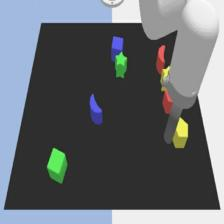
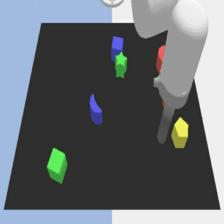
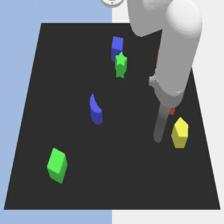
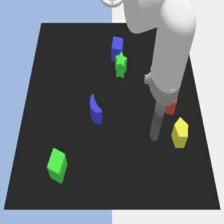

step: 7601/12800   lr: 0.01272   loss: 0.6809
step: 7602/12800   lr: 0.01271   loss: 0.6052
step: 7603/12800   lr: 0.01271   loss: 0.6176
step: 7604/12800   lr: 0.01270   loss: 0.6656
step: 7605/12800   lr: 0.01270   loss: 0.6481
step: 7606/12800   lr: 0.01270   loss: 0.6392
step: 7607/12800   lr: 0.01269   loss: 0.6246
step: 7608/12800   lr: 0.01269   loss: 0.6431
step: 7609/12800   lr: 0.01268   loss: 0.6495
step: 7610/12800   lr: 0.01268   loss: 0.5966
step: 7611/12800   lr: 0.01268   loss: 0.6435
step: 7612/12800   lr: 0.01267   loss: 0.6255
step: 7613/12800   lr: 0.01267   loss: 0.6603
step: 7614/12800   lr: 0.01266   loss: 0.6900
step: 7615/12800   lr: 0.01266   loss: 0.6454
step: 7616/12800   lr: 0.01266   loss: 0.6319
step: 7617/12800   lr: 0.01265   loss: 0.6553
step: 7618/12800   lr: 0.01265   loss: 0.6382
step: 7619/12800   lr: 0.01264   loss: 0.6664
step: 7620/12800   lr: 0.01264   loss: 0.6440
step: 7621/12800   lr: 0.01264   loss: 0.6148
step: 7622/12800   lr: 0.01263   l


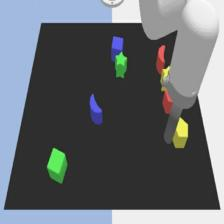
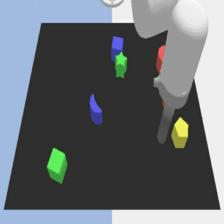
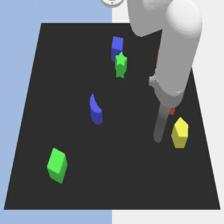
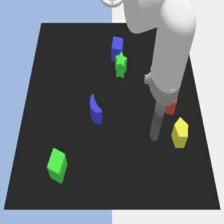

step: 7701/12800   lr: 0.01231   loss: 0.6185
step: 7702/12800   lr: 0.01231   loss: 0.6720
step: 7703/12800   lr: 0.01230   loss: 0.6384
step: 7704/12800   lr: 0.01230   loss: 0.6373
step: 7705/12800   lr: 0.01230   loss: 0.6351
step: 7706/12800   lr: 0.01229   loss: 0.6685
step: 7707/12800   lr: 0.01229   loss: 0.6444
step: 7708/12800   lr: 0.01228   loss: 0.5856
step: 7709/12800   lr: 0.01228   loss: 0.6236
step: 7710/12800   lr: 0.01228   loss: 0.6502
step: 7711/12800   lr: 0.01227   loss: 0.6816
step: 7712/12800   lr: 0.01227   loss: 0.6058
step: 7713/12800   lr: 0.01226   loss: 0.6307
step: 7714/12800   lr: 0.01226   loss: 0.6832
step: 7715/12800   lr: 0.01226   loss: 0.6519
step: 7716/12800   lr: 0.01225   loss: 0.6968
step: 7717/12800   lr: 0.01225   loss: 0.5999
step: 7718/12800   lr: 0.01224   loss: 0.6454
step: 7719/12800   lr: 0.01224   loss: 0.6265
step: 7720/12800   lr: 0.01224   loss: 0.6385
step: 7721/12800   lr: 0.01223   loss: 0.6448
step: 7722/12800   lr: 0.01223   l


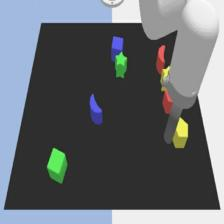
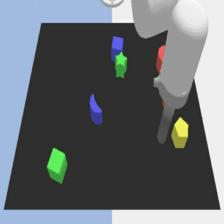
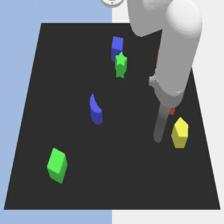
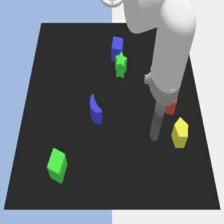

step: 7801/12800   lr: 0.01191   loss: 0.5799
step: 7802/12800   lr: 0.01191   loss: 0.6246
step: 7803/12800   lr: 0.01190   loss: 0.6149
step: 7804/12800   lr: 0.01190   loss: 0.6420
step: 7805/12800   lr: 0.01190   loss: 0.6709
step: 7806/12800   lr: 0.01189   loss: 0.6163
step: 7807/12800   lr: 0.01189   loss: 0.6355
step: 7808/12800   lr: 0.01188   loss: 0.6287
step: 7809/12800   lr: 0.01188   loss: 0.5932
step: 7810/12800   lr: 0.01188   loss: 0.6095
step: 7811/12800   lr: 0.01187   loss: 0.6281
step: 7812/12800   lr: 0.01187   loss: 0.6539
step: 7813/12800   lr: 0.01186   loss: 0.6743
step: 7814/12800   lr: 0.01186   loss: 0.6786
step: 7815/12800   lr: 0.01186   loss: 0.6097
step: 7816/12800   lr: 0.01185   loss: 0.6481
step: 7817/12800   lr: 0.01185   loss: 0.6065
step: 7818/12800   lr: 0.01184   loss: 0.6266
step: 7819/12800   lr: 0.01184   loss: 0.6811
step: 7820/12800   lr: 0.01184   loss: 0.6023
step: 7821/12800   lr: 0.01183   loss: 0.6845
step: 7822/12800   lr: 0.01183   l


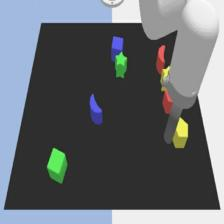
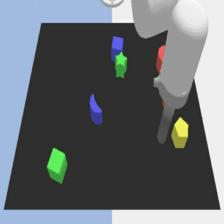
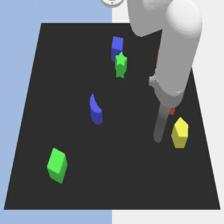
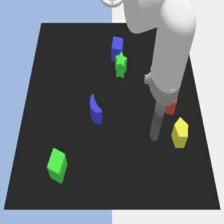

step: 7901/12800   lr: 0.01151   loss: 0.6620
step: 7902/12800   lr: 0.01151   loss: 0.6359
step: 7903/12800   lr: 0.01150   loss: 0.7390
step: 7904/12800   lr: 0.01150   loss: 0.6579
step: 7905/12800   lr: 0.01150   loss: 0.5960
step: 7906/12800   lr: 0.01149   loss: 0.6538
step: 7907/12800   lr: 0.01149   loss: 0.5911
step: 7908/12800   lr: 0.01148   loss: 0.6538
step: 7909/12800   lr: 0.01148   loss: 0.5984
step: 7910/12800   lr: 0.01148   loss: 0.6520
step: 7911/12800   lr: 0.01147   loss: 0.5881
step: 7912/12800   lr: 0.01147   loss: 0.6295
step: 7913/12800   lr: 0.01146   loss: 0.6969
step: 7914/12800   lr: 0.01146   loss: 0.6776
step: 7915/12800   lr: 0.01146   loss: 0.6169
step: 7916/12800   lr: 0.01145   loss: 0.6254
step: 7917/12800   lr: 0.01145   loss: 0.6835
step: 7918/12800   lr: 0.01144   loss: 0.6413
step: 7919/12800   lr: 0.01144   loss: 0.6347
step: 7920/12800   lr: 0.01144   loss: 0.6341
step: 7921/12800   lr: 0.01143   loss: 0.6501
step: 7922/12800   lr: 0.01143   l


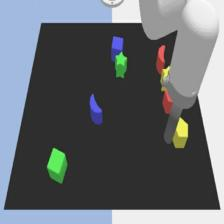
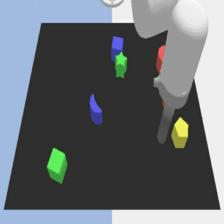
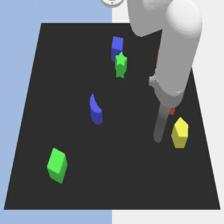
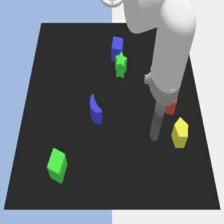

step: 8001/12800   lr: 0.01112   loss: 0.6603
step: 8002/12800   lr: 0.01111   loss: 0.6318
step: 8003/12800   lr: 0.01111   loss: 0.6104
step: 8004/12800   lr: 0.01110   loss: 0.6622
step: 8005/12800   lr: 0.01110   loss: 0.6648
step: 8006/12800   lr: 0.01110   loss: 0.6586
step: 8007/12800   lr: 0.01109   loss: 0.6518
step: 8008/12800   lr: 0.01109   loss: 0.5982
step: 8009/12800   lr: 0.01108   loss: 0.5902
step: 8010/12800   lr: 0.01108   loss: 0.6334
step: 8011/12800   lr: 0.01108   loss: 0.6437
step: 8012/12800   lr: 0.01107   loss: 0.6678
step: 8013/12800   lr: 0.01107   loss: 0.6730
step: 8014/12800   lr: 0.01106   loss: 0.6322
step: 8015/12800   lr: 0.01106   loss: 0.6370
step: 8016/12800   lr: 0.01106   loss: 0.6341
step: 8017/12800   lr: 0.01105   loss: 0.6158
step: 8018/12800   lr: 0.01105   loss: 0.6455
step: 8019/12800   lr: 0.01105   loss: 0.6663
step: 8020/12800   lr: 0.01104   loss: 0.6498
step: 8021/12800   lr: 0.01104   loss: 0.6573
step: 8022/12800   lr: 0.01103   l


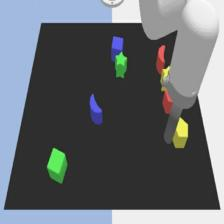
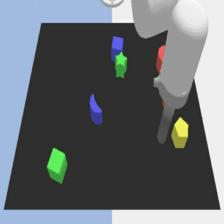
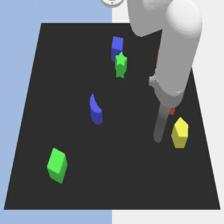
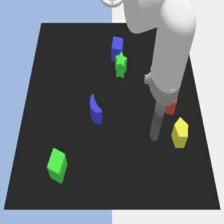

step: 8101/12800   lr: 0.01072   loss: 0.6430
step: 8102/12800   lr: 0.01072   loss: 0.6449
step: 8103/12800   lr: 0.01071   loss: 0.6074
step: 8104/12800   lr: 0.01071   loss: 0.6431
step: 8105/12800   lr: 0.01071   loss: 0.5977
step: 8106/12800   lr: 0.01070   loss: 0.6539
step: 8107/12800   lr: 0.01070   loss: 0.5817
step: 8108/12800   lr: 0.01070   loss: 0.6637
step: 8109/12800   lr: 0.01069   loss: 0.5755
step: 8110/12800   lr: 0.01069   loss: 0.6435
step: 8111/12800   lr: 0.01068   loss: 0.6824
step: 8112/12800   lr: 0.01068   loss: 0.6282
step: 8113/12800   lr: 0.01068   loss: 0.6781
step: 8114/12800   lr: 0.01067   loss: 0.6642
step: 8115/12800   lr: 0.01067   loss: 0.6163
step: 8116/12800   lr: 0.01066   loss: 0.6163
step: 8117/12800   lr: 0.01066   loss: 0.6895
step: 8118/12800   lr: 0.01066   loss: 0.6594
step: 8119/12800   lr: 0.01065   loss: 0.6547
step: 8120/12800   lr: 0.01065   loss: 0.6849
step: 8121/12800   lr: 0.01064   loss: 0.6520
step: 8122/12800   lr: 0.01064   l


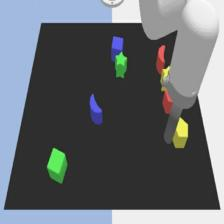
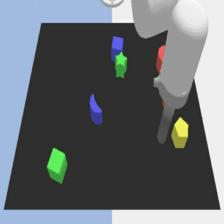
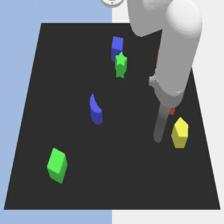
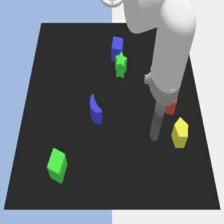

step: 8201/12800   lr: 0.01033   loss: 0.6633
step: 8202/12800   lr: 0.01033   loss: 0.6542
step: 8203/12800   lr: 0.01032   loss: 0.6327
step: 8204/12800   lr: 0.01032   loss: 0.6286
step: 8205/12800   lr: 0.01032   loss: 0.6147
step: 8206/12800   lr: 0.01031   loss: 0.7013
step: 8207/12800   lr: 0.01031   loss: 0.6569
step: 8208/12800   lr: 0.01030   loss: 0.6224
step: 8209/12800   lr: 0.01030   loss: 0.6630
step: 8210/12800   lr: 0.01030   loss: 0.6044
step: 8211/12800   lr: 0.01029   loss: 0.6073
step: 8212/12800   lr: 0.01029   loss: 0.5947
step: 8213/12800   lr: 0.01029   loss: 0.6282
step: 8214/12800   lr: 0.01028   loss: 0.6069
step: 8215/12800   lr: 0.01028   loss: 0.6134
step: 8216/12800   lr: 0.01027   loss: 0.6669
step: 8217/12800   lr: 0.01027   loss: 0.6537
step: 8218/12800   lr: 0.01027   loss: 0.6152
step: 8219/12800   lr: 0.01026   loss: 0.6907
step: 8220/12800   lr: 0.01026   loss: 0.6574
step: 8221/12800   lr: 0.01025   loss: 0.6677
step: 8222/12800   lr: 0.01025   l


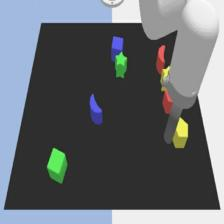
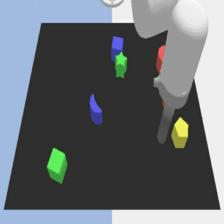
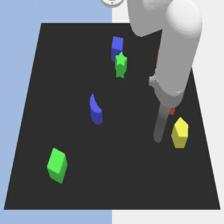
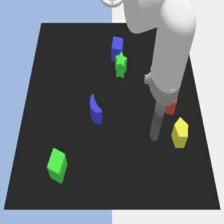

step: 8301/12800   lr: 0.00995   loss: 0.6201
step: 8302/12800   lr: 0.00994   loss: 0.6339
step: 8303/12800   lr: 0.00994   loss: 0.6237
step: 8304/12800   lr: 0.00993   loss: 0.6719
step: 8305/12800   lr: 0.00993   loss: 0.5766
step: 8306/12800   lr: 0.00993   loss: 0.6381
step: 8307/12800   lr: 0.00992   loss: 0.6059
step: 8308/12800   lr: 0.00992   loss: 0.5928
step: 8309/12800   lr: 0.00991   loss: 0.6212
step: 8310/12800   lr: 0.00991   loss: 0.6193
step: 8311/12800   lr: 0.00991   loss: 0.6462
step: 8312/12800   lr: 0.00990   loss: 0.6500
step: 8313/12800   lr: 0.00990   loss: 0.6634
step: 8314/12800   lr: 0.00990   loss: 0.6446
step: 8315/12800   lr: 0.00989   loss: 0.6328
step: 8316/12800   lr: 0.00989   loss: 0.6246
step: 8317/12800   lr: 0.00988   loss: 0.6727
step: 8318/12800   lr: 0.00988   loss: 0.6697
step: 8319/12800   lr: 0.00988   loss: 0.6821
step: 8320/12800   lr: 0.00987   loss: 0.6238
step: 8321/12800   lr: 0.00987   loss: 0.6056
step: 8322/12800   lr: 0.00986   l


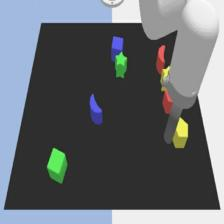
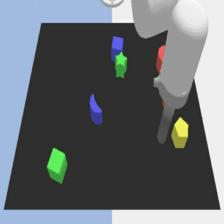
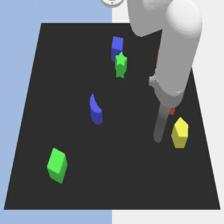
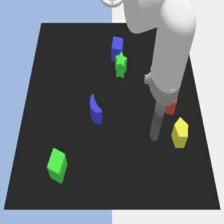

step: 8401/12800   lr: 0.00956   loss: 0.6633
step: 8402/12800   lr: 0.00956   loss: 0.6206
step: 8403/12800   lr: 0.00955   loss: 0.6201
step: 8404/12800   lr: 0.00955   loss: 0.6611
step: 8405/12800   lr: 0.00955   loss: 0.6650
step: 8406/12800   lr: 0.00954   loss: 0.6213
step: 8407/12800   lr: 0.00954   loss: 0.6401
step: 8408/12800   lr: 0.00954   loss: 0.6787
step: 8409/12800   lr: 0.00953   loss: 0.6840
step: 8410/12800   lr: 0.00953   loss: 0.5723
step: 8411/12800   lr: 0.00952   loss: 0.5785
step: 8412/12800   lr: 0.00952   loss: 0.6729
step: 8413/12800   lr: 0.00952   loss: 0.6310
step: 8414/12800   lr: 0.00951   loss: 0.6285
step: 8415/12800   lr: 0.00951   loss: 0.6527
step: 8416/12800   lr: 0.00950   loss: 0.6595
step: 8417/12800   lr: 0.00950   loss: 0.5971
step: 8418/12800   lr: 0.00950   loss: 0.5957
step: 8419/12800   lr: 0.00949   loss: 0.6465
step: 8420/12800   lr: 0.00949   loss: 0.5745
step: 8421/12800   lr: 0.00949   loss: 0.6205
step: 8422/12800   lr: 0.00948   l


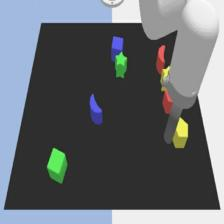
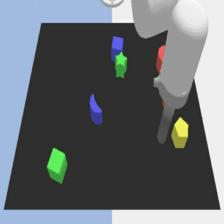
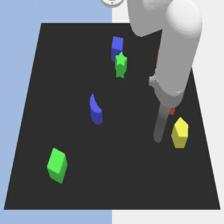
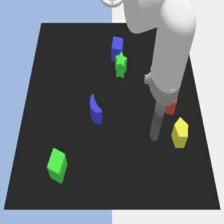

step: 8501/12800   lr: 0.00918   loss: 0.6137
step: 8502/12800   lr: 0.00918   loss: 0.6609
step: 8503/12800   lr: 0.00918   loss: 0.6025
step: 8504/12800   lr: 0.00917   loss: 0.6454
step: 8505/12800   lr: 0.00917   loss: 0.6330
step: 8506/12800   lr: 0.00916   loss: 0.5998
step: 8507/12800   lr: 0.00916   loss: 0.6368
step: 8508/12800   lr: 0.00916   loss: 0.6807
step: 8509/12800   lr: 0.00915   loss: 0.6470
step: 8510/12800   lr: 0.00915   loss: 0.6068
step: 8511/12800   lr: 0.00915   loss: 0.6345
step: 8512/12800   lr: 0.00914   loss: 0.6287
step: 8513/12800   lr: 0.00914   loss: 0.6565
step: 8514/12800   lr: 0.00913   loss: 0.6131
step: 8515/12800   lr: 0.00913   loss: 0.6295
step: 8516/12800   lr: 0.00913   loss: 0.5997
step: 8517/12800   lr: 0.00912   loss: 0.6078
step: 8518/12800   lr: 0.00912   loss: 0.6374
step: 8519/12800   lr: 0.00912   loss: 0.6382
step: 8520/12800   lr: 0.00911   loss: 0.6311
step: 8521/12800   lr: 0.00911   loss: 0.6030
step: 8522/12800   lr: 0.00910   l


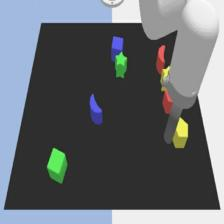
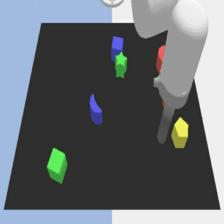
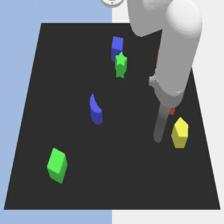
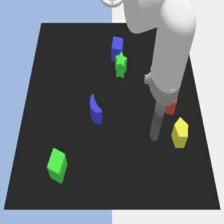

step: 8601/12800   lr: 0.00881   loss: 0.6300
step: 8602/12800   lr: 0.00880   loss: 0.6455
step: 8603/12800   lr: 0.00880   loss: 0.6162
step: 8604/12800   lr: 0.00880   loss: 0.6107
step: 8605/12800   lr: 0.00879   loss: 0.5911
step: 8606/12800   lr: 0.00879   loss: 0.6264
step: 8607/12800   lr: 0.00879   loss: 0.6355
step: 8608/12800   lr: 0.00878   loss: 0.6137
step: 8609/12800   lr: 0.00878   loss: 0.6071
step: 8610/12800   lr: 0.00877   loss: 0.6000
step: 8611/12800   lr: 0.00877   loss: 0.6917
step: 8612/12800   lr: 0.00877   loss: 0.6850
step: 8613/12800   lr: 0.00876   loss: 0.6172
step: 8614/12800   lr: 0.00876   loss: 0.7116
step: 8615/12800   lr: 0.00876   loss: 0.6280
step: 8616/12800   lr: 0.00875   loss: 0.6528
step: 8617/12800   lr: 0.00875   loss: 0.6351
step: 8618/12800   lr: 0.00874   loss: 0.6553
step: 8619/12800   lr: 0.00874   loss: 0.6282
step: 8620/12800   lr: 0.00874   loss: 0.6087
step: 8621/12800   lr: 0.00873   loss: 0.6544
step: 8622/12800   lr: 0.00873   l


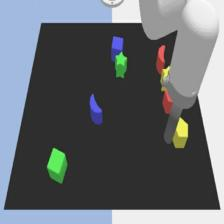
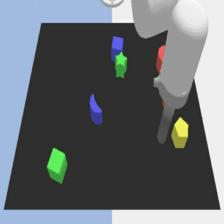
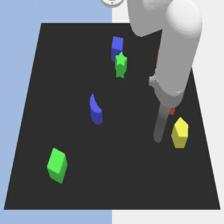
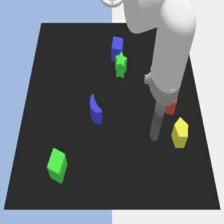

step: 8701/12800   lr: 0.00844   loss: 0.6071
step: 8702/12800   lr: 0.00843   loss: 0.6527
step: 8703/12800   lr: 0.00843   loss: 0.6091
step: 8704/12800   lr: 0.00843   loss: 0.5478
step: 8705/12800   lr: 0.00842   loss: 0.6367
step: 8706/12800   lr: 0.00842   loss: 0.5939
step: 8707/12800   lr: 0.00842   loss: 0.6327
step: 8708/12800   lr: 0.00841   loss: 0.5958
step: 8709/12800   lr: 0.00841   loss: 0.6265
step: 8710/12800   lr: 0.00840   loss: 0.6831
step: 8711/12800   lr: 0.00840   loss: 0.6378
step: 8712/12800   lr: 0.00840   loss: 0.6467
step: 8713/12800   lr: 0.00839   loss: 0.6601
step: 8714/12800   lr: 0.00839   loss: 0.6325
step: 8715/12800   lr: 0.00839   loss: 0.5943
step: 8716/12800   lr: 0.00838   loss: 0.6344
step: 8717/12800   lr: 0.00838   loss: 0.5950
step: 8718/12800   lr: 0.00838   loss: 0.6271
step: 8719/12800   lr: 0.00837   loss: 0.6102
step: 8720/12800   lr: 0.00837   loss: 0.6756
step: 8721/12800   lr: 0.00836   loss: 0.7088
step: 8722/12800   lr: 0.00836   l


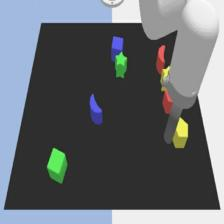
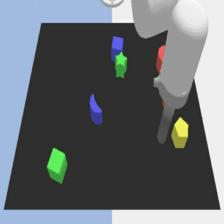
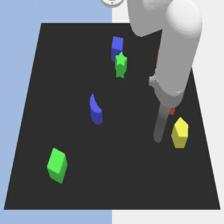
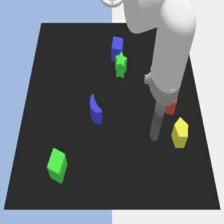

step: 8801/12800   lr: 0.00807   loss: 0.6095
step: 8802/12800   lr: 0.00807   loss: 0.6387
step: 8803/12800   lr: 0.00807   loss: 0.6085
step: 8804/12800   lr: 0.00806   loss: 0.6260
step: 8805/12800   lr: 0.00806   loss: 0.6195
step: 8806/12800   lr: 0.00805   loss: 0.6512
step: 8807/12800   lr: 0.00805   loss: 0.6596
step: 8808/12800   lr: 0.00805   loss: 0.6195
step: 8809/12800   lr: 0.00804   loss: 0.6388
step: 8810/12800   lr: 0.00804   loss: 0.6364
step: 8811/12800   lr: 0.00804   loss: 0.6724
step: 8812/12800   lr: 0.00803   loss: 0.5941
step: 8813/12800   lr: 0.00803   loss: 0.6045
step: 8814/12800   lr: 0.00803   loss: 0.6572
step: 8815/12800   lr: 0.00802   loss: 0.6308
step: 8816/12800   lr: 0.00802   loss: 0.5914
step: 8817/12800   lr: 0.00801   loss: 0.6515
step: 8818/12800   lr: 0.00801   loss: 0.6507
step: 8819/12800   lr: 0.00801   loss: 0.6756
step: 8820/12800   lr: 0.00800   loss: 0.6569
step: 8821/12800   lr: 0.00800   loss: 0.6651
step: 8822/12800   lr: 0.00800   l


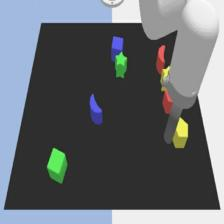
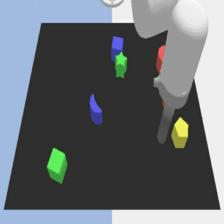
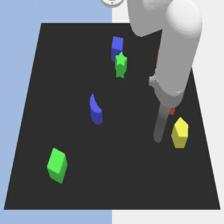
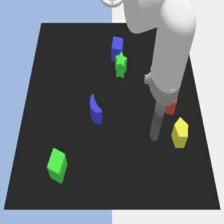

step: 8901/12800   lr: 0.00771   loss: 0.6073
step: 8902/12800   lr: 0.00771   loss: 0.6492
step: 8903/12800   lr: 0.00771   loss: 0.6650
step: 8904/12800   lr: 0.00770   loss: 0.6055
step: 8905/12800   lr: 0.00770   loss: 0.5642
step: 8906/12800   lr: 0.00769   loss: 0.6601
step: 8907/12800   lr: 0.00769   loss: 0.6259
step: 8908/12800   lr: 0.00769   loss: 0.6566
step: 8909/12800   lr: 0.00768   loss: 0.6468
step: 8910/12800   lr: 0.00768   loss: 0.5691
step: 8911/12800   lr: 0.00768   loss: 0.6395
step: 8912/12800   lr: 0.00767   loss: 0.6335
step: 8913/12800   lr: 0.00767   loss: 0.6342
step: 8914/12800   lr: 0.00767   loss: 0.6242
step: 8915/12800   lr: 0.00766   loss: 0.6917
step: 8916/12800   lr: 0.00766   loss: 0.5816
step: 8917/12800   lr: 0.00766   loss: 0.6425
step: 8918/12800   lr: 0.00765   loss: 0.6461
step: 8919/12800   lr: 0.00765   loss: 0.6542
step: 8920/12800   lr: 0.00764   loss: 0.6273
step: 8921/12800   lr: 0.00764   loss: 0.6226
step: 8922/12800   lr: 0.00764   l


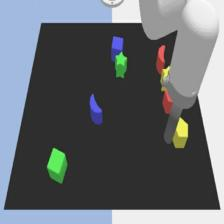
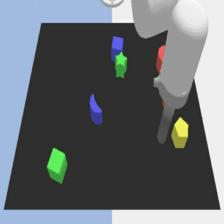
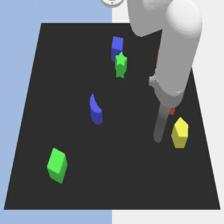
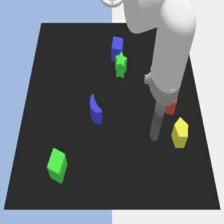

step: 9001/12800   lr: 0.00736   loss: 0.6905
step: 9002/12800   lr: 0.00735   loss: 0.5992
step: 9003/12800   lr: 0.00735   loss: 0.6523
step: 9004/12800   lr: 0.00735   loss: 0.6313
step: 9005/12800   lr: 0.00734   loss: 0.6303
step: 9006/12800   lr: 0.00734   loss: 0.6196
step: 9007/12800   lr: 0.00734   loss: 0.6493
step: 9008/12800   lr: 0.00733   loss: 0.6051
step: 9009/12800   lr: 0.00733   loss: 0.6781
step: 9010/12800   lr: 0.00733   loss: 0.5729
step: 9011/12800   lr: 0.00732   loss: 0.6328
step: 9012/12800   lr: 0.00732   loss: 0.6661
step: 9013/12800   lr: 0.00732   loss: 0.6269
step: 9014/12800   lr: 0.00731   loss: 0.6441
step: 9015/12800   lr: 0.00731   loss: 0.6482
step: 9016/12800   lr: 0.00730   loss: 0.5683
step: 9017/12800   lr: 0.00730   loss: 0.5889
step: 9018/12800   lr: 0.00730   loss: 0.6539
step: 9019/12800   lr: 0.00729   loss: 0.6817
step: 9020/12800   lr: 0.00729   loss: 0.6462
step: 9021/12800   lr: 0.00729   loss: 0.5848
step: 9022/12800   lr: 0.00728   l


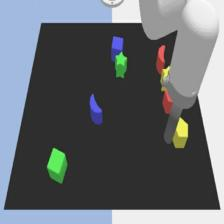
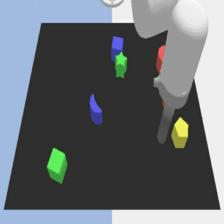
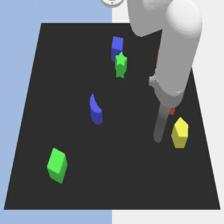
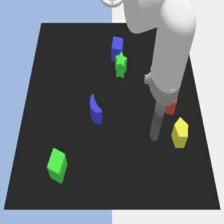

step: 9101/12800   lr: 0.00701   loss: 0.6391
step: 9102/12800   lr: 0.00701   loss: 0.6236
step: 9103/12800   lr: 0.00700   loss: 0.6229
step: 9104/12800   lr: 0.00700   loss: 0.6654
step: 9105/12800   lr: 0.00699   loss: 0.5931
step: 9106/12800   lr: 0.00699   loss: 0.5625
step: 9107/12800   lr: 0.00699   loss: 0.6381
step: 9108/12800   lr: 0.00698   loss: 0.5990
step: 9109/12800   lr: 0.00698   loss: 0.5828
step: 9110/12800   lr: 0.00698   loss: 0.6142
step: 9111/12800   lr: 0.00697   loss: 0.5699
step: 9112/12800   lr: 0.00697   loss: 0.6579
step: 9113/12800   lr: 0.00697   loss: 0.6143
step: 9114/12800   lr: 0.00696   loss: 0.6652
step: 9115/12800   lr: 0.00696   loss: 0.6656
step: 9116/12800   lr: 0.00696   loss: 0.6269
step: 9117/12800   lr: 0.00695   loss: 0.6543
step: 9118/12800   lr: 0.00695   loss: 0.5827
step: 9119/12800   lr: 0.00695   loss: 0.6046
step: 9120/12800   lr: 0.00694   loss: 0.6393
step: 9121/12800   lr: 0.00694   loss: 0.6342
step: 9122/12800   lr: 0.00694   l


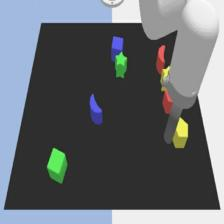
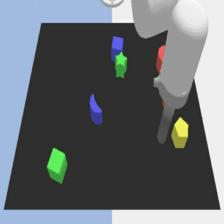
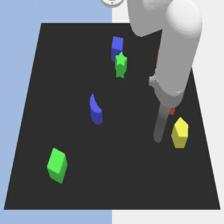
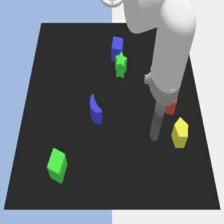

step: 9201/12800   lr: 0.00667   loss: 0.5964
step: 9202/12800   lr: 0.00666   loss: 0.6043
step: 9203/12800   lr: 0.00666   loss: 0.6125
step: 9204/12800   lr: 0.00666   loss: 0.5839
step: 9205/12800   lr: 0.00665   loss: 0.6073
step: 9206/12800   lr: 0.00665   loss: 0.6883
step: 9207/12800   lr: 0.00664   loss: 0.6049
step: 9208/12800   lr: 0.00664   loss: 0.6195
step: 9209/12800   lr: 0.00664   loss: 0.6475
step: 9210/12800   lr: 0.00663   loss: 0.5996
step: 9211/12800   lr: 0.00663   loss: 0.6520
step: 9212/12800   lr: 0.00663   loss: 0.6286
step: 9213/12800   lr: 0.00662   loss: 0.6671
step: 9214/12800   lr: 0.00662   loss: 0.5884
step: 9215/12800   lr: 0.00662   loss: 0.6484
step: 9216/12800   lr: 0.00661   loss: 0.6711
step: 9217/12800   lr: 0.00661   loss: 0.6080
step: 9218/12800   lr: 0.00661   loss: 0.6321
step: 9219/12800   lr: 0.00660   loss: 0.6397
step: 9220/12800   lr: 0.00660   loss: 0.6189
step: 9221/12800   lr: 0.00660   loss: 0.6610
step: 9222/12800   lr: 0.00659   l


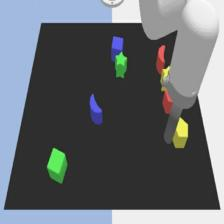
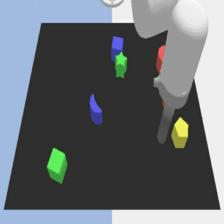
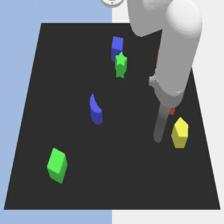
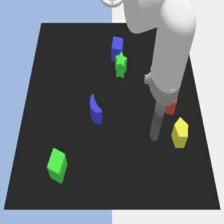

step: 9301/12800   lr: 0.00633   loss: 0.6046
step: 9302/12800   lr: 0.00633   loss: 0.6330
step: 9303/12800   lr: 0.00632   loss: 0.6433
step: 9304/12800   lr: 0.00632   loss: 0.6095
step: 9305/12800   lr: 0.00632   loss: 0.6842
step: 9306/12800   lr: 0.00631   loss: 0.6604
step: 9307/12800   lr: 0.00631   loss: 0.6250
step: 9308/12800   lr: 0.00631   loss: 0.6446
step: 9309/12800   lr: 0.00630   loss: 0.6523
step: 9310/12800   lr: 0.00630   loss: 0.5587
step: 9311/12800   lr: 0.00630   loss: 0.5353
step: 9312/12800   lr: 0.00629   loss: 0.6151
step: 9313/12800   lr: 0.00629   loss: 0.5548
step: 9314/12800   lr: 0.00629   loss: 0.5977
step: 9315/12800   lr: 0.00628   loss: 0.6330
step: 9316/12800   lr: 0.00628   loss: 0.6403
step: 9317/12800   lr: 0.00628   loss: 0.6356
step: 9318/12800   lr: 0.00627   loss: 0.6653
step: 9319/12800   lr: 0.00627   loss: 0.6480
step: 9320/12800   lr: 0.00627   loss: 0.5815
step: 9321/12800   lr: 0.00626   loss: 0.6878
step: 9322/12800   lr: 0.00626   l


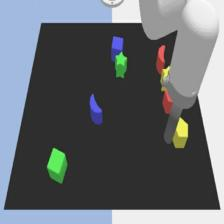
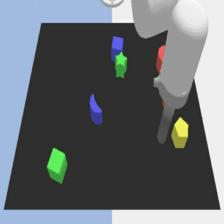
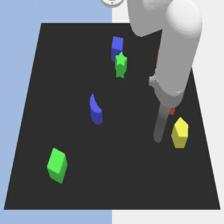
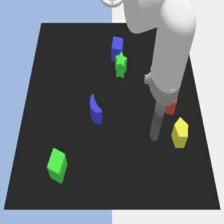

step: 9401/12800   lr: 0.00600   loss: 0.6583
step: 9402/12800   lr: 0.00599   loss: 0.6306
step: 9403/12800   lr: 0.00599   loss: 0.6010
step: 9404/12800   lr: 0.00599   loss: 0.6665
step: 9405/12800   lr: 0.00598   loss: 0.6284
step: 9406/12800   lr: 0.00598   loss: 0.6071
step: 9407/12800   lr: 0.00598   loss: 0.6441
step: 9408/12800   lr: 0.00598   loss: 0.6818
step: 9409/12800   lr: 0.00597   loss: 0.6529
step: 9410/12800   lr: 0.00597   loss: 0.6743
step: 9411/12800   lr: 0.00597   loss: 0.6523
step: 9412/12800   lr: 0.00596   loss: 0.6764
step: 9413/12800   lr: 0.00596   loss: 0.6689
step: 9414/12800   lr: 0.00596   loss: 0.6327
step: 9415/12800   lr: 0.00595   loss: 0.6523
step: 9416/12800   lr: 0.00595   loss: 0.6221
step: 9417/12800   lr: 0.00595   loss: 0.6503
step: 9418/12800   lr: 0.00594   loss: 0.6067
step: 9419/12800   lr: 0.00594   loss: 0.6558
step: 9420/12800   lr: 0.00594   loss: 0.6490
step: 9421/12800   lr: 0.00593   loss: 0.6014
step: 9422/12800   lr: 0.00593   l


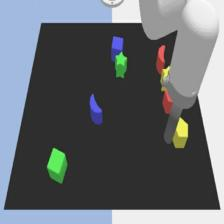
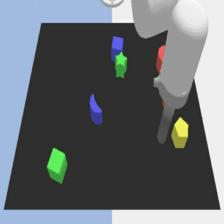
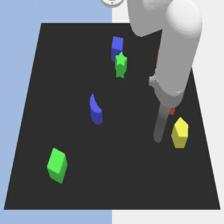
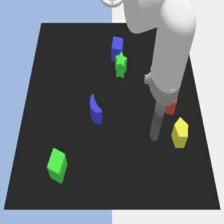

step: 9501/12800   lr: 0.00567   loss: 0.6386
step: 9502/12800   lr: 0.00567   loss: 0.6498
step: 9503/12800   lr: 0.00567   loss: 0.6226
step: 9504/12800   lr: 0.00566   loss: 0.6192
step: 9505/12800   lr: 0.00566   loss: 0.6118
step: 9506/12800   lr: 0.00566   loss: 0.6123
step: 9507/12800   lr: 0.00565   loss: 0.6750
step: 9508/12800   lr: 0.00565   loss: 0.6121
step: 9509/12800   lr: 0.00565   loss: 0.6705
step: 9510/12800   lr: 0.00565   loss: 0.6087
step: 9511/12800   lr: 0.00564   loss: 0.5979
step: 9512/12800   lr: 0.00564   loss: 0.6346
step: 9513/12800   lr: 0.00564   loss: 0.5899
step: 9514/12800   lr: 0.00563   loss: 0.6560
step: 9515/12800   lr: 0.00563   loss: 0.6362
step: 9516/12800   lr: 0.00563   loss: 0.6520
step: 9517/12800   lr: 0.00562   loss: 0.6267
step: 9518/12800   lr: 0.00562   loss: 0.5881
step: 9519/12800   lr: 0.00562   loss: 0.5093
step: 9520/12800   lr: 0.00561   loss: 0.6163
step: 9521/12800   lr: 0.00561   loss: 0.6359
step: 9522/12800   lr: 0.00561   l


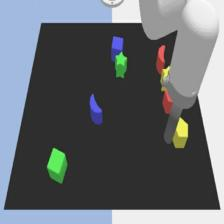
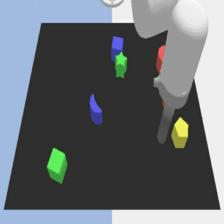
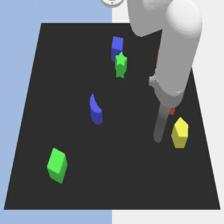
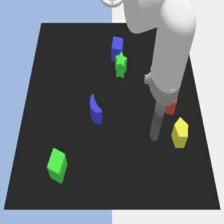

step: 9601/12800   lr: 0.00536   loss: 0.6173
step: 9602/12800   lr: 0.00535   loss: 0.6599
step: 9603/12800   lr: 0.00535   loss: 0.6287
step: 9604/12800   lr: 0.00535   loss: 0.6102
step: 9605/12800   lr: 0.00534   loss: 0.6361
step: 9606/12800   lr: 0.00534   loss: 0.6457
step: 9607/12800   lr: 0.00534   loss: 0.6789
step: 9608/12800   lr: 0.00534   loss: 0.6222
step: 9609/12800   lr: 0.00533   loss: 0.6357
step: 9610/12800   lr: 0.00533   loss: 0.6161
step: 9611/12800   lr: 0.00533   loss: 0.6592
step: 9612/12800   lr: 0.00532   loss: 0.6385
step: 9613/12800   lr: 0.00532   loss: 0.5696
step: 9614/12800   lr: 0.00532   loss: 0.6268
step: 9615/12800   lr: 0.00531   loss: 0.6416
step: 9616/12800   lr: 0.00531   loss: 0.6410
step: 9617/12800   lr: 0.00531   loss: 0.6560
step: 9618/12800   lr: 0.00530   loss: 0.5490
step: 9619/12800   lr: 0.00530   loss: 0.6411
step: 9620/12800   lr: 0.00530   loss: 0.5936
step: 9621/12800   lr: 0.00529   loss: 0.6368
step: 9622/12800   lr: 0.00529   l


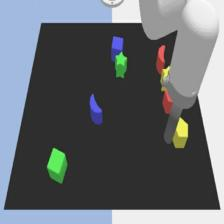
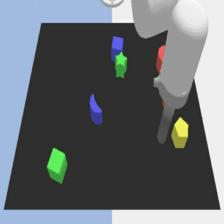
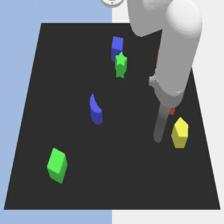
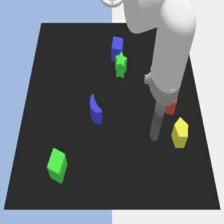

step: 9701/12800   lr: 0.00505   loss: 0.6248
step: 9702/12800   lr: 0.00504   loss: 0.5970
step: 9703/12800   lr: 0.00504   loss: 0.6438
step: 9704/12800   lr: 0.00504   loss: 0.6516
step: 9705/12800   lr: 0.00504   loss: 0.6177
step: 9706/12800   lr: 0.00503   loss: 0.6548
step: 9707/12800   lr: 0.00503   loss: 0.6375
step: 9708/12800   lr: 0.00503   loss: 0.5644
step: 9709/12800   lr: 0.00502   loss: 0.6292
step: 9710/12800   lr: 0.00502   loss: 0.5621
step: 9711/12800   lr: 0.00502   loss: 0.6036
step: 9712/12800   lr: 0.00501   loss: 0.6159
step: 9713/12800   lr: 0.00501   loss: 0.6080
step: 9714/12800   lr: 0.00501   loss: 0.6346
step: 9715/12800   lr: 0.00500   loss: 0.5555
step: 9716/12800   lr: 0.00500   loss: 0.6422
step: 9717/12800   lr: 0.00500   loss: 0.6908
step: 9718/12800   lr: 0.00500   loss: 0.6610
step: 9719/12800   lr: 0.00499   loss: 0.6222
step: 9720/12800   lr: 0.00499   loss: 0.7106
step: 9721/12800   lr: 0.00499   loss: 0.6180
step: 9722/12800   lr: 0.00498   l


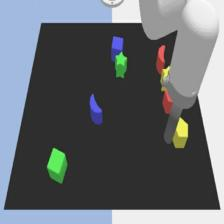
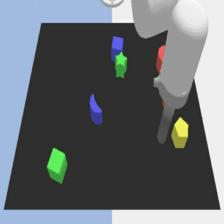
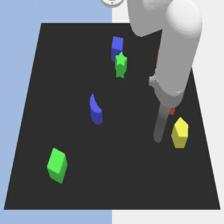
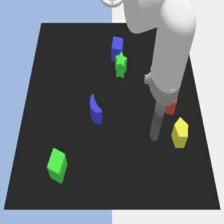

step: 9801/12800   lr: 0.00475   loss: 0.6482
step: 9802/12800   lr: 0.00474   loss: 0.6299
step: 9803/12800   lr: 0.00474   loss: 0.6711
step: 9804/12800   lr: 0.00474   loss: 0.6186
step: 9805/12800   lr: 0.00473   loss: 0.6259
step: 9806/12800   lr: 0.00473   loss: 0.6328
step: 9807/12800   lr: 0.00473   loss: 0.5946
step: 9808/12800   lr: 0.00472   loss: 0.6757
step: 9809/12800   lr: 0.00472   loss: 0.6504
step: 9810/12800   lr: 0.00472   loss: 0.5986
step: 9811/12800   lr: 0.00472   loss: 0.6599
step: 9812/12800   lr: 0.00471   loss: 0.6303
step: 9813/12800   lr: 0.00471   loss: 0.6907
step: 9814/12800   lr: 0.00471   loss: 0.6248
step: 9815/12800   lr: 0.00470   loss: 0.6813
step: 9816/12800   lr: 0.00470   loss: 0.6595
step: 9817/12800   lr: 0.00470   loss: 0.6618
step: 9818/12800   lr: 0.00469   loss: 0.6292
step: 9819/12800   lr: 0.00469   loss: 0.6285
step: 9820/12800   lr: 0.00469   loss: 0.6697
step: 9821/12800   lr: 0.00469   loss: 0.6287
step: 9822/12800   lr: 0.00468   l


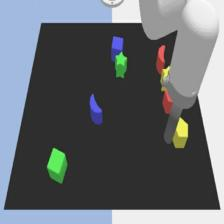
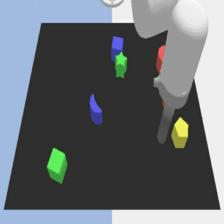
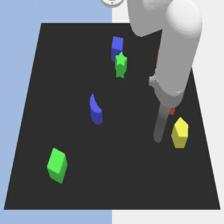
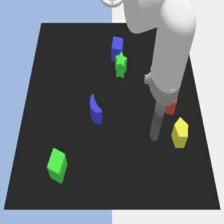

step: 9901/12800   lr: 0.00445   loss: 0.5988
step: 9902/12800   lr: 0.00445   loss: 0.6311
step: 9903/12800   lr: 0.00444   loss: 0.6274
step: 9904/12800   lr: 0.00444   loss: 0.6409
step: 9905/12800   lr: 0.00444   loss: 0.6659
step: 9906/12800   lr: 0.00444   loss: 0.6556
step: 9907/12800   lr: 0.00443   loss: 0.6419
step: 9908/12800   lr: 0.00443   loss: 0.6172
step: 9909/12800   lr: 0.00443   loss: 0.6414
step: 9910/12800   lr: 0.00442   loss: 0.5985
step: 9911/12800   lr: 0.00442   loss: 0.6421
step: 9912/12800   lr: 0.00442   loss: 0.5397
step: 9913/12800   lr: 0.00442   loss: 0.6487
step: 9914/12800   lr: 0.00441   loss: 0.6768
step: 9915/12800   lr: 0.00441   loss: 0.6582
step: 9916/12800   lr: 0.00441   loss: 0.5857
step: 9917/12800   lr: 0.00440   loss: 0.5857
step: 9918/12800   lr: 0.00440   loss: 0.6481
step: 9919/12800   lr: 0.00440   loss: 0.6340
step: 9920/12800   lr: 0.00440   loss: 0.6155
step: 9921/12800   lr: 0.00439   loss: 0.6687
step: 9922/12800   lr: 0.00439   l


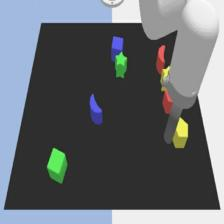
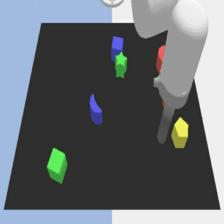
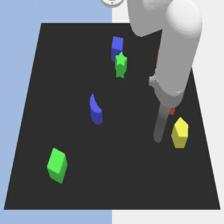
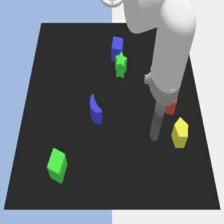

step: 10001/12800   lr: 0.00416   loss: 0.6136
step: 10002/12800   lr: 0.00416   loss: 0.6340
step: 10003/12800   lr: 0.00416   loss: 0.6370
step: 10004/12800   lr: 0.00416   loss: 0.6244
step: 10005/12800   lr: 0.00415   loss: 0.6015
step: 10006/12800   lr: 0.00415   loss: 0.6445
step: 10007/12800   lr: 0.00415   loss: 0.6562
step: 10008/12800   lr: 0.00414   loss: 0.5619
step: 10009/12800   lr: 0.00414   loss: 0.6545
step: 10010/12800   lr: 0.00414   loss: 0.5951
step: 10011/12800   lr: 0.00414   loss: 0.6271
step: 10012/12800   lr: 0.00413   loss: 0.5988
step: 10013/12800   lr: 0.00413   loss: 0.6373
step: 10014/12800   lr: 0.00413   loss: 0.6334
step: 10015/12800   lr: 0.00412   loss: 0.6487
step: 10016/12800   lr: 0.00412   loss: 0.6480
step: 10017/12800   lr: 0.00412   loss: 0.6476
step: 10018/12800   lr: 0.00412   loss: 0.6595
step: 10019/12800   lr: 0.00411   loss: 0.6116
step: 10020/12800   lr: 0.00411   loss: 0.6521
step: 10021/12800   lr: 0.00411   loss: 0.6442
step: 10022/1


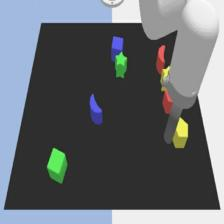
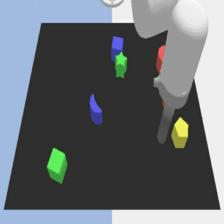
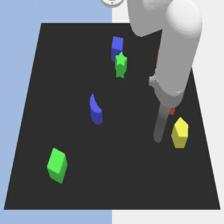
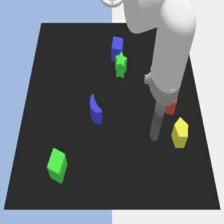

step: 10101/12800   lr: 0.00389   loss: 0.6656
step: 10102/12800   lr: 0.00388   loss: 0.6263
step: 10103/12800   lr: 0.00388   loss: 0.6464
step: 10104/12800   lr: 0.00388   loss: 0.6457
step: 10105/12800   lr: 0.00387   loss: 0.6674
step: 10106/12800   lr: 0.00387   loss: 0.6056
step: 10107/12800   lr: 0.00387   loss: 0.6452
step: 10108/12800   lr: 0.00387   loss: 0.6585
step: 10109/12800   lr: 0.00386   loss: 0.6210
step: 10110/12800   lr: 0.00386   loss: 0.6131
step: 10111/12800   lr: 0.00386   loss: 0.6642
step: 10112/12800   lr: 0.00385   loss: 0.6485
step: 10113/12800   lr: 0.00385   loss: 0.6337
step: 10114/12800   lr: 0.00385   loss: 0.6374
step: 10115/12800   lr: 0.00385   loss: 0.6291
step: 10116/12800   lr: 0.00384   loss: 0.5883
step: 10117/12800   lr: 0.00384   loss: 0.6284
step: 10118/12800   lr: 0.00384   loss: 0.5758
step: 10119/12800   lr: 0.00384   loss: 0.6484
step: 10120/12800   lr: 0.00383   loss: 0.6491
step: 10121/12800   lr: 0.00383   loss: 0.6475
step: 10122/1


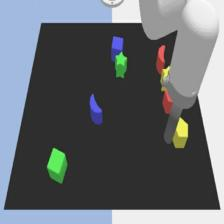
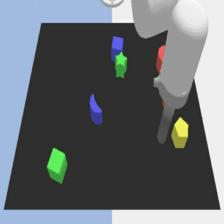
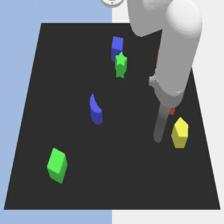
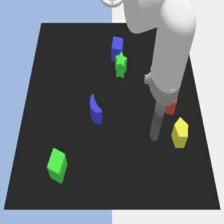

step: 10201/12800   lr: 0.00361   loss: 0.6187
step: 10202/12800   lr: 0.00361   loss: 0.6546
step: 10203/12800   lr: 0.00361   loss: 0.6747
step: 10204/12800   lr: 0.00361   loss: 0.6391
step: 10205/12800   lr: 0.00360   loss: 0.6257
step: 10206/12800   lr: 0.00360   loss: 0.5668
step: 10207/12800   lr: 0.00360   loss: 0.6312
step: 10208/12800   lr: 0.00360   loss: 0.5903
step: 10209/12800   lr: 0.00359   loss: 0.6396
step: 10210/12800   lr: 0.00359   loss: 0.6419
step: 10211/12800   lr: 0.00359   loss: 0.6370
step: 10212/12800   lr: 0.00359   loss: 0.6464
step: 10213/12800   lr: 0.00358   loss: 0.6155
step: 10214/12800   lr: 0.00358   loss: 0.5186
step: 10215/12800   lr: 0.00358   loss: 0.6354
step: 10216/12800   lr: 0.00357   loss: 0.6505
step: 10217/12800   lr: 0.00357   loss: 0.6273
step: 10218/12800   lr: 0.00357   loss: 0.5985
step: 10219/12800   lr: 0.00357   loss: 0.6636
step: 10220/12800   lr: 0.00356   loss: 0.6005
step: 10221/12800   lr: 0.00356   loss: 0.6514
step: 10222/1


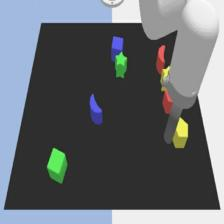
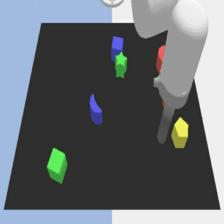
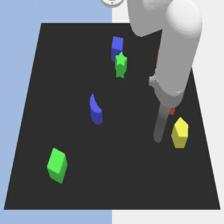
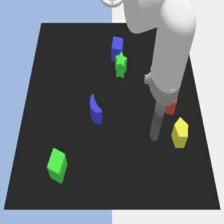

step: 10301/12800   lr: 0.00335   loss: 0.6512
step: 10302/12800   lr: 0.00335   loss: 0.6176
step: 10303/12800   lr: 0.00335   loss: 0.6230
step: 10304/12800   lr: 0.00334   loss: 0.6205
step: 10305/12800   lr: 0.00334   loss: 0.6364
step: 10306/12800   lr: 0.00334   loss: 0.6391
step: 10307/12800   lr: 0.00334   loss: 0.6138
step: 10308/12800   lr: 0.00333   loss: 0.6614
step: 10309/12800   lr: 0.00333   loss: 0.6681
step: 10310/12800   lr: 0.00333   loss: 0.6041
step: 10311/12800   lr: 0.00333   loss: 0.6301
step: 10312/12800   lr: 0.00332   loss: 0.6449
step: 10313/12800   lr: 0.00332   loss: 0.6288
step: 10314/12800   lr: 0.00332   loss: 0.6683
step: 10315/12800   lr: 0.00332   loss: 0.6635
step: 10316/12800   lr: 0.00331   loss: 0.6485
step: 10317/12800   lr: 0.00331   loss: 0.6373
step: 10318/12800   lr: 0.00331   loss: 0.5825
step: 10319/12800   lr: 0.00331   loss: 0.6591
step: 10320/12800   lr: 0.00330   loss: 0.6279
step: 10321/12800   lr: 0.00330   loss: 0.6369
step: 10322/1


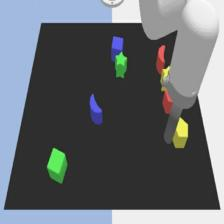
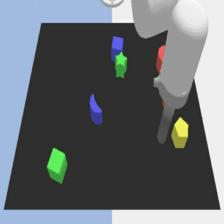
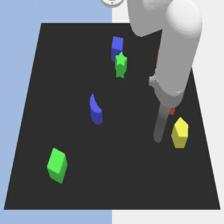
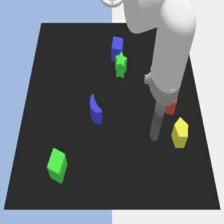

step: 10401/12800   lr: 0.00310   loss: 0.6294
step: 10402/12800   lr: 0.00310   loss: 0.6739
step: 10403/12800   lr: 0.00309   loss: 0.5826
step: 10404/12800   lr: 0.00309   loss: 0.6178
step: 10405/12800   lr: 0.00309   loss: 0.6256
step: 10406/12800   lr: 0.00309   loss: 0.6010
step: 10407/12800   lr: 0.00308   loss: 0.6212
step: 10408/12800   lr: 0.00308   loss: 0.6227
step: 10409/12800   lr: 0.00308   loss: 0.6582
step: 10410/12800   lr: 0.00308   loss: 0.5880
step: 10411/12800   lr: 0.00307   loss: 0.6137
step: 10412/12800   lr: 0.00307   loss: 0.6285
step: 10413/12800   lr: 0.00307   loss: 0.6282
step: 10414/12800   lr: 0.00307   loss: 0.5847
step: 10415/12800   lr: 0.00306   loss: 0.6860
step: 10416/12800   lr: 0.00306   loss: 0.6716
step: 10417/12800   lr: 0.00306   loss: 0.6042
step: 10418/12800   lr: 0.00306   loss: 0.5915
step: 10419/12800   lr: 0.00305   loss: 0.6785
step: 10420/12800   lr: 0.00305   loss: 0.6407
step: 10421/12800   lr: 0.00305   loss: 0.6435
step: 10422/1


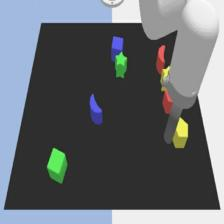
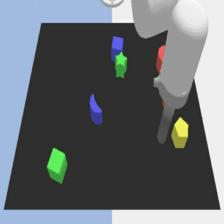
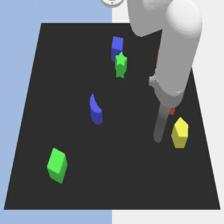
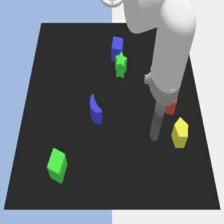

step: 10501/12800   lr: 0.00285   loss: 0.6066
step: 10502/12800   lr: 0.00285   loss: 0.6531
step: 10503/12800   lr: 0.00285   loss: 0.5930
step: 10504/12800   lr: 0.00285   loss: 0.6064
step: 10505/12800   lr: 0.00285   loss: 0.5972
step: 10506/12800   lr: 0.00284   loss: 0.6768
step: 10507/12800   lr: 0.00284   loss: 0.6363
step: 10508/12800   lr: 0.00284   loss: 0.5829
step: 10509/12800   lr: 0.00284   loss: 0.6425
step: 10510/12800   lr: 0.00283   loss: 0.6238
step: 10511/12800   lr: 0.00283   loss: 0.6424
step: 10512/12800   lr: 0.00283   loss: 0.5810
step: 10513/12800   lr: 0.00283   loss: 0.6767
step: 10514/12800   lr: 0.00282   loss: 0.6558
step: 10515/12800   lr: 0.00282   loss: 0.6043
step: 10516/12800   lr: 0.00282   loss: 0.6123
step: 10517/12800   lr: 0.00282   loss: 0.6659
step: 10518/12800   lr: 0.00281   loss: 0.6315
step: 10519/12800   lr: 0.00281   loss: 0.6233
step: 10520/12800   lr: 0.00281   loss: 0.6057
step: 10521/12800   lr: 0.00281   loss: 0.6499
step: 10522/1


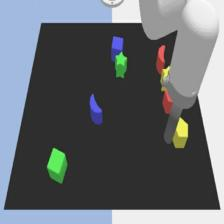
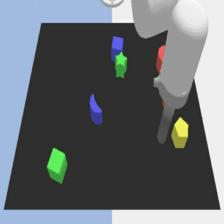
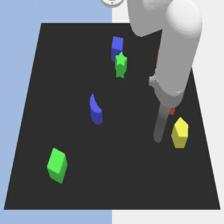
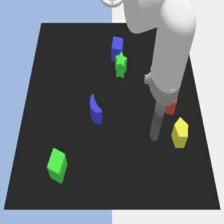

step: 10601/12800   lr: 0.00262   loss: 0.6076
step: 10602/12800   lr: 0.00262   loss: 0.6658
step: 10603/12800   lr: 0.00261   loss: 0.6776
step: 10604/12800   lr: 0.00261   loss: 0.6729
step: 10605/12800   lr: 0.00261   loss: 0.6640
step: 10606/12800   lr: 0.00261   loss: 0.6023
step: 10607/12800   lr: 0.00261   loss: 0.6726
step: 10608/12800   lr: 0.00260   loss: 0.6602
step: 10609/12800   lr: 0.00260   loss: 0.6595
step: 10610/12800   lr: 0.00260   loss: 0.5823
step: 10611/12800   lr: 0.00260   loss: 0.5407
step: 10612/12800   lr: 0.00259   loss: 0.6643
step: 10613/12800   lr: 0.00259   loss: 0.6071
step: 10614/12800   lr: 0.00259   loss: 0.6257
step: 10615/12800   lr: 0.00259   loss: 0.6482
step: 10616/12800   lr: 0.00258   loss: 0.6287
step: 10617/12800   lr: 0.00258   loss: 0.5405
step: 10618/12800   lr: 0.00258   loss: 0.6225
step: 10619/12800   lr: 0.00258   loss: 0.6253
step: 10620/12800   lr: 0.00258   loss: 0.6452
step: 10621/12800   lr: 0.00257   loss: 0.6127
step: 10622/1


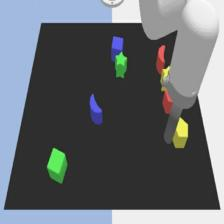
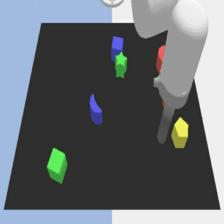
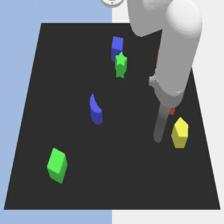
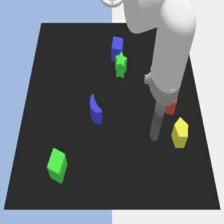

step: 10701/12800   lr: 0.00239   loss: 0.6273
step: 10702/12800   lr: 0.00239   loss: 0.6283
step: 10703/12800   lr: 0.00239   loss: 0.6435
step: 10704/12800   lr: 0.00239   loss: 0.6198
step: 10705/12800   lr: 0.00238   loss: 0.6224
step: 10706/12800   lr: 0.00238   loss: 0.5870
step: 10707/12800   lr: 0.00238   loss: 0.5816
step: 10708/12800   lr: 0.00238   loss: 0.6516
step: 10709/12800   lr: 0.00238   loss: 0.6279
step: 10710/12800   lr: 0.00237   loss: 0.6474
step: 10711/12800   lr: 0.00237   loss: 0.6140
step: 10712/12800   lr: 0.00237   loss: 0.6563
step: 10713/12800   lr: 0.00237   loss: 0.6448
step: 10714/12800   lr: 0.00236   loss: 0.6600
step: 10715/12800   lr: 0.00236   loss: 0.5993
step: 10716/12800   lr: 0.00236   loss: 0.6050
step: 10717/12800   lr: 0.00236   loss: 0.6113
step: 10718/12800   lr: 0.00236   loss: 0.6388
step: 10719/12800   lr: 0.00235   loss: 0.6538
step: 10720/12800   lr: 0.00235   loss: 0.6671
step: 10721/12800   lr: 0.00235   loss: 0.6395
step: 10722/1


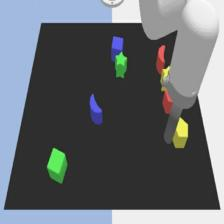
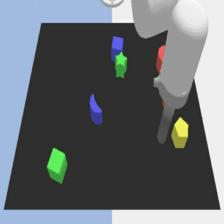
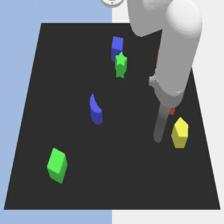
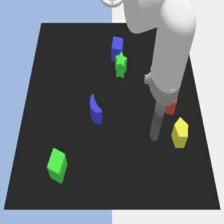

step: 10801/12800   lr: 0.00218   loss: 0.6340
step: 10802/12800   lr: 0.00217   loss: 0.6109
step: 10803/12800   lr: 0.00217   loss: 0.6446
step: 10804/12800   lr: 0.00217   loss: 0.6633
step: 10805/12800   lr: 0.00217   loss: 0.6261
step: 10806/12800   lr: 0.00217   loss: 0.6264
step: 10807/12800   lr: 0.00216   loss: 0.6282
step: 10808/12800   lr: 0.00216   loss: 0.6487
step: 10809/12800   lr: 0.00216   loss: 0.6325
step: 10810/12800   lr: 0.00216   loss: 0.6594
step: 10811/12800   lr: 0.00215   loss: 0.6575
step: 10812/12800   lr: 0.00215   loss: 0.6128
step: 10813/12800   lr: 0.00215   loss: 0.5679
step: 10814/12800   lr: 0.00215   loss: 0.5880
step: 10815/12800   lr: 0.00215   loss: 0.6809
step: 10816/12800   lr: 0.00214   loss: 0.6377
step: 10817/12800   lr: 0.00214   loss: 0.6274
step: 10818/12800   lr: 0.00214   loss: 0.5862
step: 10819/12800   lr: 0.00214   loss: 0.6627
step: 10820/12800   lr: 0.00214   loss: 0.5968
step: 10821/12800   lr: 0.00213   loss: 0.6228
step: 10822/1


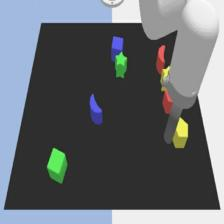
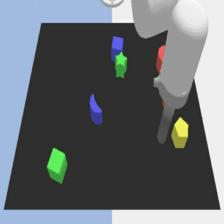
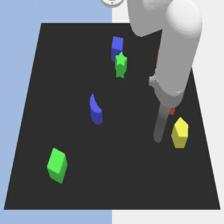
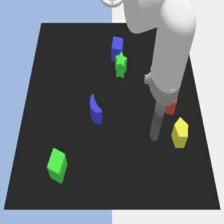

step: 10901/12800   lr: 0.00197   loss: 0.6804
step: 10902/12800   lr: 0.00197   loss: 0.6285
step: 10903/12800   lr: 0.00196   loss: 0.6528
step: 10904/12800   lr: 0.00196   loss: 0.5971
step: 10905/12800   lr: 0.00196   loss: 0.6262
step: 10906/12800   lr: 0.00196   loss: 0.6064
step: 10907/12800   lr: 0.00196   loss: 0.6359
step: 10908/12800   lr: 0.00195   loss: 0.5584
step: 10909/12800   lr: 0.00195   loss: 0.6048
step: 10910/12800   lr: 0.00195   loss: 0.5980
step: 10911/12800   lr: 0.00195   loss: 0.6034
step: 10912/12800   lr: 0.00195   loss: 0.5884
step: 10913/12800   lr: 0.00194   loss: 0.6821
step: 10914/12800   lr: 0.00194   loss: 0.6150
step: 10915/12800   lr: 0.00194   loss: 0.6398
step: 10916/12800   lr: 0.00194   loss: 0.5979
step: 10917/12800   lr: 0.00194   loss: 0.5854
step: 10918/12800   lr: 0.00193   loss: 0.5943
step: 10919/12800   lr: 0.00193   loss: 0.6433
step: 10920/12800   lr: 0.00193   loss: 0.6444
step: 10921/12800   lr: 0.00193   loss: 0.6080
step: 10922/1


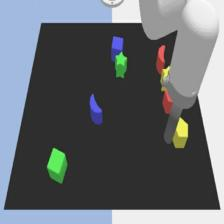
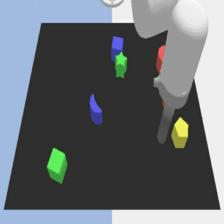
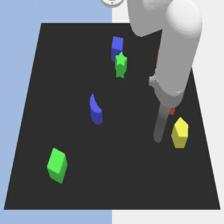
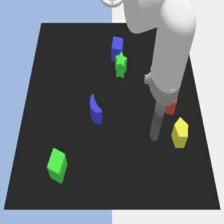

step: 11001/12800   lr: 0.00177   loss: 0.6096
step: 11002/12800   lr: 0.00177   loss: 0.6895
step: 11003/12800   lr: 0.00177   loss: 0.6741
step: 11004/12800   lr: 0.00177   loss: 0.6311
step: 11005/12800   lr: 0.00176   loss: 0.5986
step: 11006/12800   lr: 0.00176   loss: 0.6340
step: 11007/12800   lr: 0.00176   loss: 0.6863
step: 11008/12800   lr: 0.00176   loss: 0.6551
step: 11009/12800   lr: 0.00176   loss: 0.6839
step: 11010/12800   lr: 0.00175   loss: 0.6241
step: 11011/12800   lr: 0.00175   loss: 0.6171
step: 11012/12800   lr: 0.00175   loss: 0.5869
step: 11013/12800   lr: 0.00175   loss: 0.6724
step: 11014/12800   lr: 0.00175   loss: 0.6284
step: 11015/12800   lr: 0.00174   loss: 0.5908
step: 11016/12800   lr: 0.00174   loss: 0.6332
step: 11017/12800   lr: 0.00174   loss: 0.6479
step: 11018/12800   lr: 0.00174   loss: 0.6136
step: 11019/12800   lr: 0.00174   loss: 0.6276
step: 11020/12800   lr: 0.00173   loss: 0.6389
step: 11021/12800   lr: 0.00173   loss: 0.6363
step: 11022/1


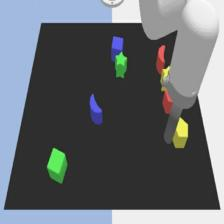
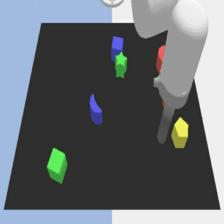
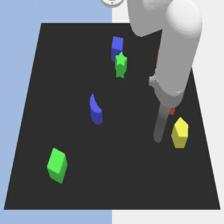
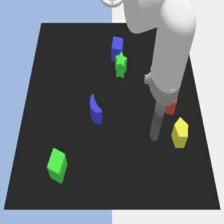

step: 11101/12800   lr: 0.00158   loss: 0.5690
step: 11102/12800   lr: 0.00158   loss: 0.6021
step: 11103/12800   lr: 0.00158   loss: 0.6263
step: 11104/12800   lr: 0.00158   loss: 0.6671
step: 11105/12800   lr: 0.00158   loss: 0.6230
step: 11106/12800   lr: 0.00157   loss: 0.6005
step: 11107/12800   lr: 0.00157   loss: 0.6613
step: 11108/12800   lr: 0.00157   loss: 0.5879
step: 11109/12800   lr: 0.00157   loss: 0.6448
step: 11110/12800   lr: 0.00157   loss: 0.6019
step: 11111/12800   lr: 0.00156   loss: 0.6361
step: 11112/12800   lr: 0.00156   loss: 0.6104
step: 11113/12800   lr: 0.00156   loss: 0.6354
step: 11114/12800   lr: 0.00156   loss: 0.6476
step: 11115/12800   lr: 0.00156   loss: 0.6546
step: 11116/12800   lr: 0.00156   loss: 0.6263
step: 11117/12800   lr: 0.00155   loss: 0.6727
step: 11118/12800   lr: 0.00155   loss: 0.6738
step: 11119/12800   lr: 0.00155   loss: 0.6546
step: 11120/12800   lr: 0.00155   loss: 0.6803
step: 11121/12800   lr: 0.00155   loss: 0.6082
step: 11122/1


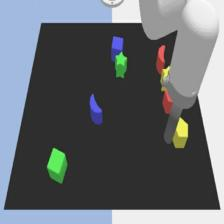
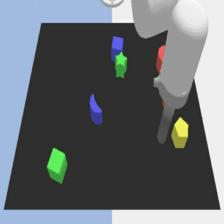
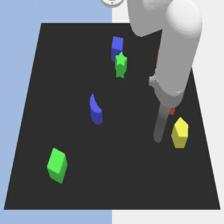
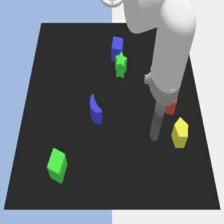

step: 11201/12800   lr: 0.00141   loss: 0.6388
step: 11202/12800   lr: 0.00140   loss: 0.5686
step: 11203/12800   lr: 0.00140   loss: 0.6197
step: 11204/12800   lr: 0.00140   loss: 0.6308
step: 11205/12800   lr: 0.00140   loss: 0.6340
step: 11206/12800   lr: 0.00140   loss: 0.6443
step: 11207/12800   lr: 0.00139   loss: 0.6440
step: 11208/12800   lr: 0.00139   loss: 0.6342
step: 11209/12800   lr: 0.00139   loss: 0.6758
step: 11210/12800   lr: 0.00139   loss: 0.6876
step: 11211/12800   lr: 0.00139   loss: 0.6282
step: 11212/12800   lr: 0.00139   loss: 0.6444
step: 11213/12800   lr: 0.00138   loss: 0.6196
step: 11214/12800   lr: 0.00138   loss: 0.5974
step: 11215/12800   lr: 0.00138   loss: 0.6489
step: 11216/12800   lr: 0.00138   loss: 0.5169
step: 11217/12800   lr: 0.00138   loss: 0.5642
step: 11218/12800   lr: 0.00138   loss: 0.6513
step: 11219/12800   lr: 0.00137   loss: 0.6745
step: 11220/12800   lr: 0.00137   loss: 0.5874
step: 11221/12800   lr: 0.00137   loss: 0.6683
step: 11222/1


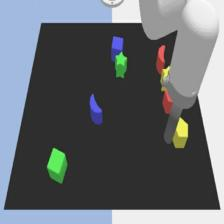
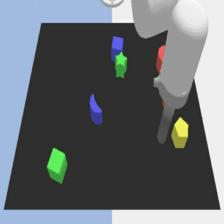
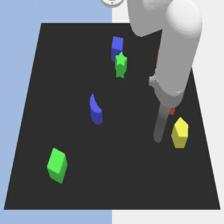
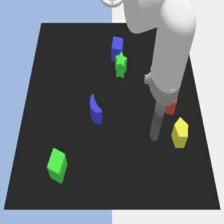

step: 11301/12800   lr: 0.00124   loss: 0.6875
step: 11302/12800   lr: 0.00124   loss: 0.6407
step: 11303/12800   lr: 0.00123   loss: 0.6322
step: 11304/12800   lr: 0.00123   loss: 0.6032
step: 11305/12800   lr: 0.00123   loss: 0.6277
step: 11306/12800   lr: 0.00123   loss: 0.6807
step: 11307/12800   lr: 0.00123   loss: 0.5929
step: 11308/12800   lr: 0.00123   loss: 0.6171
step: 11309/12800   lr: 0.00122   loss: 0.5896
step: 11310/12800   lr: 0.00122   loss: 0.6157
step: 11311/12800   lr: 0.00122   loss: 0.6383
step: 11312/12800   lr: 0.00122   loss: 0.5966
step: 11313/12800   lr: 0.00122   loss: 0.5637
step: 11314/12800   lr: 0.00122   loss: 0.6293
step: 11315/12800   lr: 0.00121   loss: 0.6775
step: 11316/12800   lr: 0.00121   loss: 0.6159
step: 11317/12800   lr: 0.00121   loss: 0.7025
step: 11318/12800   lr: 0.00121   loss: 0.6525
step: 11319/12800   lr: 0.00121   loss: 0.6502
step: 11320/12800   lr: 0.00121   loss: 0.6148
step: 11321/12800   lr: 0.00121   loss: 0.6521
step: 11322/1


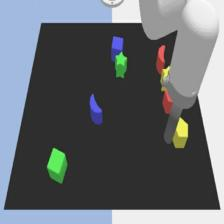
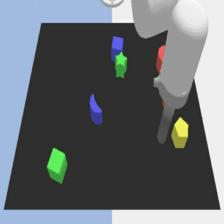
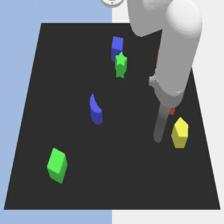
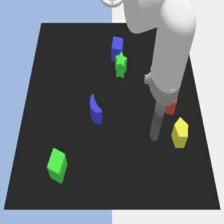

step: 11401/12800   lr: 0.00108   loss: 0.6190
step: 11402/12800   lr: 0.00108   loss: 0.6117
step: 11403/12800   lr: 0.00108   loss: 0.6030
step: 11404/12800   lr: 0.00108   loss: 0.6390
step: 11405/12800   lr: 0.00107   loss: 0.6457
step: 11406/12800   lr: 0.00107   loss: 0.6835
step: 11407/12800   lr: 0.00107   loss: 0.5692
step: 11408/12800   lr: 0.00107   loss: 0.6278
step: 11409/12800   lr: 0.00107   loss: 0.6499
step: 11410/12800   lr: 0.00107   loss: 0.5853
step: 11411/12800   lr: 0.00106   loss: 0.6225
step: 11412/12800   lr: 0.00106   loss: 0.6408
step: 11413/12800   lr: 0.00106   loss: 0.5958
step: 11414/12800   lr: 0.00106   loss: 0.6311
step: 11415/12800   lr: 0.00106   loss: 0.6551
step: 11416/12800   lr: 0.00106   loss: 0.6470
step: 11417/12800   lr: 0.00106   loss: 0.6096
step: 11418/12800   lr: 0.00105   loss: 0.5834
step: 11419/12800   lr: 0.00105   loss: 0.6237
step: 11420/12800   lr: 0.00105   loss: 0.6161
step: 11421/12800   lr: 0.00105   loss: 0.6272
step: 11422/1


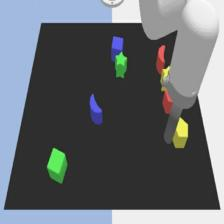
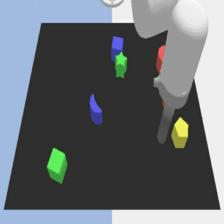
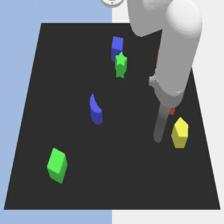
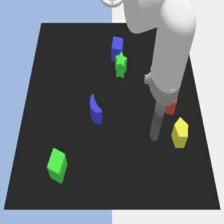

step: 11501/12800   lr: 0.00093   loss: 0.5587
step: 11502/12800   lr: 0.00093   loss: 0.6188
step: 11503/12800   lr: 0.00093   loss: 0.5887
step: 11504/12800   lr: 0.00093   loss: 0.5685
step: 11505/12800   lr: 0.00093   loss: 0.6132
step: 11506/12800   lr: 0.00093   loss: 0.6493
step: 11507/12800   lr: 0.00092   loss: 0.6078
step: 11508/12800   lr: 0.00092   loss: 0.6632
step: 11509/12800   lr: 0.00092   loss: 0.5833
step: 11510/12800   lr: 0.00092   loss: 0.6420
step: 11511/12800   lr: 0.00092   loss: 0.5850
step: 11512/12800   lr: 0.00092   loss: 0.6612
step: 11513/12800   lr: 0.00092   loss: 0.6726
step: 11514/12800   lr: 0.00091   loss: 0.6160
step: 11515/12800   lr: 0.00091   loss: 0.6523
step: 11516/12800   lr: 0.00091   loss: 0.6287
step: 11517/12800   lr: 0.00091   loss: 0.6068
step: 11518/12800   lr: 0.00091   loss: 0.6954
step: 11519/12800   lr: 0.00091   loss: 0.5990
step: 11520/12800   lr: 0.00091   loss: 0.6978
step: 11521/12800   lr: 0.00090   loss: 0.6171
step: 11522/1


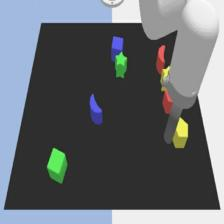
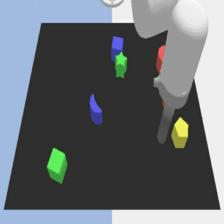
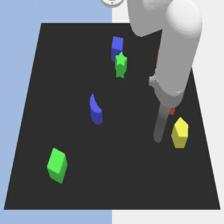
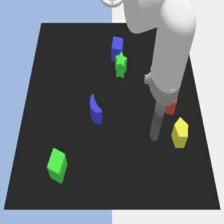

step: 11601/12800   lr: 0.00080   loss: 0.6452
step: 11602/12800   lr: 0.00079   loss: 0.6546
step: 11603/12800   lr: 0.00079   loss: 0.6165
step: 11604/12800   lr: 0.00079   loss: 0.5624
step: 11605/12800   lr: 0.00079   loss: 0.6009
step: 11606/12800   lr: 0.00079   loss: 0.5469
step: 11607/12800   lr: 0.00079   loss: 0.6253
step: 11608/12800   lr: 0.00079   loss: 0.6086
step: 11609/12800   lr: 0.00079   loss: 0.6106
step: 11610/12800   lr: 0.00078   loss: 0.6562
step: 11611/12800   lr: 0.00078   loss: 0.6546
step: 11612/12800   lr: 0.00078   loss: 0.6472
step: 11613/12800   lr: 0.00078   loss: 0.6519
step: 11614/12800   lr: 0.00078   loss: 0.6192
step: 11615/12800   lr: 0.00078   loss: 0.6372
step: 11616/12800   lr: 0.00078   loss: 0.6659
step: 11617/12800   lr: 0.00078   loss: 0.5512
step: 11618/12800   lr: 0.00077   loss: 0.6631
step: 11619/12800   lr: 0.00077   loss: 0.6082
step: 11620/12800   lr: 0.00077   loss: 0.5890
step: 11621/12800   lr: 0.00077   loss: 0.6463
step: 11622/1


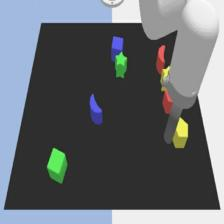
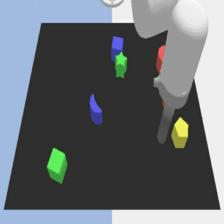
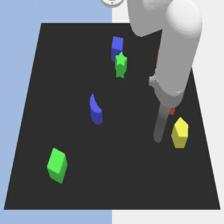
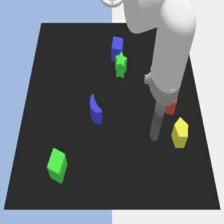

step: 11701/12800   lr: 0.00067   loss: 0.5879
step: 11702/12800   lr: 0.00067   loss: 0.6036
step: 11703/12800   lr: 0.00067   loss: 0.6916
step: 11704/12800   lr: 0.00067   loss: 0.6219
step: 11705/12800   lr: 0.00066   loss: 0.6400
step: 11706/12800   lr: 0.00066   loss: 0.6444
step: 11707/12800   lr: 0.00066   loss: 0.6651
step: 11708/12800   lr: 0.00066   loss: 0.6564
step: 11709/12800   lr: 0.00066   loss: 0.6564
step: 11710/12800   lr: 0.00066   loss: 0.6137
step: 11711/12800   lr: 0.00066   loss: 0.6204
step: 11712/12800   lr: 0.00066   loss: 0.6625
step: 11713/12800   lr: 0.00066   loss: 0.6670
step: 11714/12800   lr: 0.00065   loss: 0.5753
step: 11715/12800   lr: 0.00065   loss: 0.6195
step: 11716/12800   lr: 0.00065   loss: 0.6481
step: 11717/12800   lr: 0.00065   loss: 0.5675
step: 11718/12800   lr: 0.00065   loss: 0.6305
step: 11719/12800   lr: 0.00065   loss: 0.6336
step: 11720/12800   lr: 0.00065   loss: 0.6316
step: 11721/12800   lr: 0.00065   loss: 0.6483
step: 11722/1


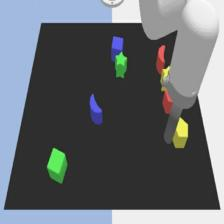
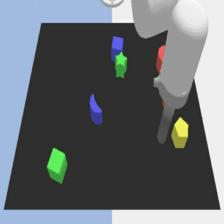
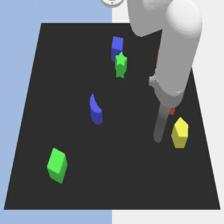
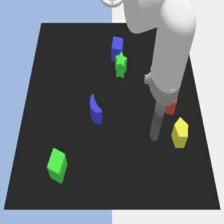

step: 11801/12800   lr: 0.00055   loss: 0.6139
step: 11802/12800   lr: 0.00055   loss: 0.5970
step: 11803/12800   lr: 0.00055   loss: 0.7041
step: 11804/12800   lr: 0.00055   loss: 0.6483
step: 11805/12800   lr: 0.00055   loss: 0.6343
step: 11806/12800   lr: 0.00055   loss: 0.5852
step: 11807/12800   lr: 0.00055   loss: 0.5982
step: 11808/12800   lr: 0.00055   loss: 0.6341
step: 11809/12800   lr: 0.00055   loss: 0.6514
step: 11810/12800   lr: 0.00054   loss: 0.6100
step: 11811/12800   lr: 0.00054   loss: 0.6565
step: 11812/12800   lr: 0.00054   loss: 0.5927
step: 11813/12800   lr: 0.00054   loss: 0.6193
step: 11814/12800   lr: 0.00054   loss: 0.6263
step: 11815/12800   lr: 0.00054   loss: 0.6183
step: 11816/12800   lr: 0.00054   loss: 0.6287
step: 11817/12800   lr: 0.00054   loss: 0.5611
step: 11818/12800   lr: 0.00054   loss: 0.6175
step: 11819/12800   lr: 0.00053   loss: 0.6884
step: 11820/12800   lr: 0.00053   loss: 0.6469
step: 11821/12800   lr: 0.00053   loss: 0.5970
step: 11822/1


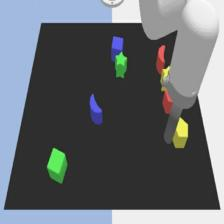
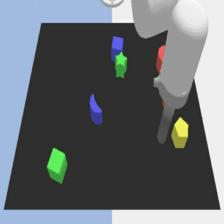
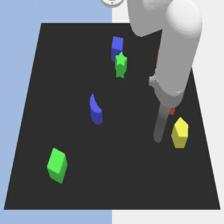
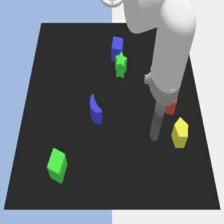

step: 11901/12800   lr: 0.00045   loss: 0.6061
step: 11902/12800   lr: 0.00045   loss: 0.6669
step: 11903/12800   lr: 0.00045   loss: 0.6296
step: 11904/12800   lr: 0.00045   loss: 0.6118
step: 11905/12800   lr: 0.00045   loss: 0.6073
step: 11906/12800   lr: 0.00044   loss: 0.6836
step: 11907/12800   lr: 0.00044   loss: 0.6197
step: 11908/12800   lr: 0.00044   loss: 0.6386
step: 11909/12800   lr: 0.00044   loss: 0.6386
step: 11910/12800   lr: 0.00044   loss: 0.5715
step: 11911/12800   lr: 0.00044   loss: 0.6426
step: 11912/12800   lr: 0.00044   loss: 0.6227
step: 11913/12800   lr: 0.00044   loss: 0.6097
step: 11914/12800   lr: 0.00044   loss: 0.6182
step: 11915/12800   lr: 0.00044   loss: 0.6461
step: 11916/12800   lr: 0.00043   loss: 0.5832
step: 11917/12800   lr: 0.00043   loss: 0.6174
step: 11918/12800   lr: 0.00043   loss: 0.6491
step: 11919/12800   lr: 0.00043   loss: 0.6159
step: 11920/12800   lr: 0.00043   loss: 0.6314
step: 11921/12800   lr: 0.00043   loss: 0.6461
step: 11922/1


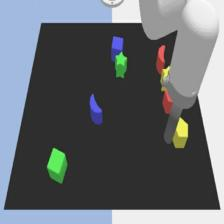
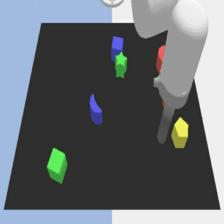
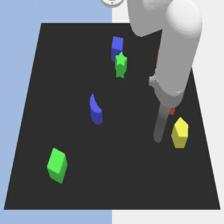
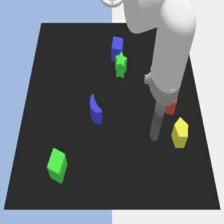

step: 12001/12800   lr: 0.00036   loss: 0.6541
step: 12002/12800   lr: 0.00035   loss: 0.6682
step: 12003/12800   lr: 0.00035   loss: 0.6448
step: 12004/12800   lr: 0.00035   loss: 0.5748
step: 12005/12800   lr: 0.00035   loss: 0.6099
step: 12006/12800   lr: 0.00035   loss: 0.6160
step: 12007/12800   lr: 0.00035   loss: 0.6724
step: 12008/12800   lr: 0.00035   loss: 0.6569
step: 12009/12800   lr: 0.00035   loss: 0.6524
step: 12010/12800   lr: 0.00035   loss: 0.6430
step: 12011/12800   lr: 0.00035   loss: 0.6346
step: 12012/12800   lr: 0.00035   loss: 0.6470
step: 12013/12800   lr: 0.00034   loss: 0.6814
step: 12014/12800   lr: 0.00034   loss: 0.6339
step: 12015/12800   lr: 0.00034   loss: 0.5923
step: 12016/12800   lr: 0.00034   loss: 0.6791
step: 12017/12800   lr: 0.00034   loss: 0.5824
step: 12018/12800   lr: 0.00034   loss: 0.6482
step: 12019/12800   lr: 0.00034   loss: 0.5728
step: 12020/12800   lr: 0.00034   loss: 0.6194
step: 12021/12800   lr: 0.00034   loss: 0.6135
step: 12022/1


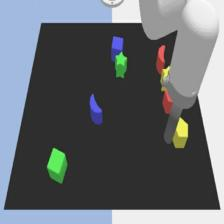
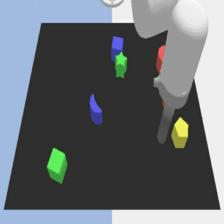
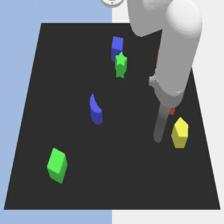
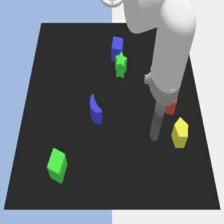

step: 12101/12800   lr: 0.00027   loss: 0.6102
step: 12102/12800   lr: 0.00027   loss: 0.6475
step: 12103/12800   lr: 0.00027   loss: 0.6110
step: 12104/12800   lr: 0.00027   loss: 0.6551
step: 12105/12800   lr: 0.00027   loss: 0.6090
step: 12106/12800   lr: 0.00027   loss: 0.6388
step: 12107/12800   lr: 0.00027   loss: 0.6281
step: 12108/12800   lr: 0.00027   loss: 0.6057
step: 12109/12800   lr: 0.00027   loss: 0.6637
step: 12110/12800   lr: 0.00027   loss: 0.6334
step: 12111/12800   lr: 0.00026   loss: 0.6062
step: 12112/12800   lr: 0.00026   loss: 0.6231
step: 12113/12800   lr: 0.00026   loss: 0.6542
step: 12114/12800   lr: 0.00026   loss: 0.6572
step: 12115/12800   lr: 0.00026   loss: 0.6513
step: 12116/12800   lr: 0.00026   loss: 0.6148
step: 12117/12800   lr: 0.00026   loss: 0.5774
step: 12118/12800   lr: 0.00026   loss: 0.6695
step: 12119/12800   lr: 0.00026   loss: 0.6405
step: 12120/12800   lr: 0.00026   loss: 0.6599
step: 12121/12800   lr: 0.00026   loss: 0.6602
step: 12122/1


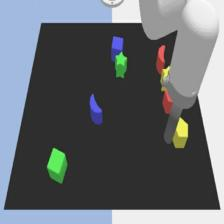
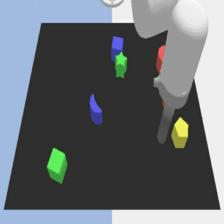
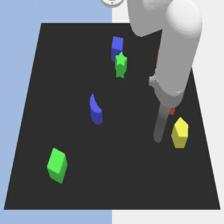
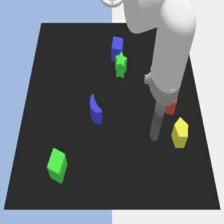

step: 12201/12800   lr: 0.00020   loss: 0.6188
step: 12202/12800   lr: 0.00020   loss: 0.6648
step: 12203/12800   lr: 0.00020   loss: 0.5521
step: 12204/12800   lr: 0.00020   loss: 0.6546
step: 12205/12800   lr: 0.00020   loss: 0.6173
step: 12206/12800   lr: 0.00020   loss: 0.6199
step: 12207/12800   lr: 0.00020   loss: 0.6113
step: 12208/12800   lr: 0.00020   loss: 0.6539
step: 12209/12800   lr: 0.00020   loss: 0.6749
step: 12210/12800   lr: 0.00019   loss: 0.6510
step: 12211/12800   lr: 0.00019   loss: 0.6456
step: 12212/12800   lr: 0.00019   loss: 0.6156
step: 12213/12800   lr: 0.00019   loss: 0.6333
step: 12214/12800   lr: 0.00019   loss: 0.5702
step: 12215/12800   lr: 0.00019   loss: 0.6013
step: 12216/12800   lr: 0.00019   loss: 0.6485
step: 12217/12800   lr: 0.00019   loss: 0.5582
step: 12218/12800   lr: 0.00019   loss: 0.6529
step: 12219/12800   lr: 0.00019   loss: 0.6326
step: 12220/12800   lr: 0.00019   loss: 0.6356
step: 12221/12800   lr: 0.00019   loss: 0.6847
step: 12222/1


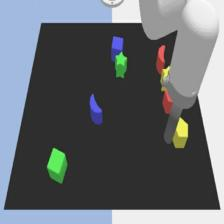
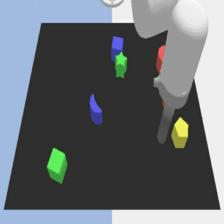
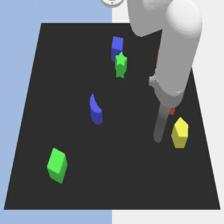
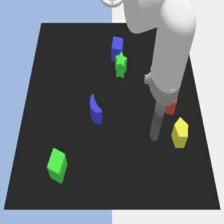

step: 12301/12800   lr: 0.00014   loss: 0.5891
step: 12302/12800   lr: 0.00014   loss: 0.6263
step: 12303/12800   lr: 0.00014   loss: 0.6141
step: 12304/12800   lr: 0.00014   loss: 0.6138
step: 12305/12800   lr: 0.00014   loss: 0.6349
step: 12306/12800   lr: 0.00014   loss: 0.6723
step: 12307/12800   lr: 0.00014   loss: 0.5783
step: 12308/12800   lr: 0.00014   loss: 0.6683
step: 12309/12800   lr: 0.00013   loss: 0.6580
step: 12310/12800   lr: 0.00013   loss: 0.6446
step: 12311/12800   lr: 0.00013   loss: 0.5945
step: 12312/12800   lr: 0.00013   loss: 0.6628
step: 12313/12800   lr: 0.00013   loss: 0.5867
step: 12314/12800   lr: 0.00013   loss: 0.6212
step: 12315/12800   lr: 0.00013   loss: 0.6419
step: 12316/12800   lr: 0.00013   loss: 0.6841
step: 12317/12800   lr: 0.00013   loss: 0.6413
step: 12318/12800   lr: 0.00013   loss: 0.6436
step: 12319/12800   lr: 0.00013   loss: 0.6472
step: 12320/12800   lr: 0.00013   loss: 0.5861
step: 12321/12800   lr: 0.00013   loss: 0.6569
step: 12322/1


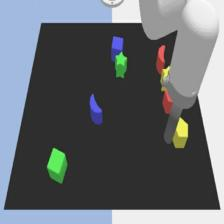
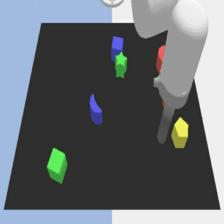
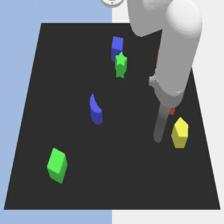
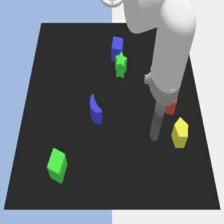

step: 12401/12800   lr: 0.00009   loss: 0.6681
step: 12402/12800   lr: 0.00009   loss: 0.6613
step: 12403/12800   lr: 0.00009   loss: 0.6607
step: 12404/12800   lr: 0.00009   loss: 0.6395
step: 12405/12800   lr: 0.00009   loss: 0.6042
step: 12406/12800   lr: 0.00009   loss: 0.6245
step: 12407/12800   lr: 0.00009   loss: 0.5745
step: 12408/12800   lr: 0.00009   loss: 0.6643
step: 12409/12800   lr: 0.00009   loss: 0.6621
step: 12410/12800   lr: 0.00009   loss: 0.6310
step: 12411/12800   lr: 0.00008   loss: 0.5774
step: 12412/12800   lr: 0.00008   loss: 0.6333
step: 12413/12800   lr: 0.00008   loss: 0.5867
step: 12414/12800   lr: 0.00008   loss: 0.5739
step: 12415/12800   lr: 0.00008   loss: 0.5875
step: 12416/12800   lr: 0.00008   loss: 0.5979
step: 12417/12800   lr: 0.00008   loss: 0.5902
step: 12418/12800   lr: 0.00008   loss: 0.5918
step: 12419/12800   lr: 0.00008   loss: 0.6657
step: 12420/12800   lr: 0.00008   loss: 0.6545
step: 12421/12800   lr: 0.00008   loss: 0.6844
step: 12422/1


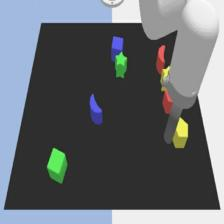
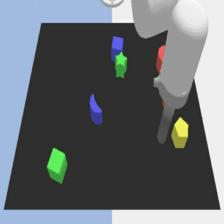
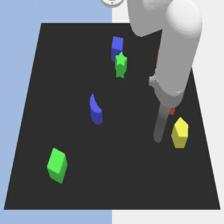
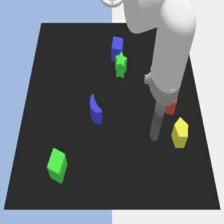

step: 12501/12800   lr: 0.00005   loss: 0.6133
step: 12502/12800   lr: 0.00005   loss: 0.6141
step: 12503/12800   lr: 0.00005   loss: 0.6583
step: 12504/12800   lr: 0.00005   loss: 0.6293
step: 12505/12800   lr: 0.00005   loss: 0.6232
step: 12506/12800   lr: 0.00005   loss: 0.6111
step: 12507/12800   lr: 0.00005   loss: 0.6099
step: 12508/12800   lr: 0.00005   loss: 0.5772
step: 12509/12800   lr: 0.00005   loss: 0.6568
step: 12510/12800   lr: 0.00005   loss: 0.6506
step: 12511/12800   lr: 0.00005   loss: 0.6621
step: 12512/12800   lr: 0.00005   loss: 0.5996
step: 12513/12800   lr: 0.00005   loss: 0.6227
step: 12514/12800   lr: 0.00005   loss: 0.6116
step: 12515/12800   lr: 0.00005   loss: 0.6853
step: 12516/12800   lr: 0.00005   loss: 0.6473
step: 12517/12800   lr: 0.00004   loss: 0.5803
step: 12518/12800   lr: 0.00004   loss: 0.6507
step: 12519/12800   lr: 0.00004   loss: 0.6114
step: 12520/12800   lr: 0.00004   loss: 0.6604
step: 12521/12800   lr: 0.00004   loss: 0.6280
step: 12522/1


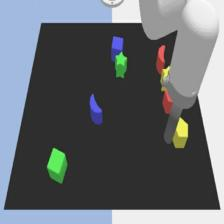
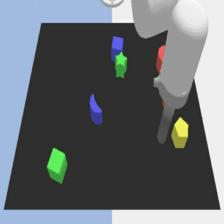
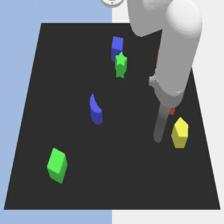
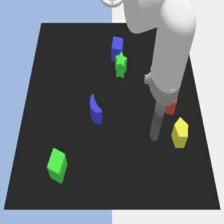

step: 12601/12800   lr: 0.00002   loss: 0.6649
step: 12602/12800   lr: 0.00002   loss: 0.6582
step: 12603/12800   lr: 0.00002   loss: 0.6217
step: 12604/12800   lr: 0.00002   loss: 0.6178
step: 12605/12800   lr: 0.00002   loss: 0.6219
step: 12606/12800   lr: 0.00002   loss: 0.6261
step: 12607/12800   lr: 0.00002   loss: 0.6002
step: 12608/12800   lr: 0.00002   loss: 0.6632
step: 12609/12800   lr: 0.00002   loss: 0.6346
step: 12610/12800   lr: 0.00002   loss: 0.6028
step: 12611/12800   lr: 0.00002   loss: 0.6068
step: 12612/12800   lr: 0.00002   loss: 0.6402
step: 12613/12800   lr: 0.00002   loss: 0.6637
step: 12614/12800   lr: 0.00002   loss: 0.6562
step: 12615/12800   lr: 0.00002   loss: 0.6006
step: 12616/12800   lr: 0.00002   loss: 0.6499
step: 12617/12800   lr: 0.00002   loss: 0.6012
step: 12618/12800   lr: 0.00002   loss: 0.6239
step: 12619/12800   lr: 0.00002   loss: 0.6000
step: 12620/12800   lr: 0.00002   loss: 0.5954
step: 12621/12800   lr: 0.00002   loss: 0.6370
step: 12622/1


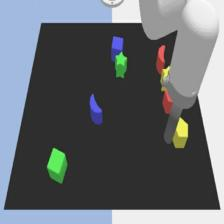
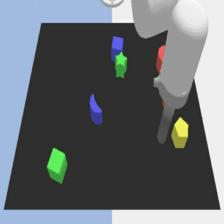
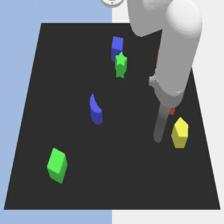
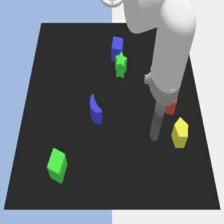

step: 12701/12800   lr: 0.00001   loss: 0.6515
step: 12702/12800   lr: 0.00001   loss: 0.6491
step: 12703/12800   lr: 0.00001   loss: 0.6446
step: 12704/12800   lr: 0.00001   loss: 0.6544
step: 12705/12800   lr: 0.00001   loss: 0.6229
step: 12706/12800   lr: 0.00001   loss: 0.6308
step: 12707/12800   lr: 0.00000   loss: 0.5562
step: 12708/12800   lr: 0.00000   loss: 0.6370
step: 12709/12800   lr: 0.00000   loss: 0.6667
step: 12710/12800   lr: 0.00000   loss: 0.6290
step: 12711/12800   lr: 0.00000   loss: 0.6697
step: 12712/12800   lr: 0.00000   loss: 0.6156
step: 12713/12800   lr: 0.00000   loss: 0.6535
step: 12714/12800   lr: 0.00000   loss: 0.6131
step: 12715/12800   lr: 0.00000   loss: 0.6234
step: 12716/12800   lr: 0.00000   loss: 0.6712
step: 12717/12800   lr: 0.00000   loss: 0.6335
step: 12718/12800   lr: 0.00000   loss: 0.6754
step: 12719/12800   lr: 0.00000   loss: 0.6647
step: 12720/12800   lr: 0.00000   loss: 0.6190
step: 12721/12800   lr: 0.00000   loss: 0.6124
step: 12722/1


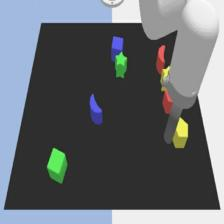
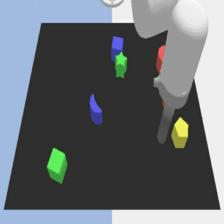
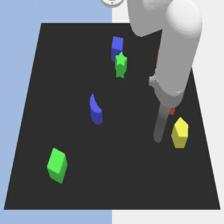
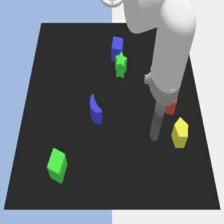

Model predictions


2024-06-19 06:34:15.364041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



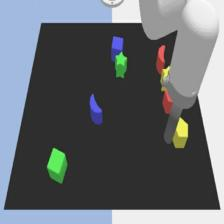
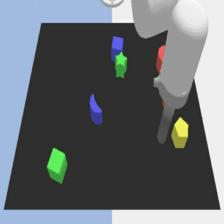
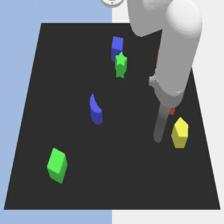
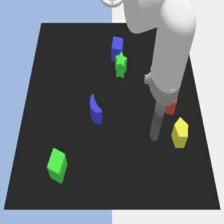
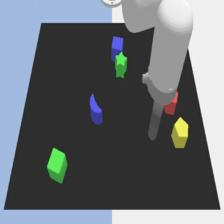
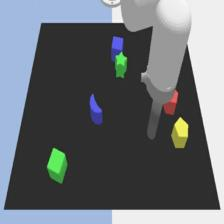
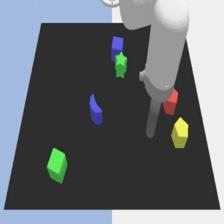
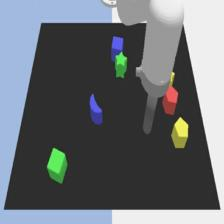
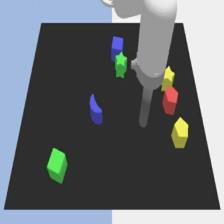
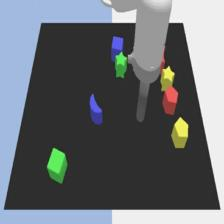
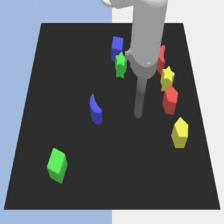
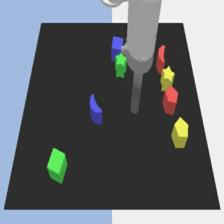
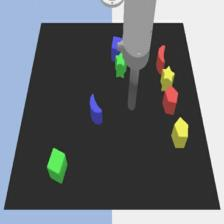
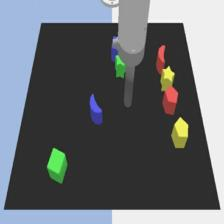
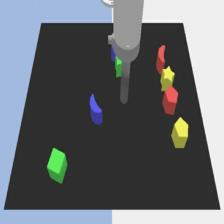
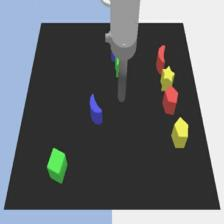
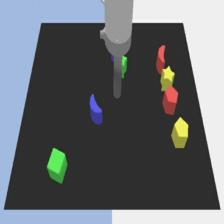
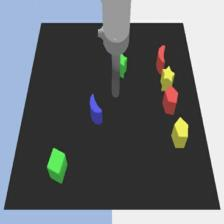
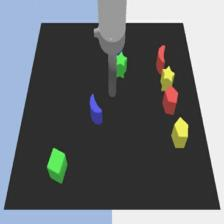
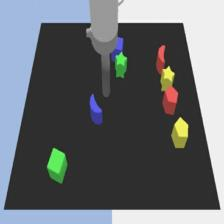
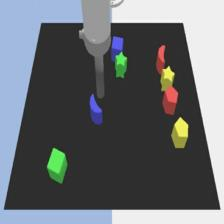
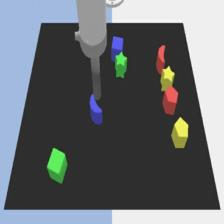
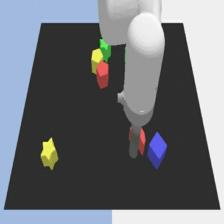
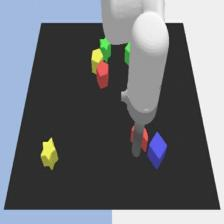
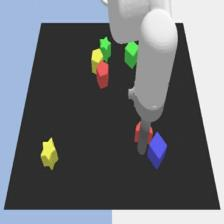
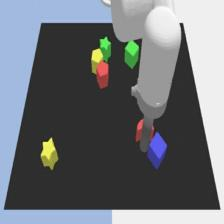
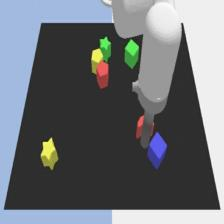
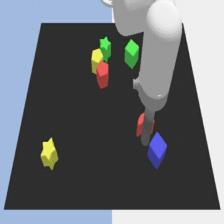
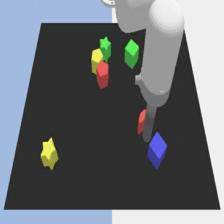
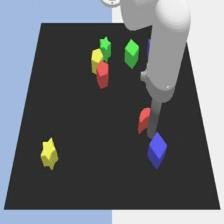
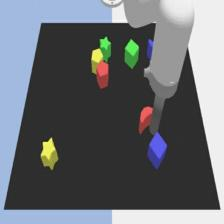
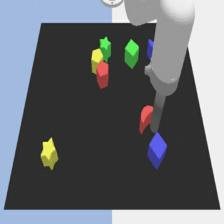
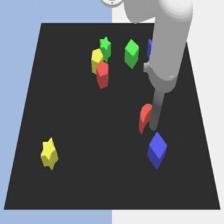
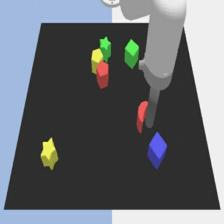
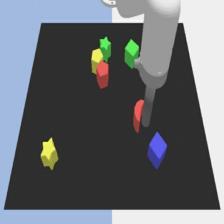
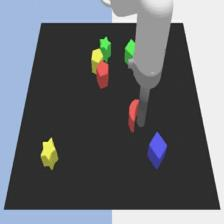
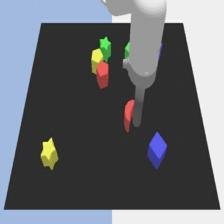
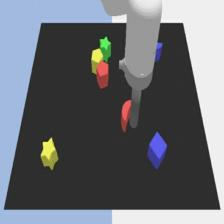
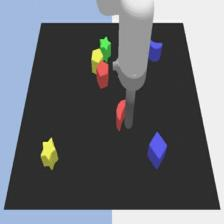
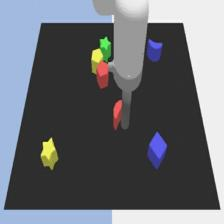
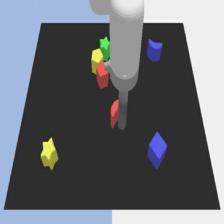
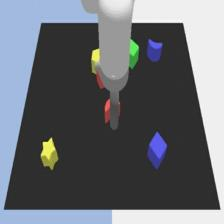
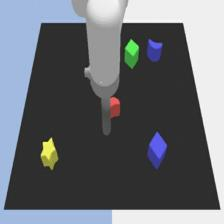
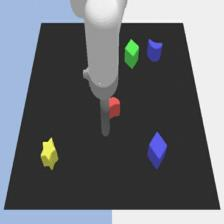
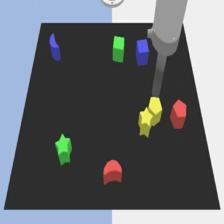
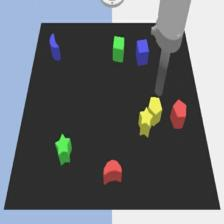
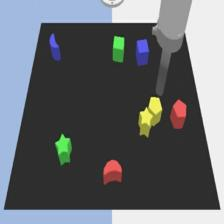
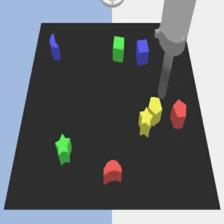
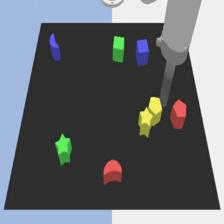
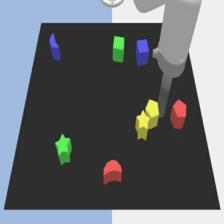
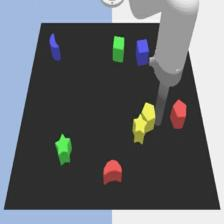
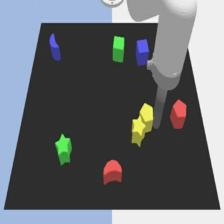
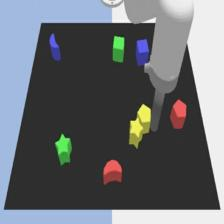
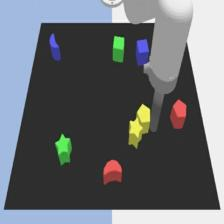
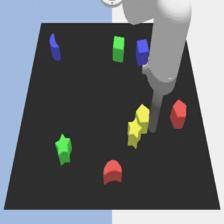
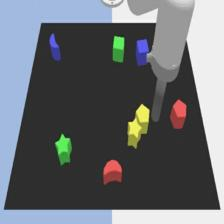
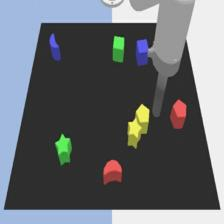
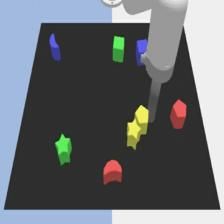
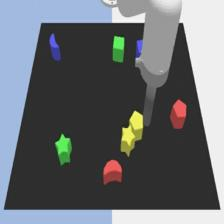
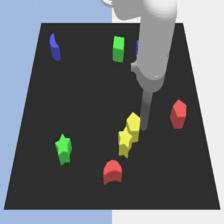
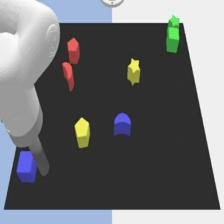
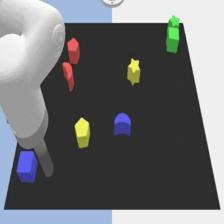
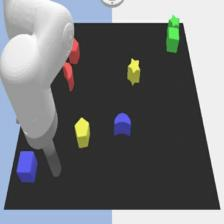
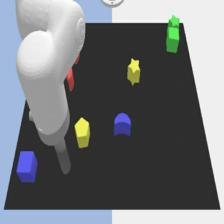
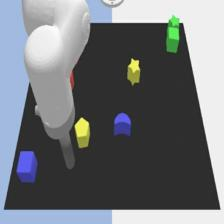
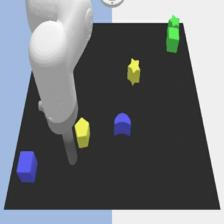
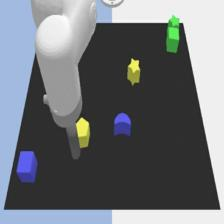
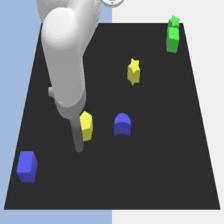
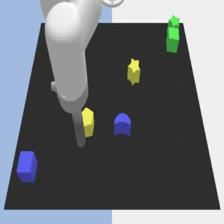
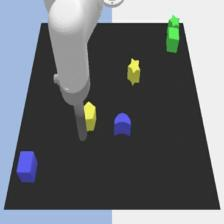
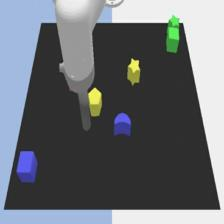
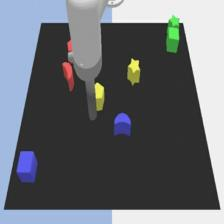
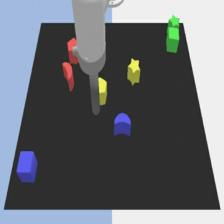
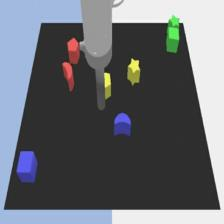
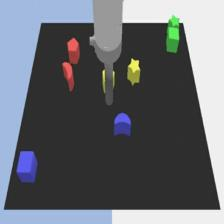
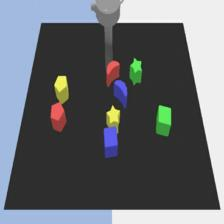
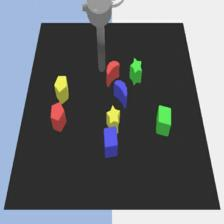
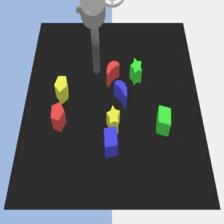
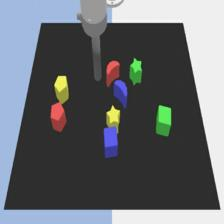
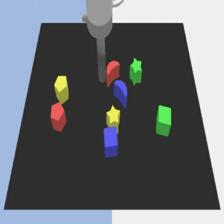
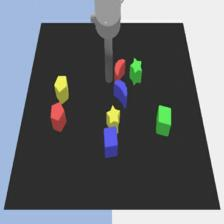
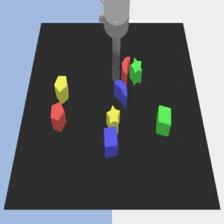
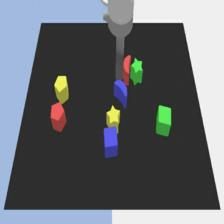
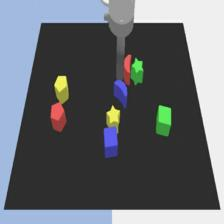
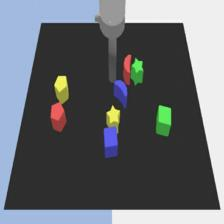
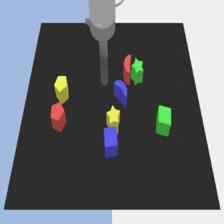
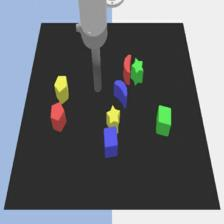
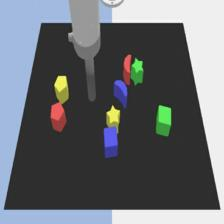
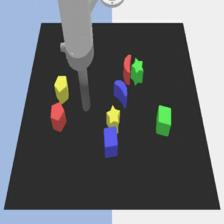

In [ ]:
    # %%

train(params=params)